$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\partial}
    \newcommand{\sentinels}{\mathbf{\boundary}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\linavg}{\bar{\tau}}
    \newcommand{\invvar}{\tau^{IV}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
    \newcommand{\saleprice}{\mathtt{SalePrice}}
    \newcommand{\sqft}{\mathtt{SQFT}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\tax}{\mathtt{TaxClass}}
    \newcommand{\building}{\mathtt{BuildingClass}}
    \newcommand{\trans}{^{\intercal}}
$$

The New York City school district is itself divided into sub-districts. From now on, by “district”, I will be talking about these sub-districts. Residents are guaranteed a slot in a school within their district, but there is some system whereby a child can apply to attend schools outside of the district, which might possibly dampen the treatment effect.

Our goal is to detect discontinuities in the price of housing across the school district boundaries.

In [1]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
import Base: mean
using Distributions
using Base.LinAlg
using Distances
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats

import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/GeoJSON.ji for module GeoJSON.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/GLM.ji for module GLM.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/MultivariateStats.ji for module MultivariateStats.


In [2]:
include("../src/GeoRDD.jl")

GeoRDD

In [3]:
NYC_sales=readtable("NYC_data/processed/NYC_sales.csv", header=true)
begin
    nyc_schdistrs = NYC_sales[:SchDistr]
    schd_strings = [dec(sd,2) for sd in  nyc_schdistrs.values]
    str_schdistrs = NullableCategoricalArray(schd_strings, nyc_schdistrs.isnull)
    str_schdistrs
    NYC_sales[:SchDistr] = str_schdistrs
end
# categorical variables
categorical!(NYC_sales, [:BOROUGH,
    :BUILDING_CLASS_CATEGORY,
    :BUILDING_CLASS_AT_TIME_OF_SALE,
    :ZIP_CODE,
    :TAX_CLASS_AT_PRESENT,
    :TAX_CLASS_AT_TIME_OF_SALE,
    :NEIGHBORHOOD,
    ])   

In [4]:
residential = Dict(
"01  ONE FAMILY DWELLINGS"=>true,
"02  TWO FAMILY DWELLINGS"=>true,
"03  THREE FAMILY DWELLINGS"=>true,
"04  TAX CLASS 1 CONDOS"=>true,
"05  TAX CLASS 1 VACANT LAND"=>false,
"06  TAX CLASS 1 - OTHER"=>false,
"07  RENTALS - WALKUP APARTMENTS"=>false,
"08  RENTALS - ELEVATOR APARTMENTS"=>false,
"09  COOPS - WALKUP APARTMENTS"=>true,
"10  COOPS - ELEVATOR APARTMENTS"=>true,
"11  SPECIAL CONDO BILLING LOTS"=>false,
"11A CONDO-RENTALS"=>false,
"12  CONDOS - WALKUP APARTMENTS"=>true, # why are these duplicated?
"13  CONDOS - ELEVATOR APARTMENTS"=>true,
"14  RENTALS - 4-10 UNIT"=>false,
"15  CONDOS - 2-10 UNIT RESIDENTIAL"=>true,
"16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT"=>false,
"17  CONDO COOPS"=>true,
"18  TAX CLASS 3 - UNTILITY PROPERTIES"=>false,
"21  OFFICE BUILDINGS"=>false,
"22  STORE BUILDINGS"=>false,
"23  LOFT BUILDINGS"=>false,
"25  LUXURY HOTELS"=>false,
"26  OTHER HOTELS"=>false,
"27  FACTORIES"=>false,
"28  COMMERCIAL CONDOS"=>false,
"29  COMMERCIAL GARAGES"=>false,
"30  WAREHOUSES"=>false,
"31  COMMERCIAL VACANT LAND"=>false,
"32  HOSPITAL AND HEALTH FACILITIES"=>false,
"33  EDUCATIONAL FACILITIES"=>false,
"34  THEATRES"=>false,
"35  INDOOR PUBLIC AND CULTURAL FACILITIES"=>false,
"36  OUTDOOR RECREATIONAL FACILITIES"=>false,
"37  RELIGIOUS FACILITIES"=>false,
"38  ASYLUMS AND HOMES"=>false,
"41  TAX CLASS 4 - OTHER"=>false,
"42  CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC"=>false,
"43  CONDO OFFICE BUILDINGS"=>false,
"44  CONDO PARKING"=>false,
"45  CONDO HOTELS"=>false,
"46  CONDO STORE BUILDINGS"=>false,
"47  CONDO NON-BUSINESS STORAGE"=>false,
"48  CONDO TERRACES/GARDENS/CABANAS"=>false,
"49  CONDO WAREHOUSES/FACTORY/INDUS"=>false,
);

In [9]:
NYC_sales[:logSalePricePerSQFT] = map(log, NYC_sales[:SALE_PRICE]) .- map(log, NYC_sales[:GROSS_SQUARE_FEET])
believable = zeros(Bool, size(NYC_sales,1))
removed=zeros(Int, 12)
for i in 1:size(NYC_sales,1)
    if NYC_sales[i,:SALE_PRICE].isnull
        removed[1] += 1
        continue
    end
    if NYC_sales[i,:SchDistr].isnull
        removed[2] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_AT_TIME_OF_SALE].isnull
        removed[3] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_CATEGORY].isnull
        removed[4] += 1
        continue
    end
    if !residential[get(NYC_sales[i,:BUILDING_CLASS_CATEGORY])]
        removed[5] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_CATEGORY].isnull
        removed[6] += 1
        continue
    end
    if NYC_sales[i,:TAX_CLASS_AT_TIME_OF_SALE].isnull
        removed[7] += 1
        continue
    end
    if NYC_sales[i,:GROSS_SQUARE_FEET].isnull
        removed[8] += 1
        continue
    end
    if get(NYC_sales[i,:GROSS_SQUARE_FEET])<100.0
        removed[9] += 1
        continue
    end
    if get(NYC_sales[i,:logSalePricePerSQFT]) < 3.0
        removed[10] += 1
        # that's too cheap
        continue
    end
    if get(NYC_sales[i,:logSalePricePerSQFT]) > 8.0
        removed[11] += 1
        # that's too expensive
        continue
    end
    if NYC_sales[i,:XCoord].isnull
        removed[12] += 1
        continue
    end
    if NYC_sales[i,:YCoord].isnull
        removed[13] += 1
        continue
    end
    believable[i] = true
end

nobsv_ = sum(believable)
for_mm = copy(NYC_sales[believable,:])
reordering = collect(1:nobsv_)
schdistrs = sort(for_mm[:SchDistr].pool.levels)
istart = 1
for name in schdistrs
    schdistrs_col = for_mm[:SchDistr]
    indices = find(schdistrs_col.refs .== find(schdistrs_col.pool.index .== name)[1])
    nobsv_schdistr = length(indices)
    @printf("District %s has %d sales\n", name, nobsv_schdistr)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{String,Vector{Int}}()
for name in schdistrs
    schdistrs_col = for_mm[:SchDistr]
    indices = find(schdistrs_col.refs .== find(schdistrs_col.pool.index .== name)[1])
    schdistr_indices[name] = indices
end
;
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePricePerSQFT]
    X_dict[name] = for_mm[schdistr_indices[name],[:XCoord, :YCoord]]
end
sentinels_json=GeoJSON.parsefile("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (dec(f.properties["SchoolDistrict1"],2), dec(f.properties["SchoolDistrict2"],2))
    sentinels[key] = f.geometry
end

District 01 has 4 sales
District 02 has 82 sales
District 03 has 32 sales
District 04 has 6 sales
District 05 has 39 sales
District 06 has 30 sales
District 07 has 69 sales
District 08 has 699 sales
District 09 has 162 sales
District 10 has 312 sales
District 11 has 1169 sales
District 12 has 204 sales
District 13 has 320 sales
District 14 has 194 sales
District 15 has 513 sales
District 16 has 418 sales
District 17 has 455 sales
District 18 has 558 sales
District 19 has 681 sales
District 20 has 1010 sales
District 21 has 765 sales
District 22 has 1453 sales
District 23 has 245 sales
District 24 has 1282 sales
District 25 has 1316 sales
District 26 has 1262 sales
District 27 has 2183 sales
District 28 has 1032 sales
District 29 has 1952 sales
District 30 has 688 sales
District 32 has 344 sales


In [10]:
schdistr_indices

Dict{String,Array{Int64,1}} with 31 entries:
  "24" => [9421,9422,9423,9424,9425,9426,9427,9428,9429,9430  …  10693,10694,10…
  "29" => [16496,16497,16498,16499,16500,16501,16502,16503,16504,16505  …  1843…
  "32" => [19136,19137,19138,19139,19140,19141,19142,19143,19144,19145  …  1947…
  "07" => [194,195,196,197,198,199,200,201,202,203  …  253,254,255,256,257,258,…
  "12" => [2605,2606,2607,2608,2609,2610,2611,2612,2613,2614  …  2799,2800,2801…
  "20" => [5948,5949,5950,5951,5952,5953,5954,5955,5956,5957  …  6948,6949,6950…
  "06" => [164,165,166,167,168,169,170,171,172,173  …  184,185,186,187,188,189,…
  "25" => [10703,10704,10705,10706,10707,10708,10709,10710,10711,10712  …  1200…
  "03" => [87,88,89,90,91,92,93,94,95,96  …  109,110,111,112,113,114,115,116,11…
  "22" => [7723,7724,7725,7726,7727,7728,7729,7730,7731,7732  …  9166,9167,9168…
  "11" => [1436,1437,1438,1439,1440,1441,1442,1443,1444,1445  …  2595,2596,2597…
  "23" => [9176,9177,9178,9179,9180,9181,9182,9183,9184,9185  … 

# Dataset

New York publishes a year's worth of house sales on a rolling basis. Annoyingly, this means that data that is older than a year disappears, and I've not been able to find this data online. But New York is a density, so even just a year's data is quite a large dataset.

I also have some covariates, though somewhat less rich than I found in Tucson. What I have is square footage, tax class and [building class](http://nycprop.nyc.gov/nycproperty/help/hlpbldgcode.html). I've geocoded the address of each sale to get a latitude and longitude, and projected the coordinates onto a Euclidean plane in order to be able to calculate distances.

![sales map](NYC_plots/NYC_sales.png)

## Data cleaning

I remove the following sales:

* any sale with missing data in the sale price, square footage, property covariates, geographical coordinates (due to failed geocoding)
* sales outside of any NYC school district
* properties smaller than 100 sq ft
* outliers in the price per sqft, which I defined as sales outside of $3 < Y_i < 8$

I remove tiny properties because I feel like they might behave differently than the rest of the market.
Removing outliers is possibly contentious, but it makes sense to me that some sales between friends or family members could have a very low $Y_i$ that isn't a true representation of the market price, and that some high prices could be equally disconnected from the market.

This leaves {{sum(believable)}} out of {{length(believable)}} sales records in NYC, mostly because of properties that don't have a reported gross square footage.

# Model

I decided to define the outcome to be the log price per square foot. The model is a Gaussian Process in the spatial covariates on top of a ridge regression on the property covariates (building and tax class). Within a school district we could write the model as [suggestions for clearer notation welcome]:

\begin{align}
    Y_i &= \log\del{ \frac{\saleprice_i}{\sqft_i}} = \beta_0 + \beta_{1\tax\sbr{i}} + \beta_{2\building\sbr{i}} + f(\xvec_i) + \epsilon_i \\
    \epsilon_i &\sim \normal\del{0, \sigma_y^2} \\
    \beta_{1j},\beta_{2j} &\sim \normal\del{0, \sigma_\beta^2} \\
    f(\xvec_i) &\sim \gp\del{0, k(\xvec, \xvec')} \\
    k(\xvec, \xvec') &= \sigma_f^2 \exp\cbr{ - (\xvec-\xvec')\trans(\xvec-\xvec') / 2\ell^2}
\end{align}

A visual inspection of the house sales map above led me to focus on the boundary between districts 19 and 27. I found a map online of average maths performance in each school district, which shows that districts 19 and 27 are quite different. It's important to note that the boundary between the two districts is also part of the boundary between Brooklyn and Queens, so we won't be able to attribute a causal effect solely to the difference in school districts. A histogram of $Y$ in both districts also shows that marginally the house prices are very different.

![districts](NYC_plots/NYC_school_performances_croppped.png)

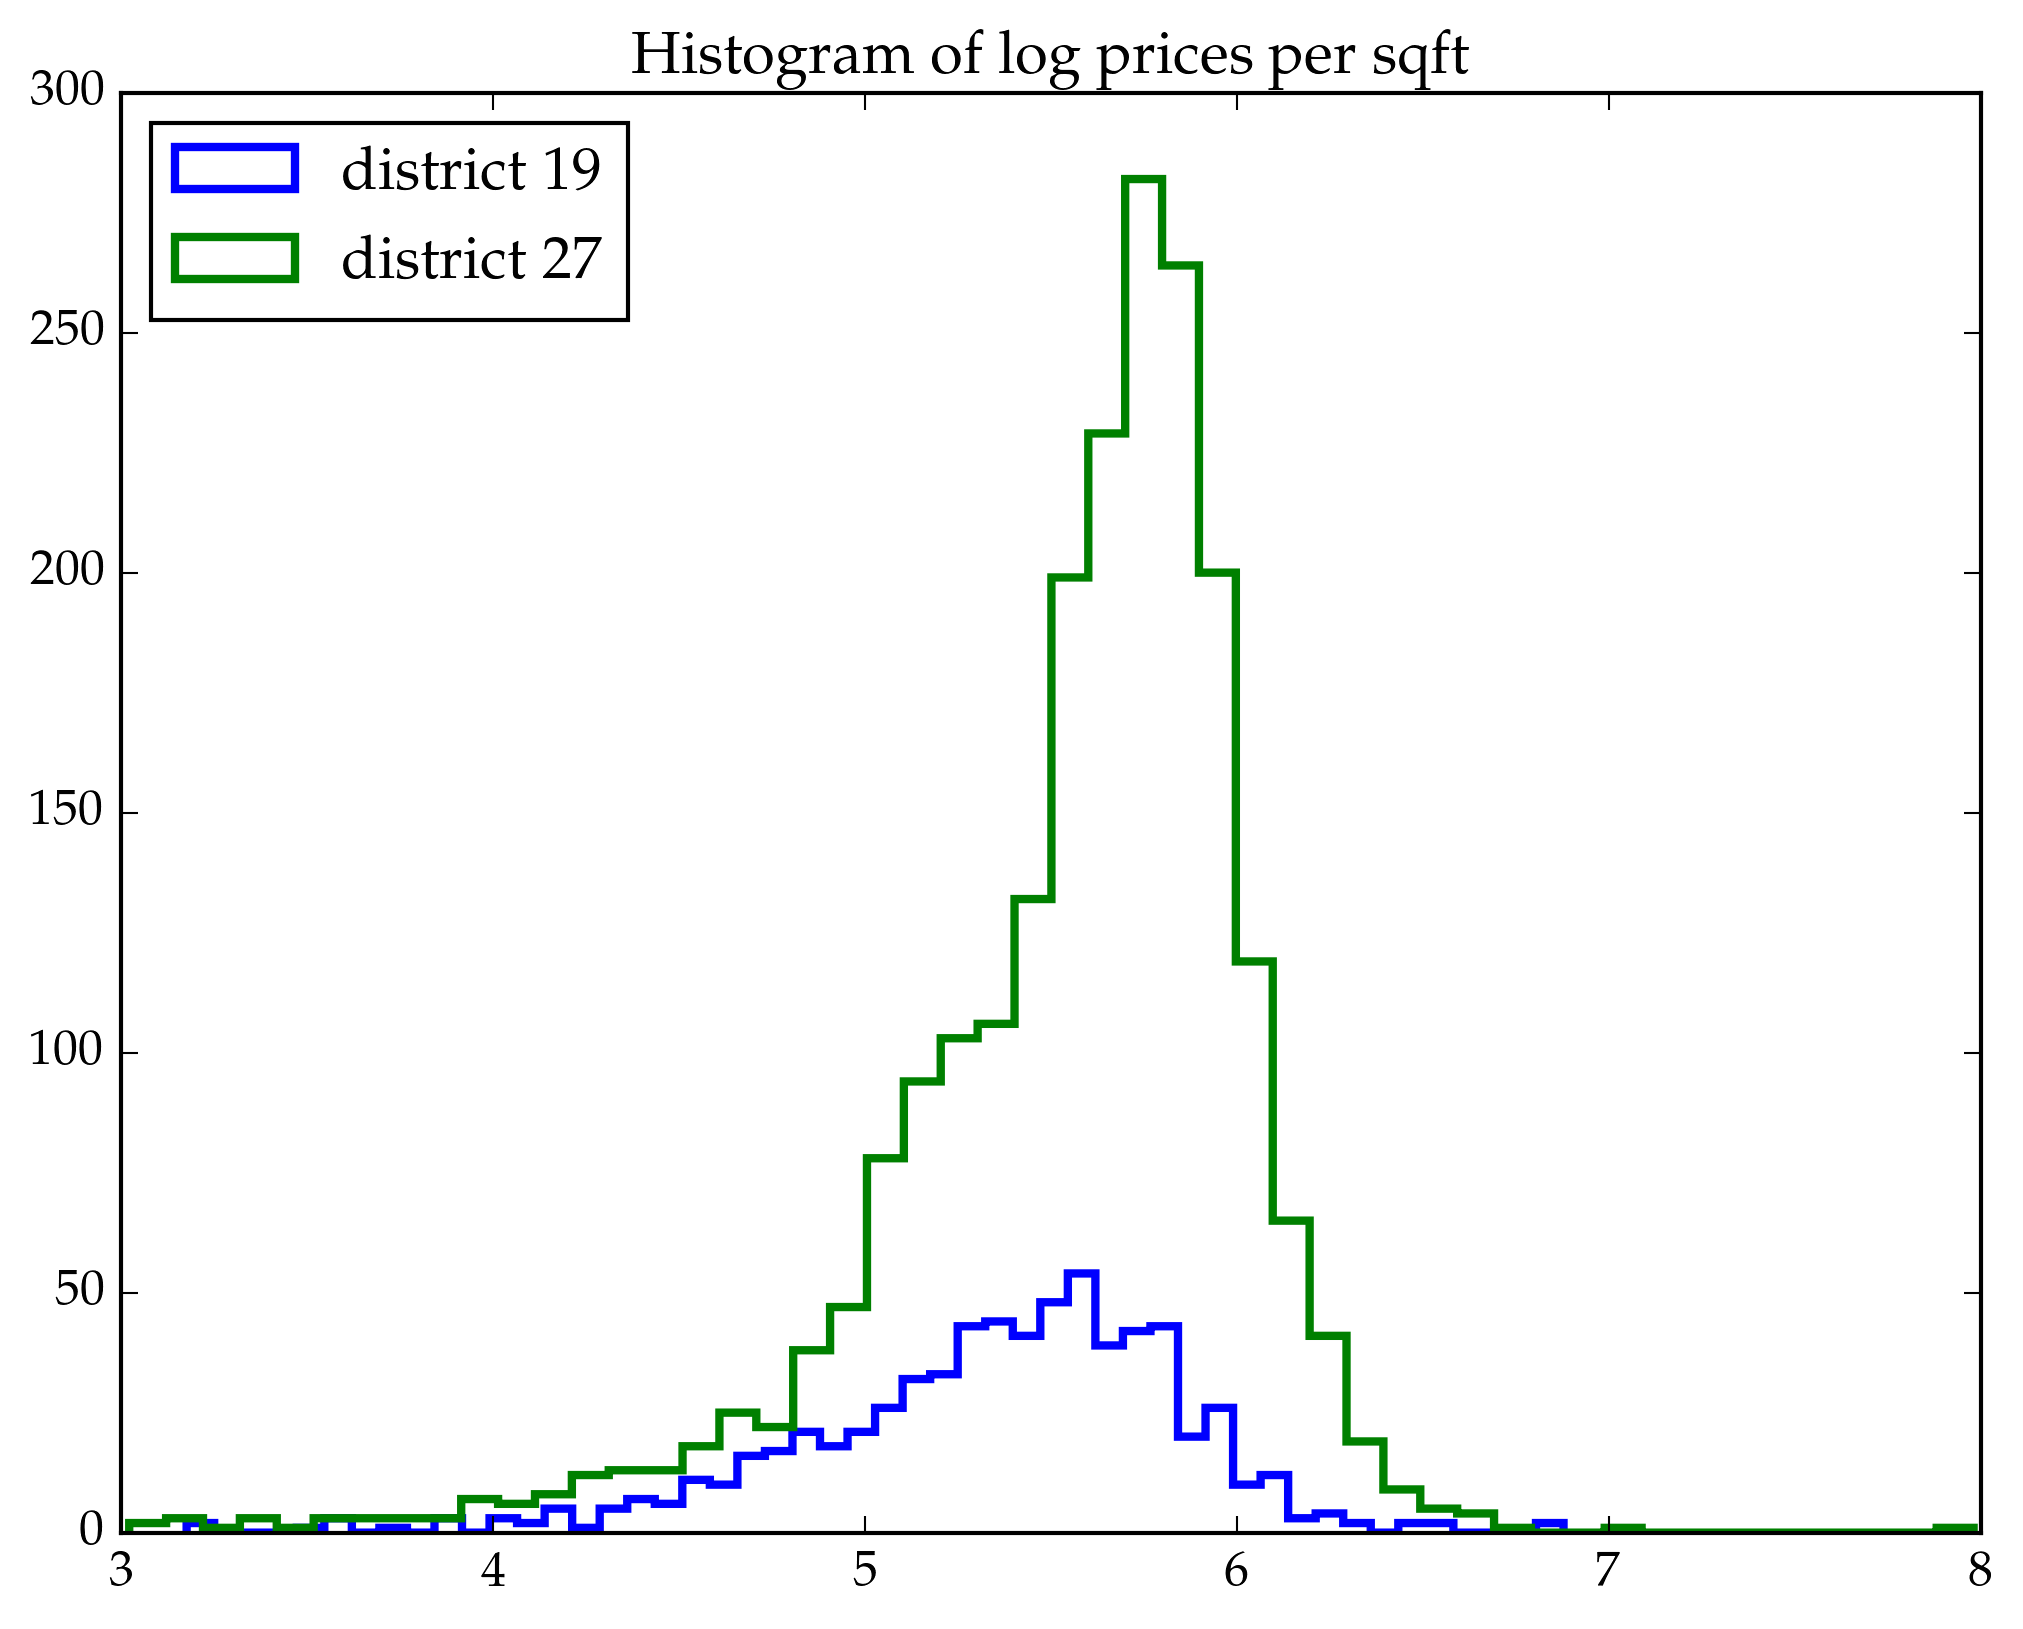

In [13]:
distrA = "19"
distrB = "27"
plt.plt[:hist](Y_dict[distrA],bins=50, histtype="step", label=@sprintf("district %s", distrA), linewidth=2)
plt.plt[:hist](Y_dict[distrB],bins=50, histtype="step", label=@sprintf("district %s", distrB), linewidth=2)
plt.title("Histogram of log prices per sqft")
plt.legend(loc="upper left")
;

In [14]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePricePerSQFT ~ BUILDING_CLASS_AT_TIME_OF_SALE + TAX_CLASS_AT_TIME_OF_SALE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [15]:
σβ = 1.0
βkern_ = GaussianProcesses.LinIso(log(σβ))
type GPCovars   
    m:: Mean                # Mean object
    k::Kernel               # Kernel object
    βkern::Kernel
    logNoise::Float64       # log standard deviation of observation noise
    
    # Observation data
    nobsv::Int              # Number of observations
    X::Matrix{Float64}      # Input observations
    y::Vector{Float64}      # Output observations
    D::Array{Float64,2}
    data::KernelData        # Auxiliary observation data (to speed up calculations)
    βdata::KernelData
    p::Int                  # Dimensions of covariates
    dim::Int                # Dimension of inputs
    
    # Auxiliary data
    cK::AbstractPDMat       # (k + exp(2*obsNoise))
    alpha::Vector{Float64}  # (k + exp(2*obsNoise))⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood

    function GPCovars(X::Matrix{Float64}, 
        y::Vector{Float64}, 
        D::Matrix{Float64},
        m::Mean, 
        k::Kernel,
        βkern::Kernel,
        logNoise::Float64=-1e8,
        )
        dim, nobsv = size(X)
        p, nobsv2 = size(D)
        nobsv == nobsv2 || throw(ArgumentError("X and D should have the same number of rows"))
        length(y) == nobsv || throw(ArgumentError("X and y should have the same number of rows"))
        gp = new(m, k, βkern, logNoise, nobsv, X, y, D, KernelData(k, X), KernelData(βkern, D), p, dim)
        update_mll!(gp)
        return gp
    end
end

In [16]:
function update_mll!(gp::GPCovars, cK::Matrix{Float64})
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    gp.cK = PDMat(cK)
    gp.alpha = gp.cK \ (gp.y .- μ)
    gp.mLL = -dot((gp.y-μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0
end
function update_mll!(gp::GPCovars)
    Σbuffer = Array(Float64, gp.nobsv, gp.nobsv)
    update_mll!(gp, Σbuffer)
end
function update_mll!!(gp::GPCovars)
    cK = gp.cK.mat
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    chol_buffer = gp.cK.chol.factors
    copy!(chol_buffer, cK)
    chol = cholfact!(Symmetric(chol_buffer))
    gp.cK = PDMats.PDMat(cK, chol)
    gp.alpha = gp.cK \ (gp.y - μ)
    gp.mLL = -dot((gp.y - μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0 # Marginal log-likelihood
end
function get_ααinvcKI!(ααinvcKI::Matrix, cK::AbstractPDMat, α::Vector)
    nobsv = length(α)
    size(ααinvcKI) == (nobsv, nobsv) || throw(ArgumentError, 
                @sprintf("Buffer for ααinvcKI should be a %dx%d matrix, not %dx%d",
                         nobsv, nobsv,
                         size(ααinvcKI,1), size(ααinvcKI,2)))
    ααinvcKI[:,:] = 0.0
    @inbounds for i in 1:nobsv
        ααinvcKI[i,i] = -1.0
    end
    A_ldiv_B!(cK.chol, ααinvcKI)
    LinAlg.BLAS.ger!(1.0, α, α, ααinvcKI)
end
""" Update gradient of marginal log-likelihood """
function update_mll_and_dmll!(gp::GPCovars,
    Kgrad::Matrix{Float64},
    ααinvcKI::Matrix{Float64}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!!(gp)
    n_mean_params = num_params(gp.m)
    n_kern_params = num_params(gp.k)
    n_beta_params = num_params(gp.βkern)
    gp.dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = gp.logNoise
    get_ααinvcKI!(ααinvcKI, gp.cK, gp.alpha)
    i=1
    if noise
        gp.dmLL[i] = exp(2.0*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = grad_stack(gp.m, gp.X)
        for j in 1:n_mean_params
            gp.dmLL[i] = dot(Mgrads[:,j],gp.alpha)
            i += 1
        end
    end
    if kern
        for iparam in 1:n_kern_params
            grad_slice!(Kgrad, gp.k, gp.X, gp.data, iparam)
            gp.dmLL[i] = dot(Kgrad,ααinvcKI)/2.0
            i+=1
        end
    end
    if beta
        for iparam in 1:n_beta_params
            grad_slice!(Kgrad, gp.βkern, gp.D, gp.βdata, iparam)
            gp.dmLL[i] = vecdot(ααinvcKI,Kgrad)/2.0
            i+=1
        end
    end
end
function set_params!(gp::GPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        gp.logNoise = hyp[i]
        i+=1
    end
    if mean
        set_params!(gp.m, hyp[i:i+num_params(gp.m)-1])
        i+=num_params(gp.m)
    end
    if kern
        set_params!(gp.k, hyp[i:i+num_params(gp.k)-1])
        i+=num_params(gp.k)
    end
    if beta
        set_params!(gp.βkern, hyp[i:i+num_params(gp.βkern)-1])
        i+=num_params(gp.βkern)
    end
end
function get_params(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, gp.logNoise); end
    if mean;  append!(params, get_params(gp.m)); end
    if kern; append!(params,  get_params(gp.k)); end
    if beta; append!(params,  get_params(gp.βkern)); end
    return params
end
function optimize!(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method::Optim.Optimizer=ConjugateGradient(), 
                    options::Optim.Options=Optim.Options())
    Kgrad_buffer = Array(Float64, gp.nobsv, gp.nobsv)
    ααinvcKI = Array(Float64, gp.nobsv, gp.nobsv)
    function mll(hyp::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll!!(gp)
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll_and_dmll!(gp, Kgrad_buffer, ααinvcKI; noise=noise, mean=mean, kern=kern, beta=beta)
            grad[:] = -gp.dmLL
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = OnceDifferentiable(mll, dmll!, mll_and_dmll!)
    init = get_params(gp;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init,method,options)
    set_params!(gp, Optim.minimizer(results); noise=noise, mean=mean, kern=kern, beta=beta)
    return results
end
;

# Optimize hyperparameters using district 27

I start by optimizing the hyperparameters $\beta_0$, $\sigma_\beta$, $\sigma_f$, $\ell$ and $\sigma_y$ using only data for district 27 (the larger of the two, with {{length(Y_dict["27"])}} sales). Optimizing within a single district makes it computationally quicker and easier to implement, and ensures that there is no interference from the treatment effect.

In [97]:
district="27" # bigger district of the two
# GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.2
L = 1300.0
_kern = SEIso(log(L), log(σf))
k_wmean = SEIso(log(L), log(σf)) + fix(GeoRDD.ConstantKernel(log(10.0)))
_logNoise = log(σy)
_X = X_dict[district]'
_Y = Y_dict[district]
_Dd = D_[schdistr_indices[district],:]'
_m = MeanConst(mean(_Y))
gp=GPCovars(_X, _Y, _Dd, _m, _kern, βkern_, _logNoise)
;

In [99]:
βkern_2 = GaussianProcesses.LinIso(log(1.0))
gp_mean=GPCovars(_X, _Y, _Dd, _m, k_wmean, βkern_2, _logNoise)
;

The optimization takes a very reasonable 20-30 seconds.

In [100]:
@time opt_out=optimize!(gp, options=Optim.Options(x_tol=1e-8, f_tol=1e-8));

 48.856156 seconds (2.35 M allocations: 146.840 MB, 0.50% gc time)


In [101]:
@time opt_out_mean=optimize!(gp_mean, options=Optim.Options(x_tol=1e-8, f_tol=1e-8));

 45.959191 seconds (2.08 M allocations: 7.307 GB, 2.39% gc time)


In [102]:
opt_out

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.6094379124341003,5.562204296285703, ...]
 * Minimizer: [-0.8703741682015186,5.532319793887273, ...]
 * Minimum: 1.262872e+03
 * Iterations: 31
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 115
 * Gradient Calls: 83

The fitted hyperparameters are:

| Parameter      | Fitted Value                             |
|----------------|------------------------------------------|
| $\sigma_y$     | {{@sprintf("%.4f", exp(gp.logNoise))}} |
| $\sigma_f$     | {{@sprintf("%.4f", √(gp.k.σ2))}}        |
| $\sigma_\beta$ | {{@sprintf("%.4f", 1/√gp.βkern.ℓ2)}}   |
| $\ell$ (feet)   | {{@sprintf("%.4f", √(gp.k.ℓ2))}}       |

The fitted hyperparameters with mean uncertainty are:

| Parameter      | Fitted Value                             |
|----------------|------------------------------------------|
| $\sigma_y$     | {{@sprintf("%.4f", exp(gp_mean.logNoise))}} |
| $\sigma_f$     | {{@sprintf("%.4f", √(gp_mean.k.kerns[1].σ2))}}        |
| $\sigma_\beta$ | {{@sprintf("%.4f", 1/√gp_mean.βkern.ℓ2)}}   |
| $\ell$ (feet)   | {{@sprintf("%.4f", √(gp_mean.k.kerns[1].ℓ2))}}       |

In [111]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

σ_y: 0.4188
σ_f: 0.2384
σ_β: 0.1253
ℓ: 3304.3216


In [112]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

σ_y: 0.4188
σ_f: 0.2384
σ_β: 0.1253
ℓ: 3304.3216


In [113]:
@printf("σ_y: %.4f\n", exp(gp_mean.logNoise))
@printf("σ_f: %.4f\n", √(gp_mean.k.kerns[1].σ2))
@printf("σ_β: %.4f\n", 1/√gp_mean.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp_mean.k.kerns[1].ℓ2))

σ_y: 0.4188
σ_f: 0.2395
σ_β: 0.1312
ℓ: 3318.8719


# Get posterior mean $\hat\beta$

With these hyperparameters in hand, I extract the posterior mean of the linear regression parameters $\beta_{1j}$ and $\beta_{2j}$, again only using district 27 data. This makes our lives easier, and I've convinced myself in other examples that it makes very little difference.

In [114]:
function get_ΣYβ!(gp::GPCovars)
    Σ = cov(gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        Σ[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end
;

Obtaining the posterior means is pretty quick, about 0.5 seconds.

In [115]:
@time ΣY_β = get_ΣYβ!(gp);

  0.500211 seconds (567.39 k allocations: 94.856 MB, 4.18% gc time)


In [116]:
tmp = PDMats.X_invA_Xt(ΣY_β, gp.D)
for i in 1:p
    tmp[i,i] += gp.βkern.ℓ2
end
m = mean(gp.m,gp.X)
βhat = (tmp \ gp.D) * (ΣY_β \ (gp.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))
;

# Fit GPs to residuals

I then go back to the other school districts, obtain their residuals from the linear regression, and fit $\gp$'s to the residuals (using the hyperparameter values fitted on district 27), with constant mean set to the mean of the residuals. I then look at the boundary between districts 19 and 27, using our machinery to obtain a treatment effect cliff face, and an inverse-variance weighted average.

In [117]:
resid = for_mm[:logSalePricePerSQFT].values - D_*βhat
resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

In [118]:
resid_GP_dict=Dict{String, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
    resid_GP_dict[name] = fit
end

In [119]:
distrA,distrB="19","27"
resid_μposterior, resid_Σposterior = GeoRDD.cliff_face(
            resid_GP_dict[distrA], 
            resid_GP_dict[distrB],
            hcat(sentinels[distrA,distrB].coordinates...))
;

For context, here is a plot of my sentinel points between the two districts. The districts are on the coastline, so some of the boundary runs in the water, and then there's some sentinels on an island in Jamaica Bay. In the treatment effect cliff face that follows, we see a corresponding discontinuous jump in $\tau(x)$ and its posterior variance.

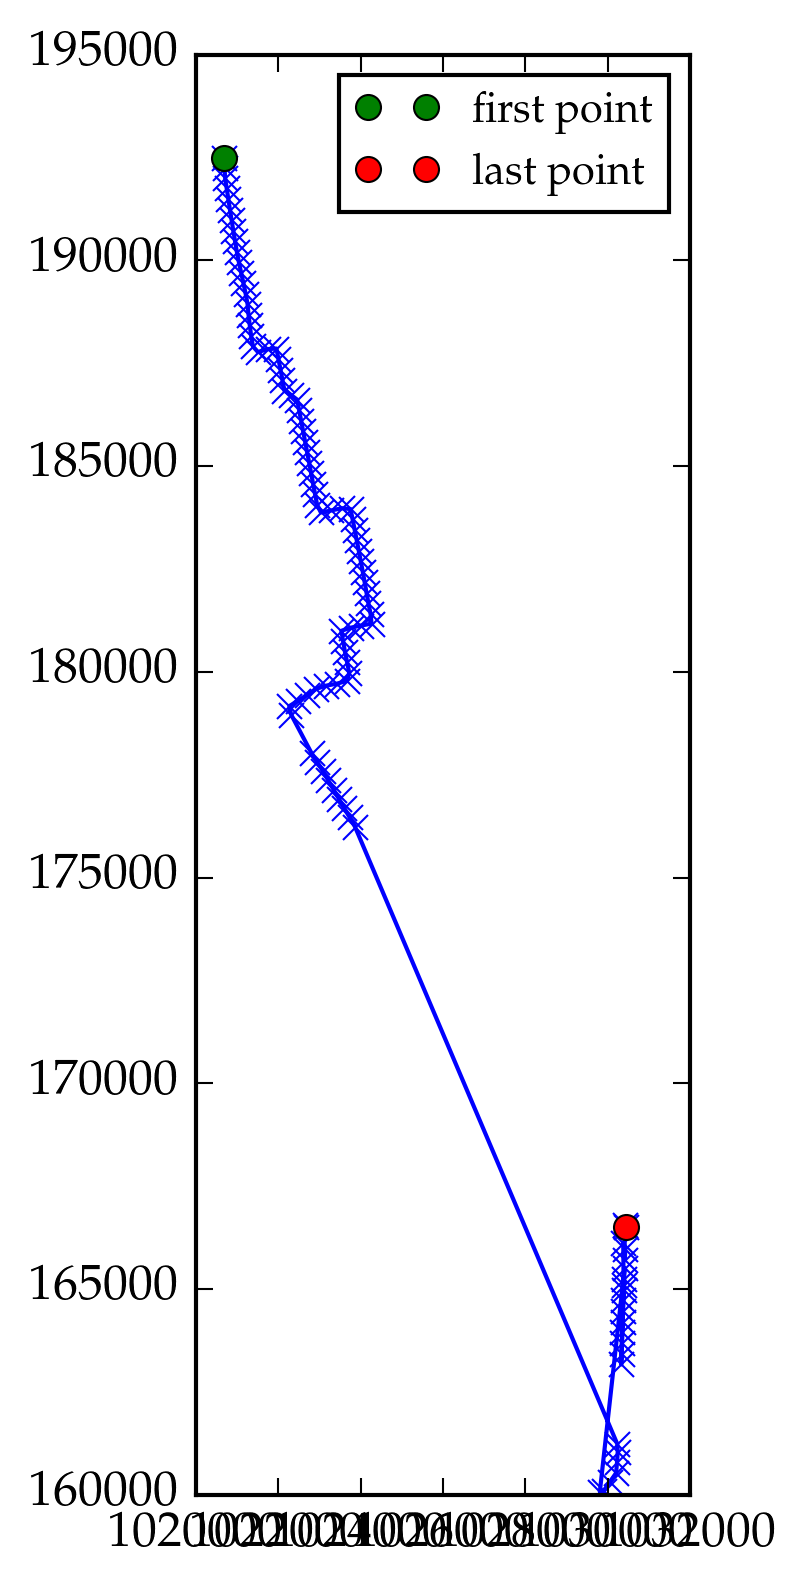

In [120]:
begin
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    plt.plot(X◫[1,:], X◫[2,:], "-x")
    plt.plot(X◫[1,1], X◫[2,1], "o", color="green", label="first point")
    plt.plot(X◫[1,end], X◫[2,end], "o", color="red", label="last point")
    plt.legend(loc="best", fontsize="small")
    plt.gca()[:set_aspect]("equal")
end

## Cliff face

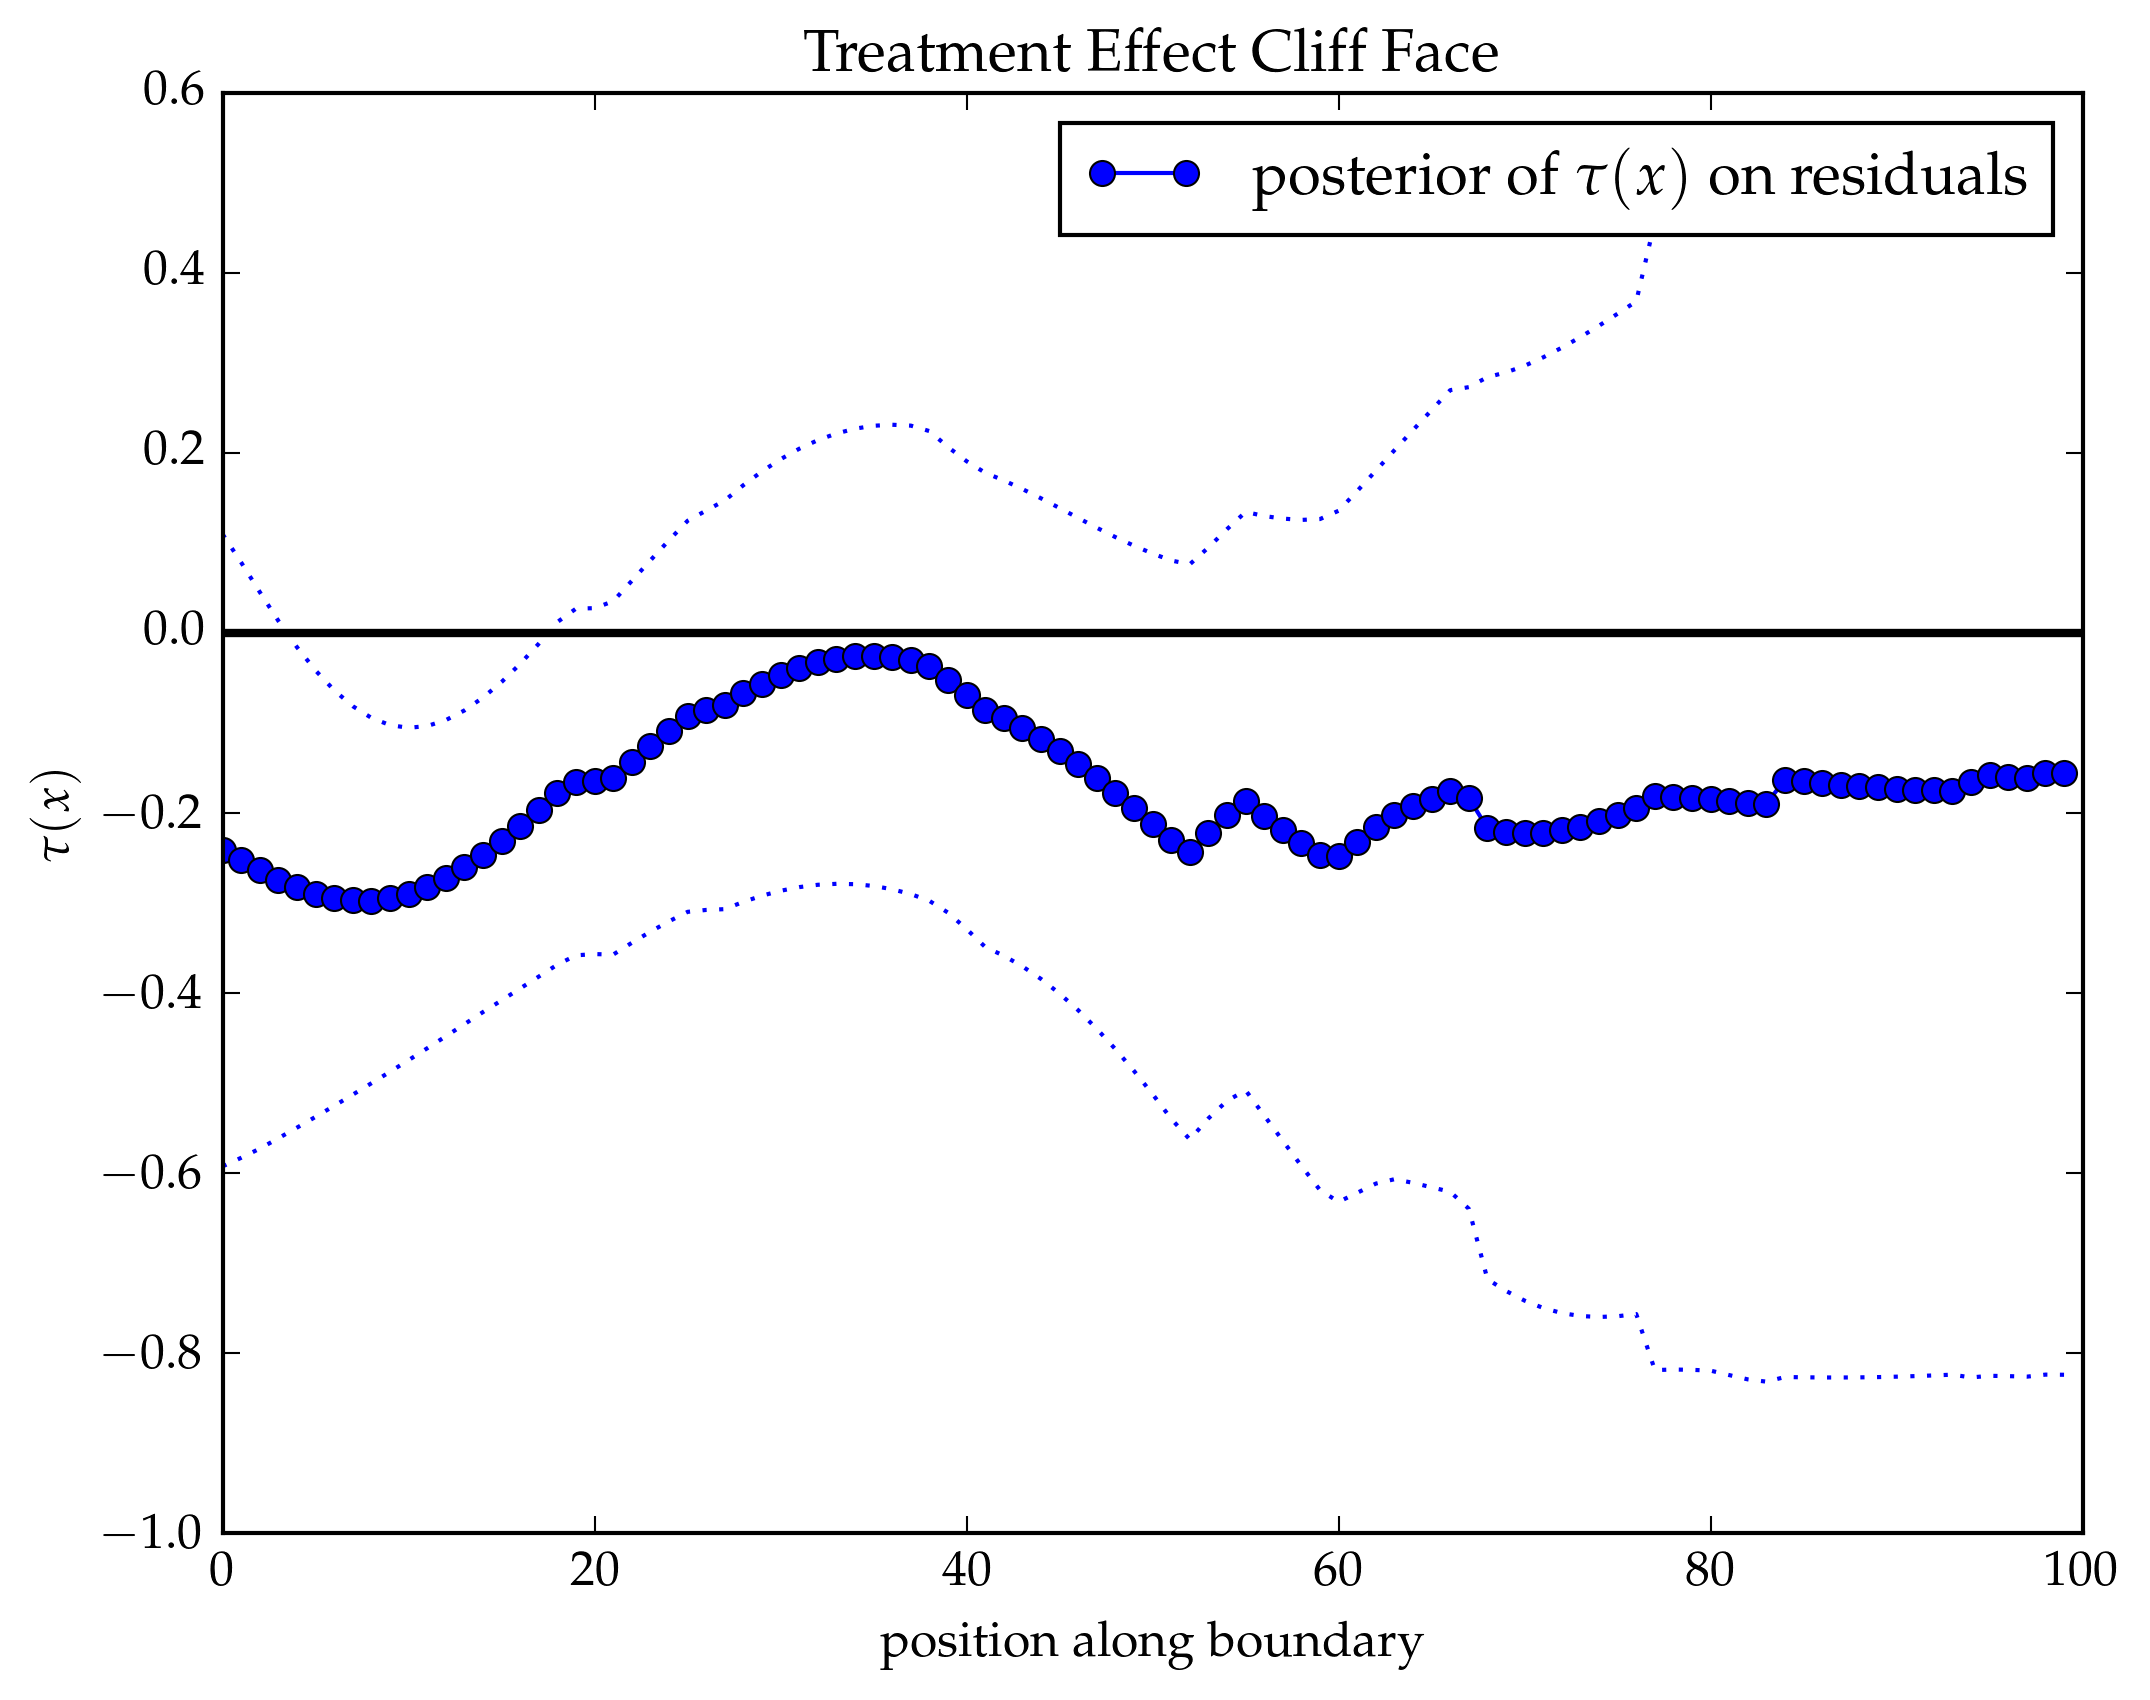

In [121]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+2*√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-2*√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

The following plot just shows the posterior standard deviation against the latitude of the sentinel points (the Northmost sentinel point is on the right of this plot, so it's horizontally flipped from the cliff face plot above). We see that the standard deviation is lowest in the most densely populated part of the boundary, and very high on the island.

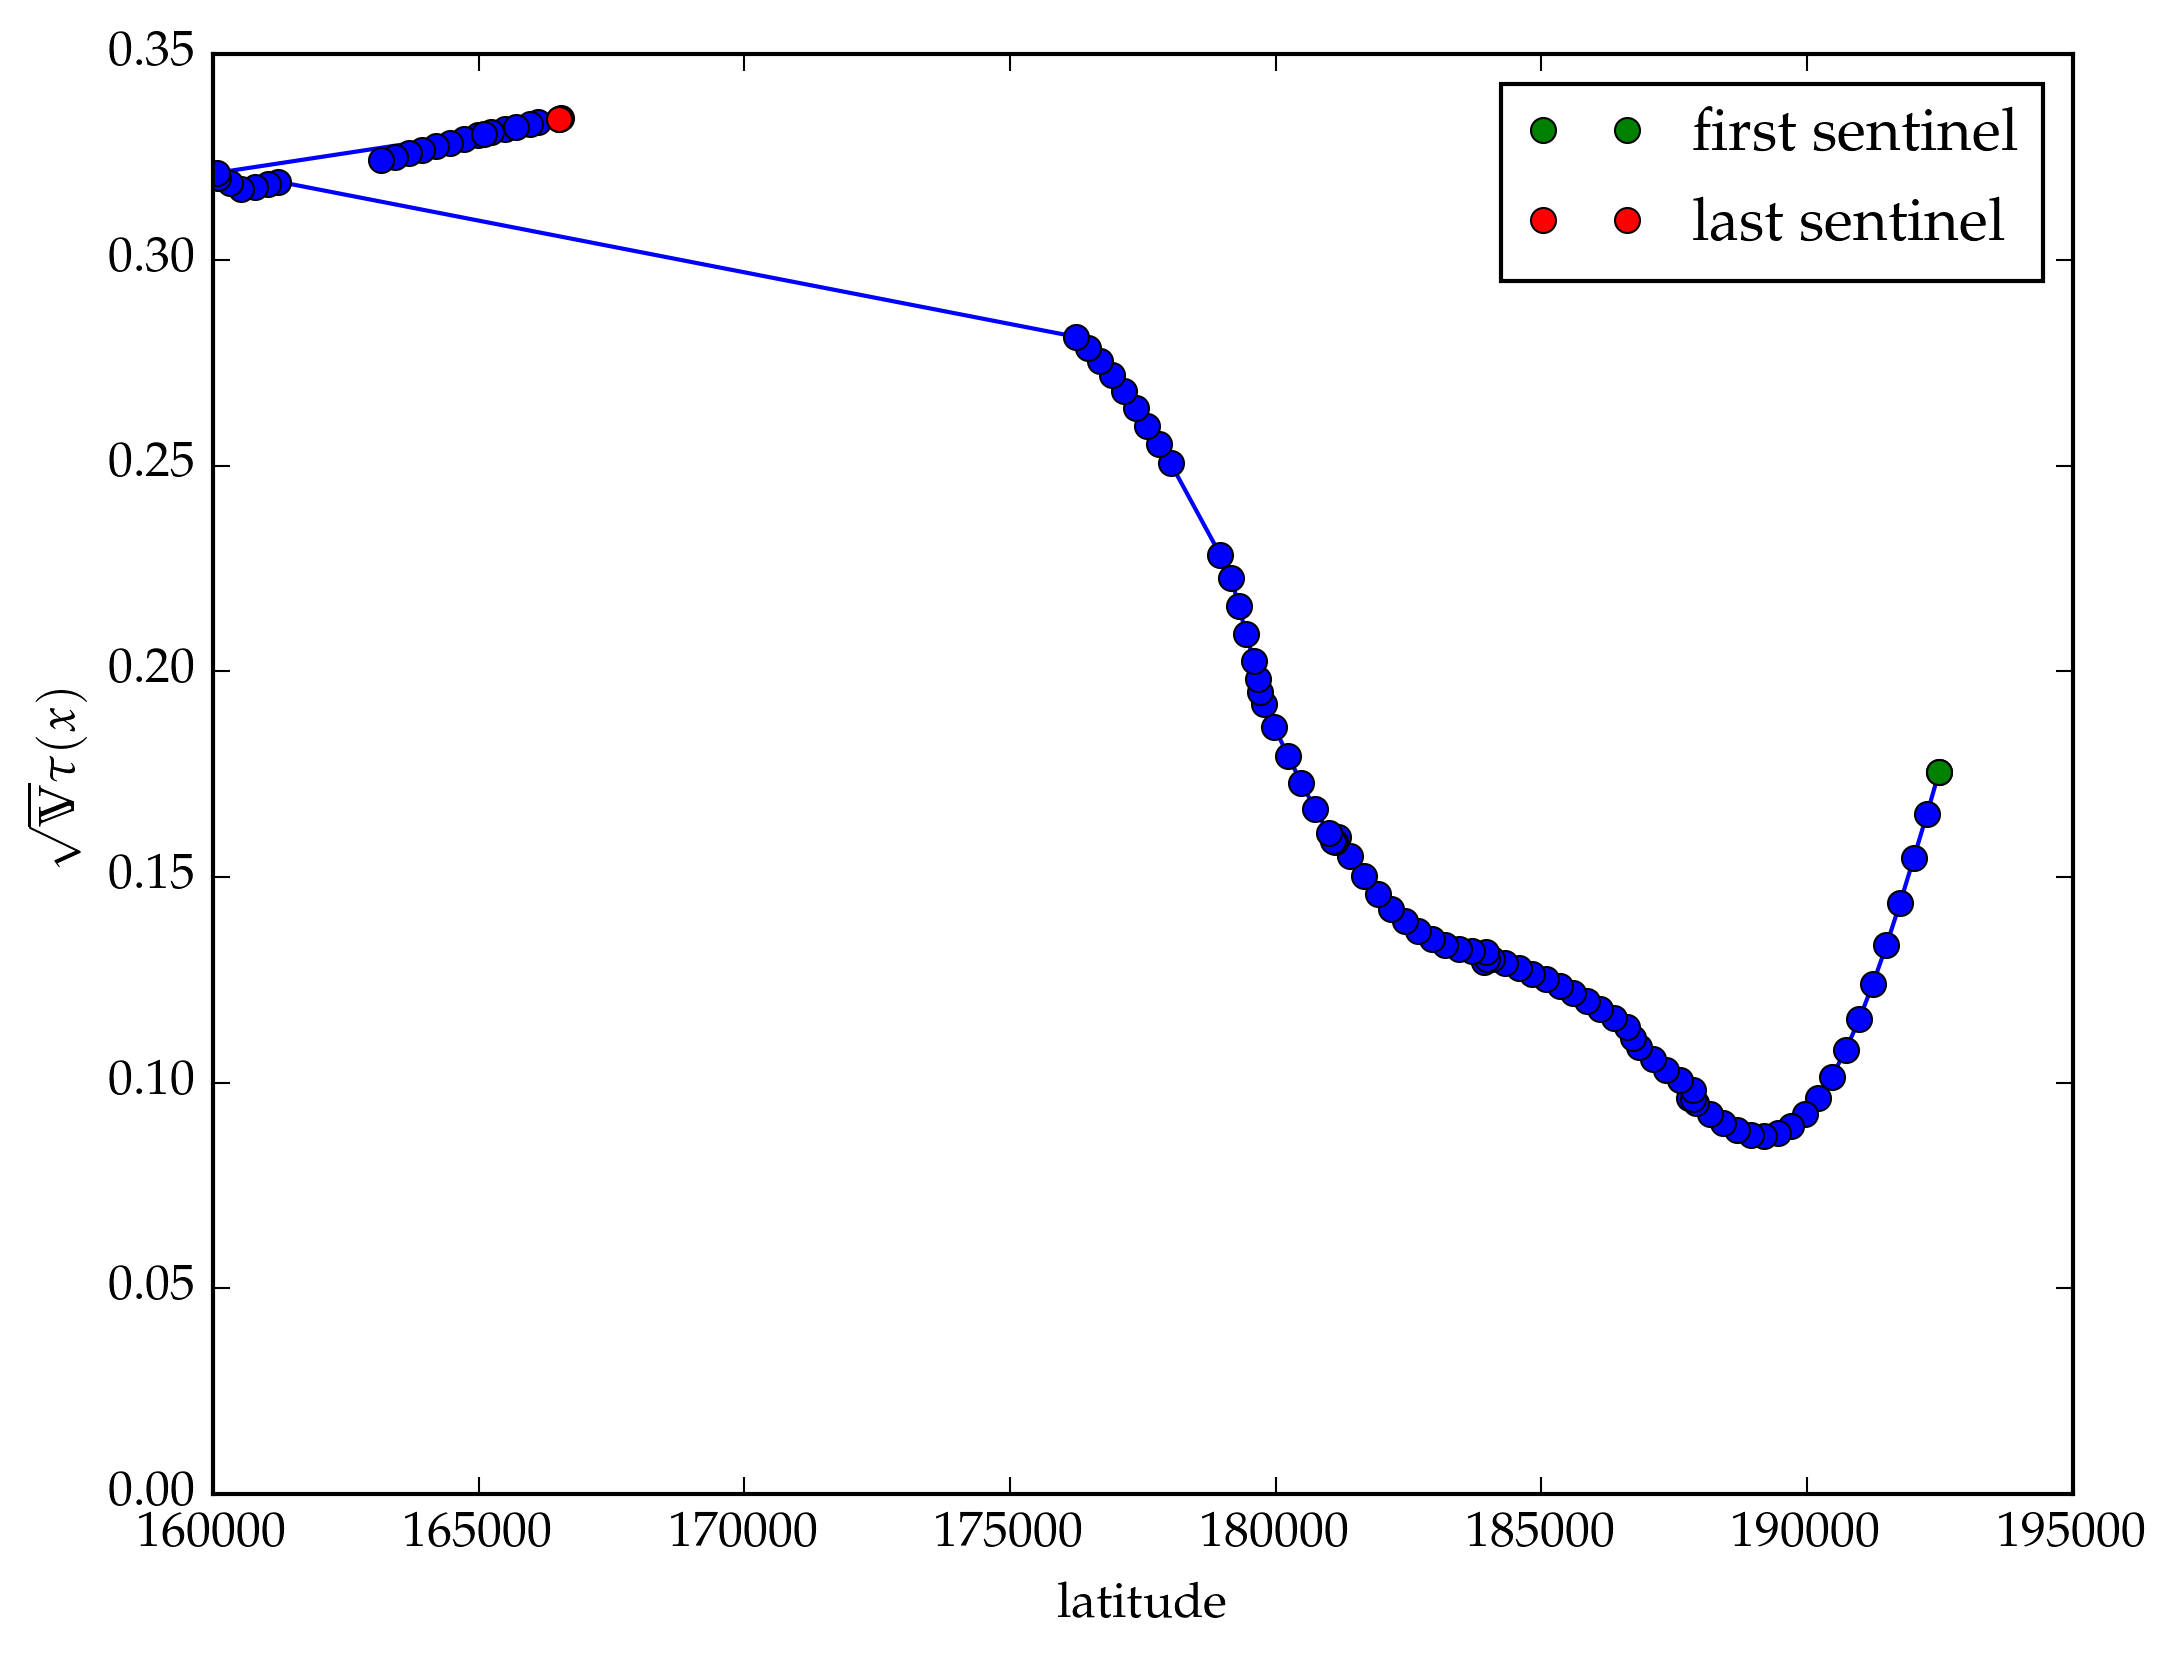

PyObject <matplotlib.legend.Legend object at 0x3270e3810>

In [122]:
begin
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    plt.plot(X◫[2,:], √diag(resid_Σposterior), "-o")
    plt.plot(X◫[2,1], √diag(resid_Σposterior)[1], color="green", "o", label="first sentinel")
    plt.plot(X◫[2,end], √diag(resid_Σposterior)[end], color="red", "o", label="last sentinel")
    plt.ylim(0)
    plt.xlabel("latitude")
    plt.ylabel(L"\sqrt\mathbb{V}\tau(x)")
    plt.legend(loc="best")
end

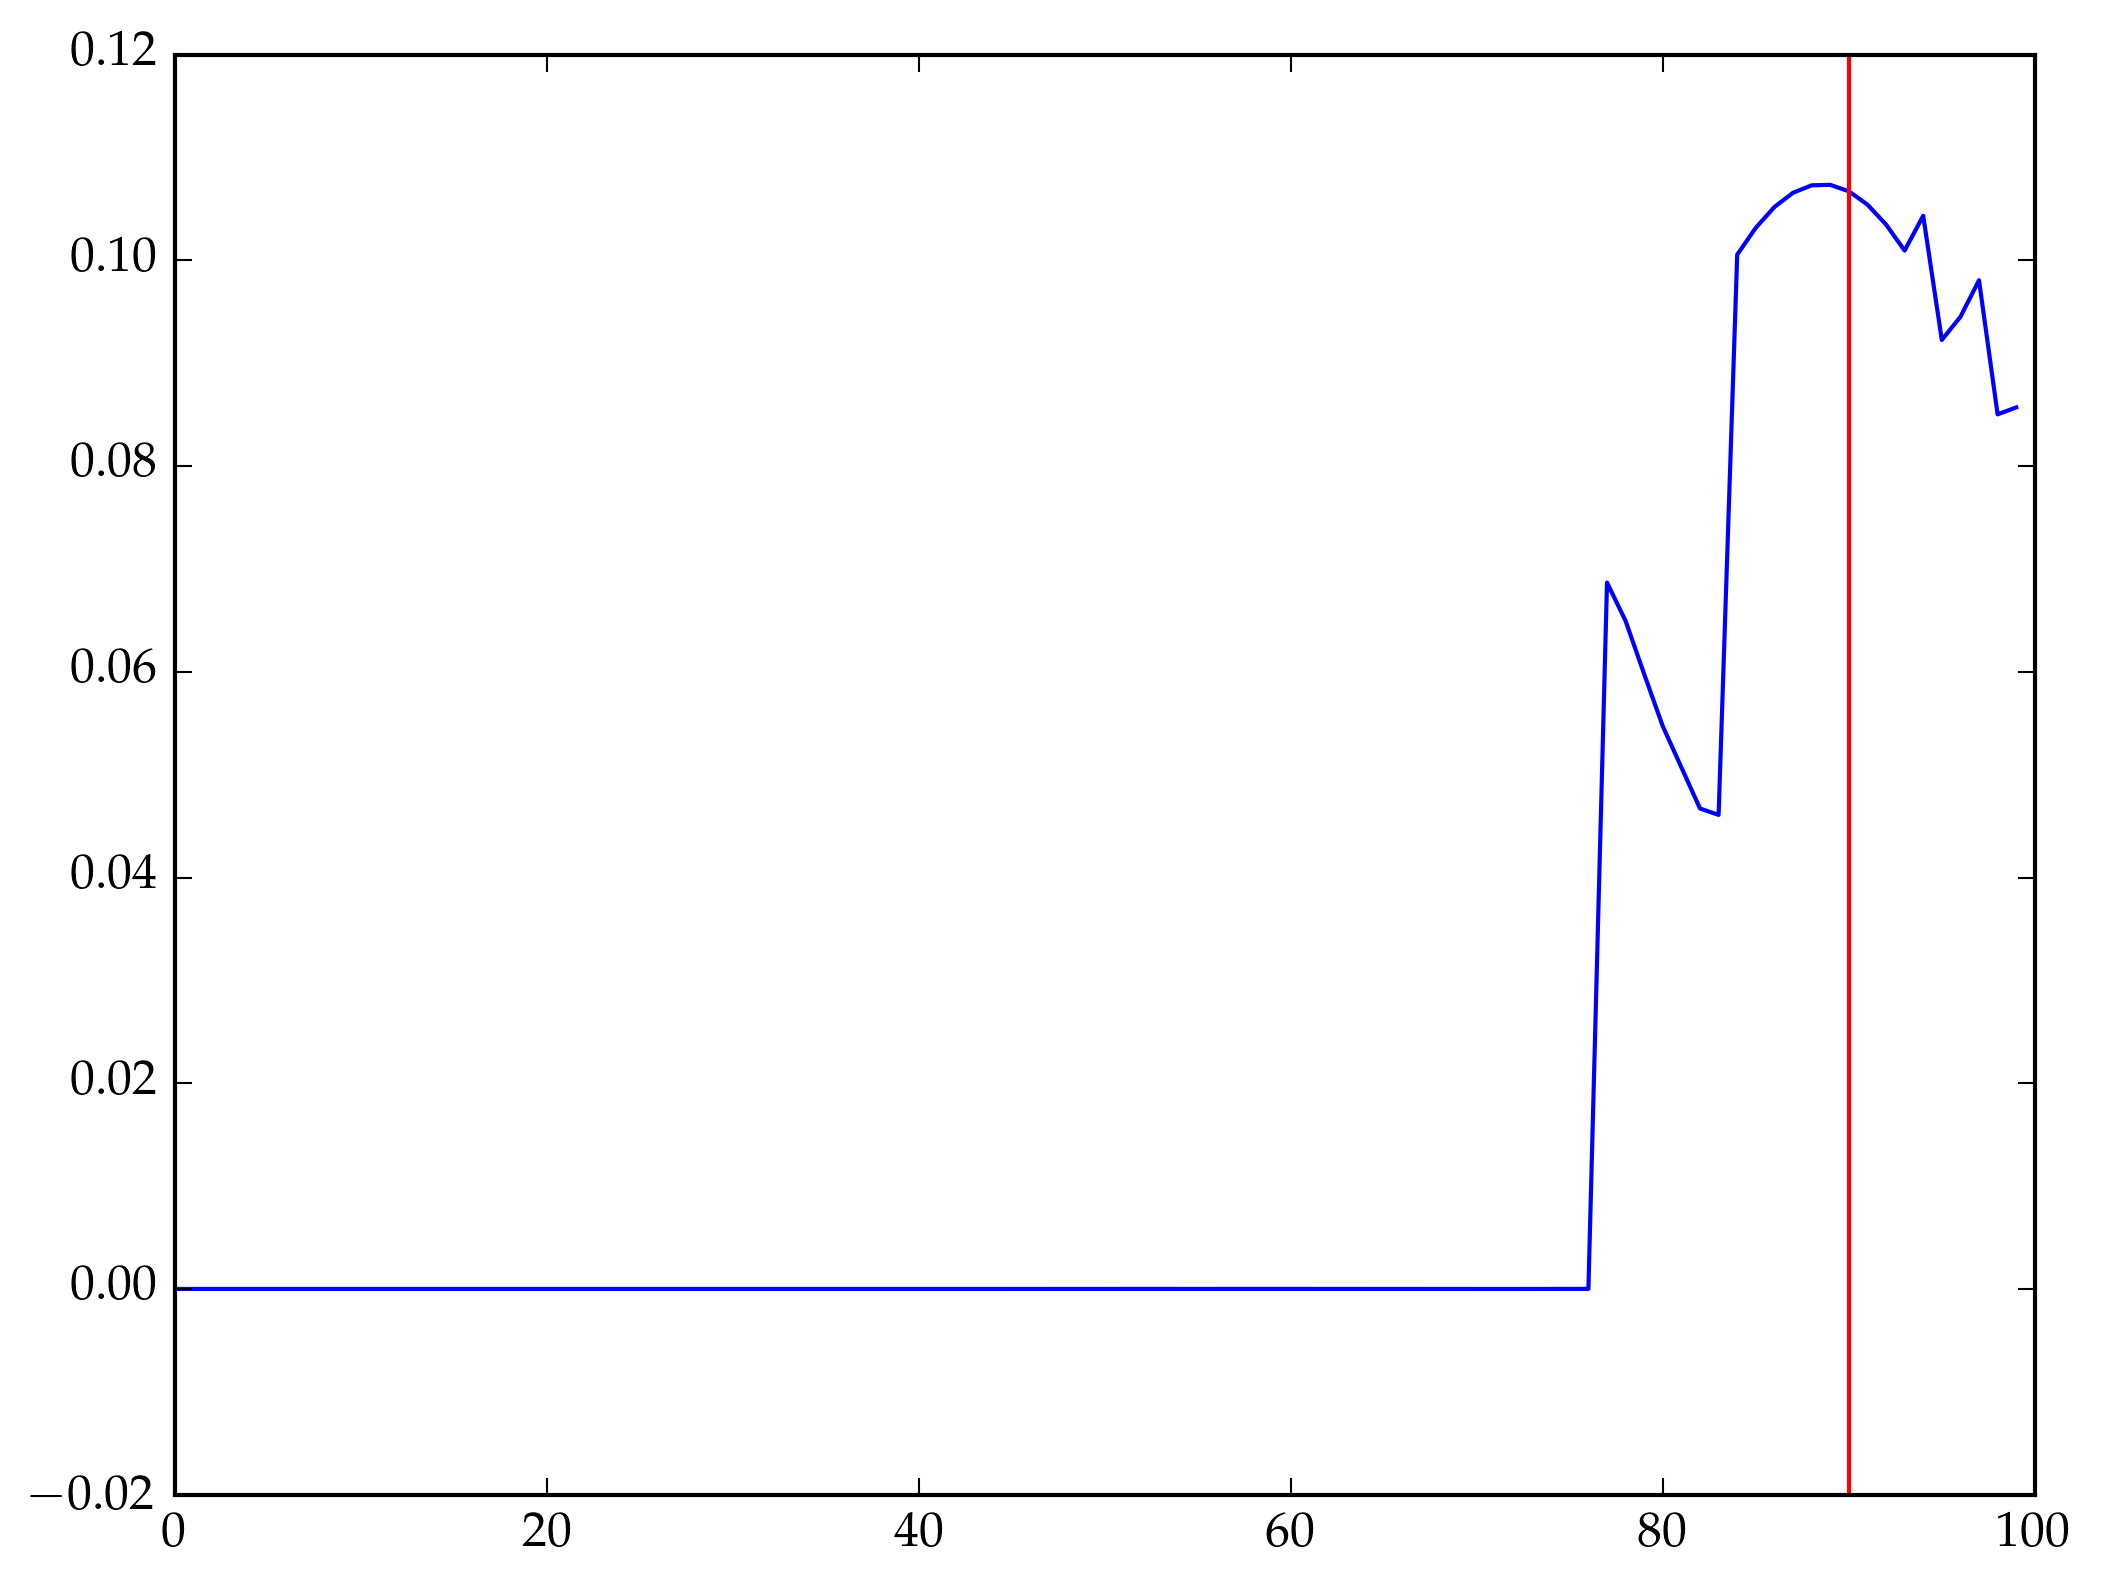

PyObject <matplotlib.lines.Line2D object at 0x3869b1d90>

In [123]:
plt.plot(resid_Σposterior.mat[end-10,:])
plt.axvline(size(resid_Σposterior,1)-10, color="red")

### Cliff face parametric bootstrap

In [124]:
@time boot_cliffs = GeoRDD.nsim_cliff(resid_GP_dict[distrA], 
                                      resid_GP_dict[distrB], 
                                      hcat(sentinels[distrA,distrB].coordinates...), 
                                      100; 
                                      update_mean=true);

  4.951261 seconds (1.01 M allocations: 1.029 GB, 8.38% gc time)


In [125]:
chi_indep = mean(resid_μposterior.^2 ./ diag(resid_Σposterior))

1.8341302023673212

In [126]:
boot_chi_indep = [mean(boot_cliffs[j][1].^2 ./ diag(boot_cliffs[j][2])) for j in 1:length(boot_cliffs)];

In [127]:
mean(boot_chi_indep .> chi_indep)

0.03

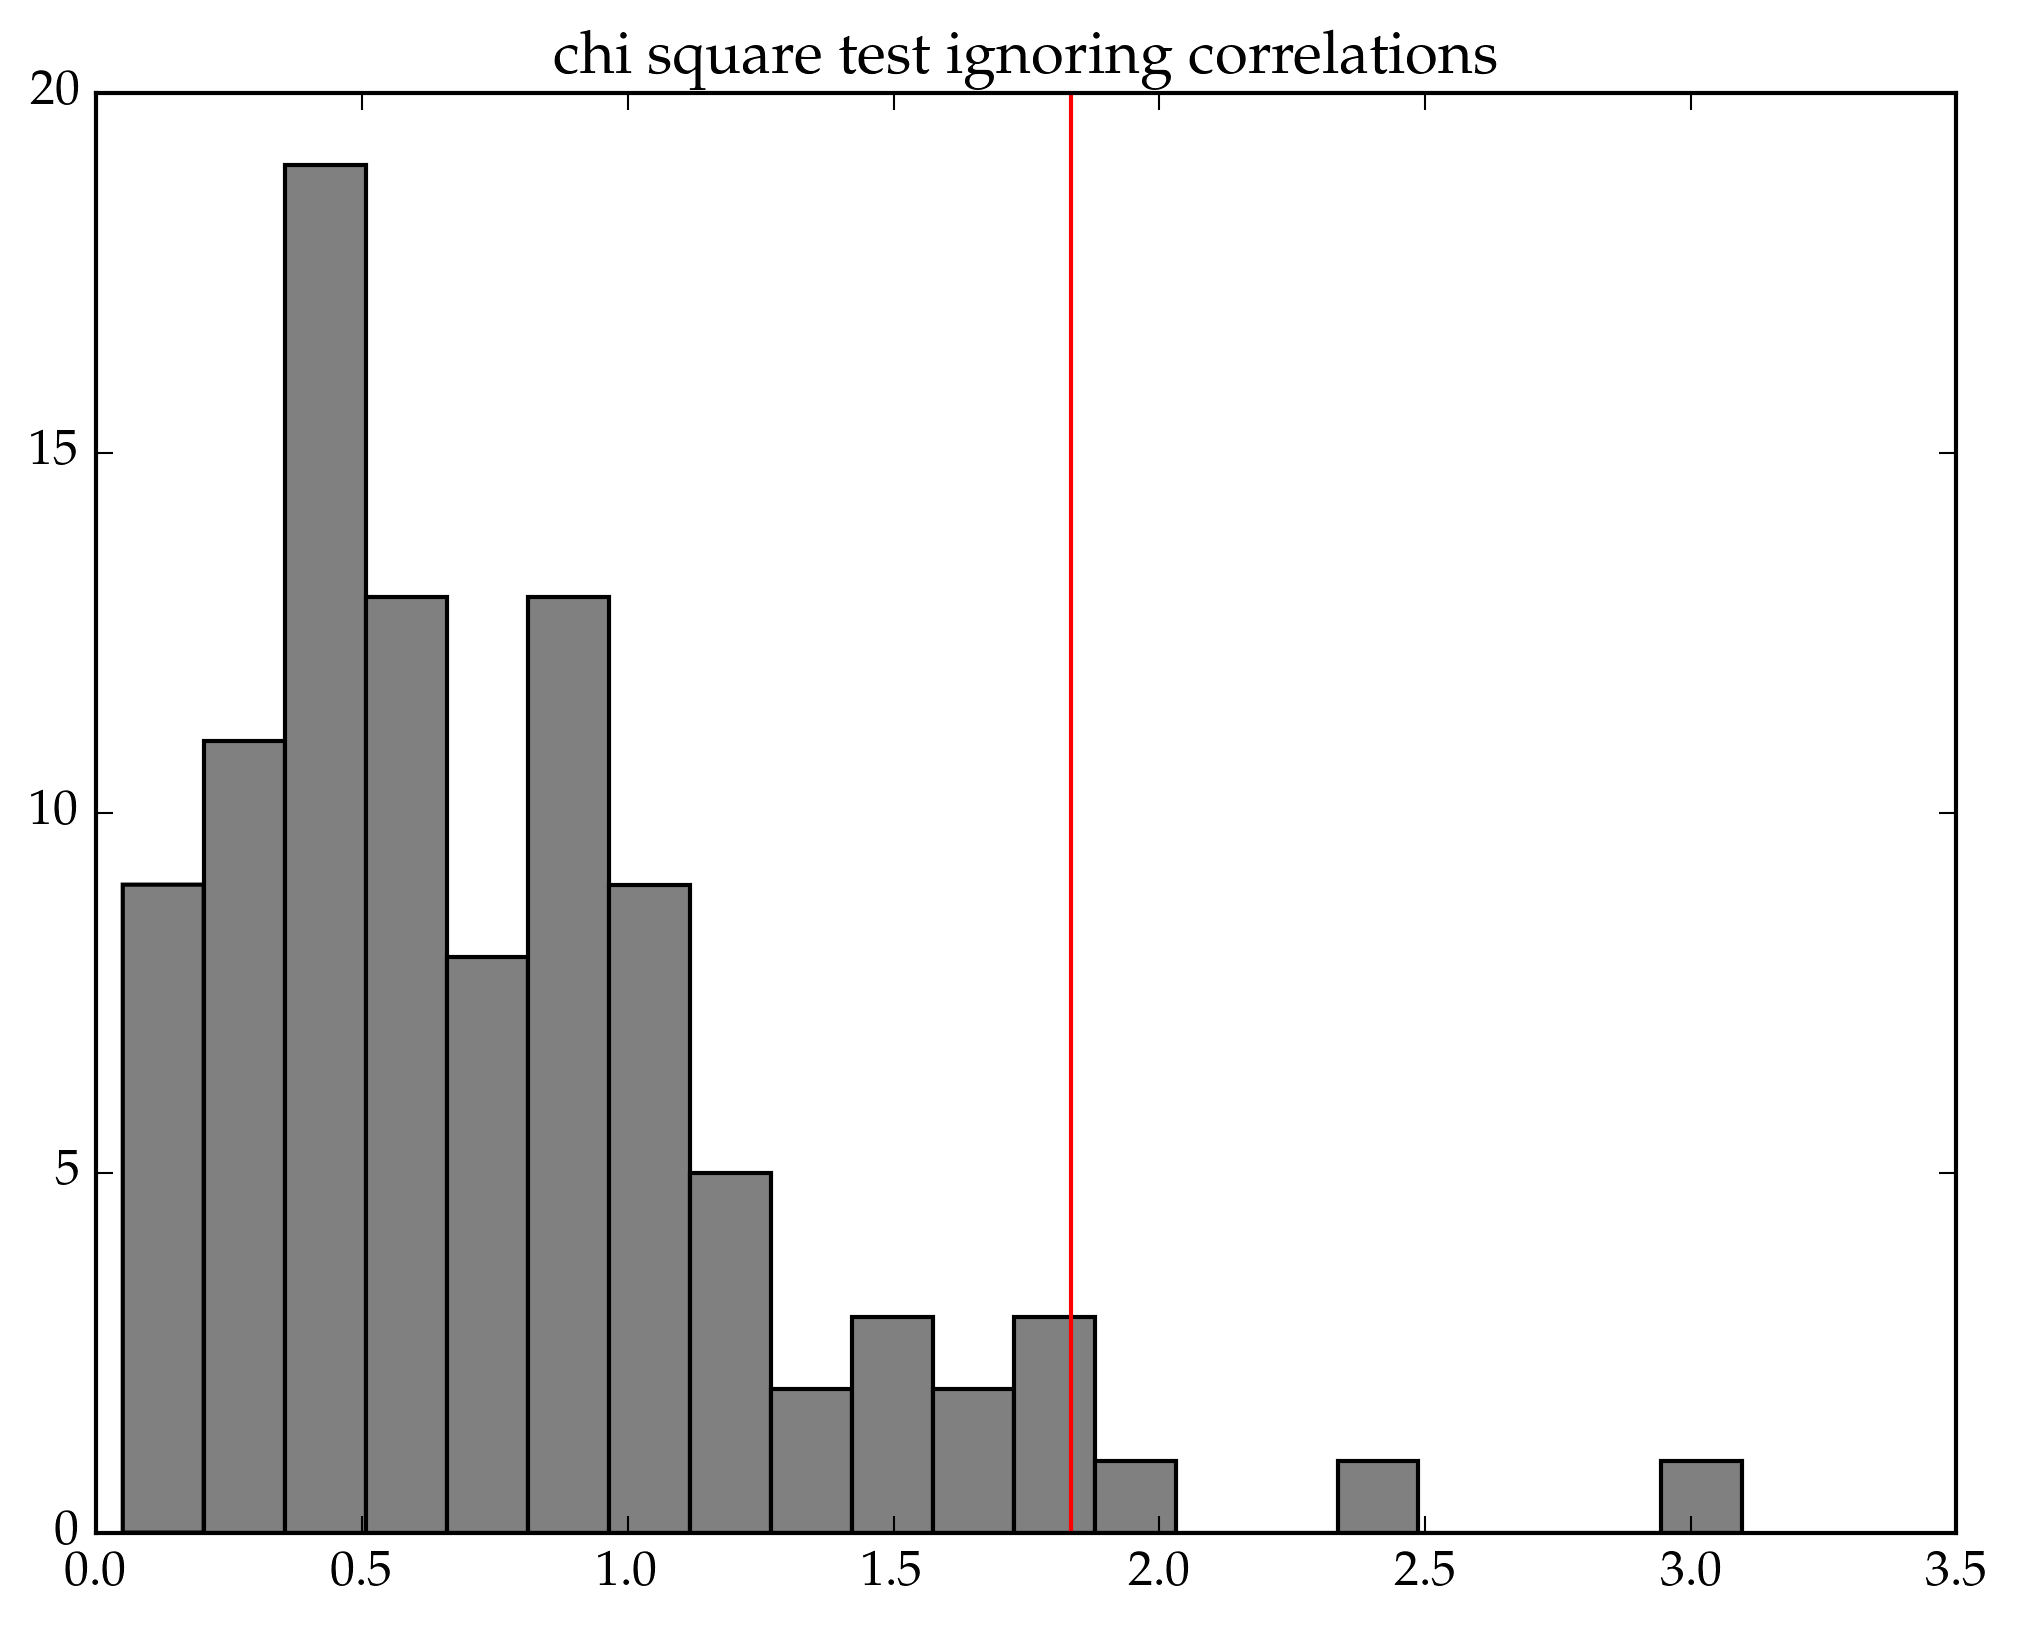

In [128]:
plt.plt[:hist](boot_chi_indep, color="grey", bins=20)
plt.axvline(chi_indep, color="red")
plt.title("chi square test ignoring correlations")
;

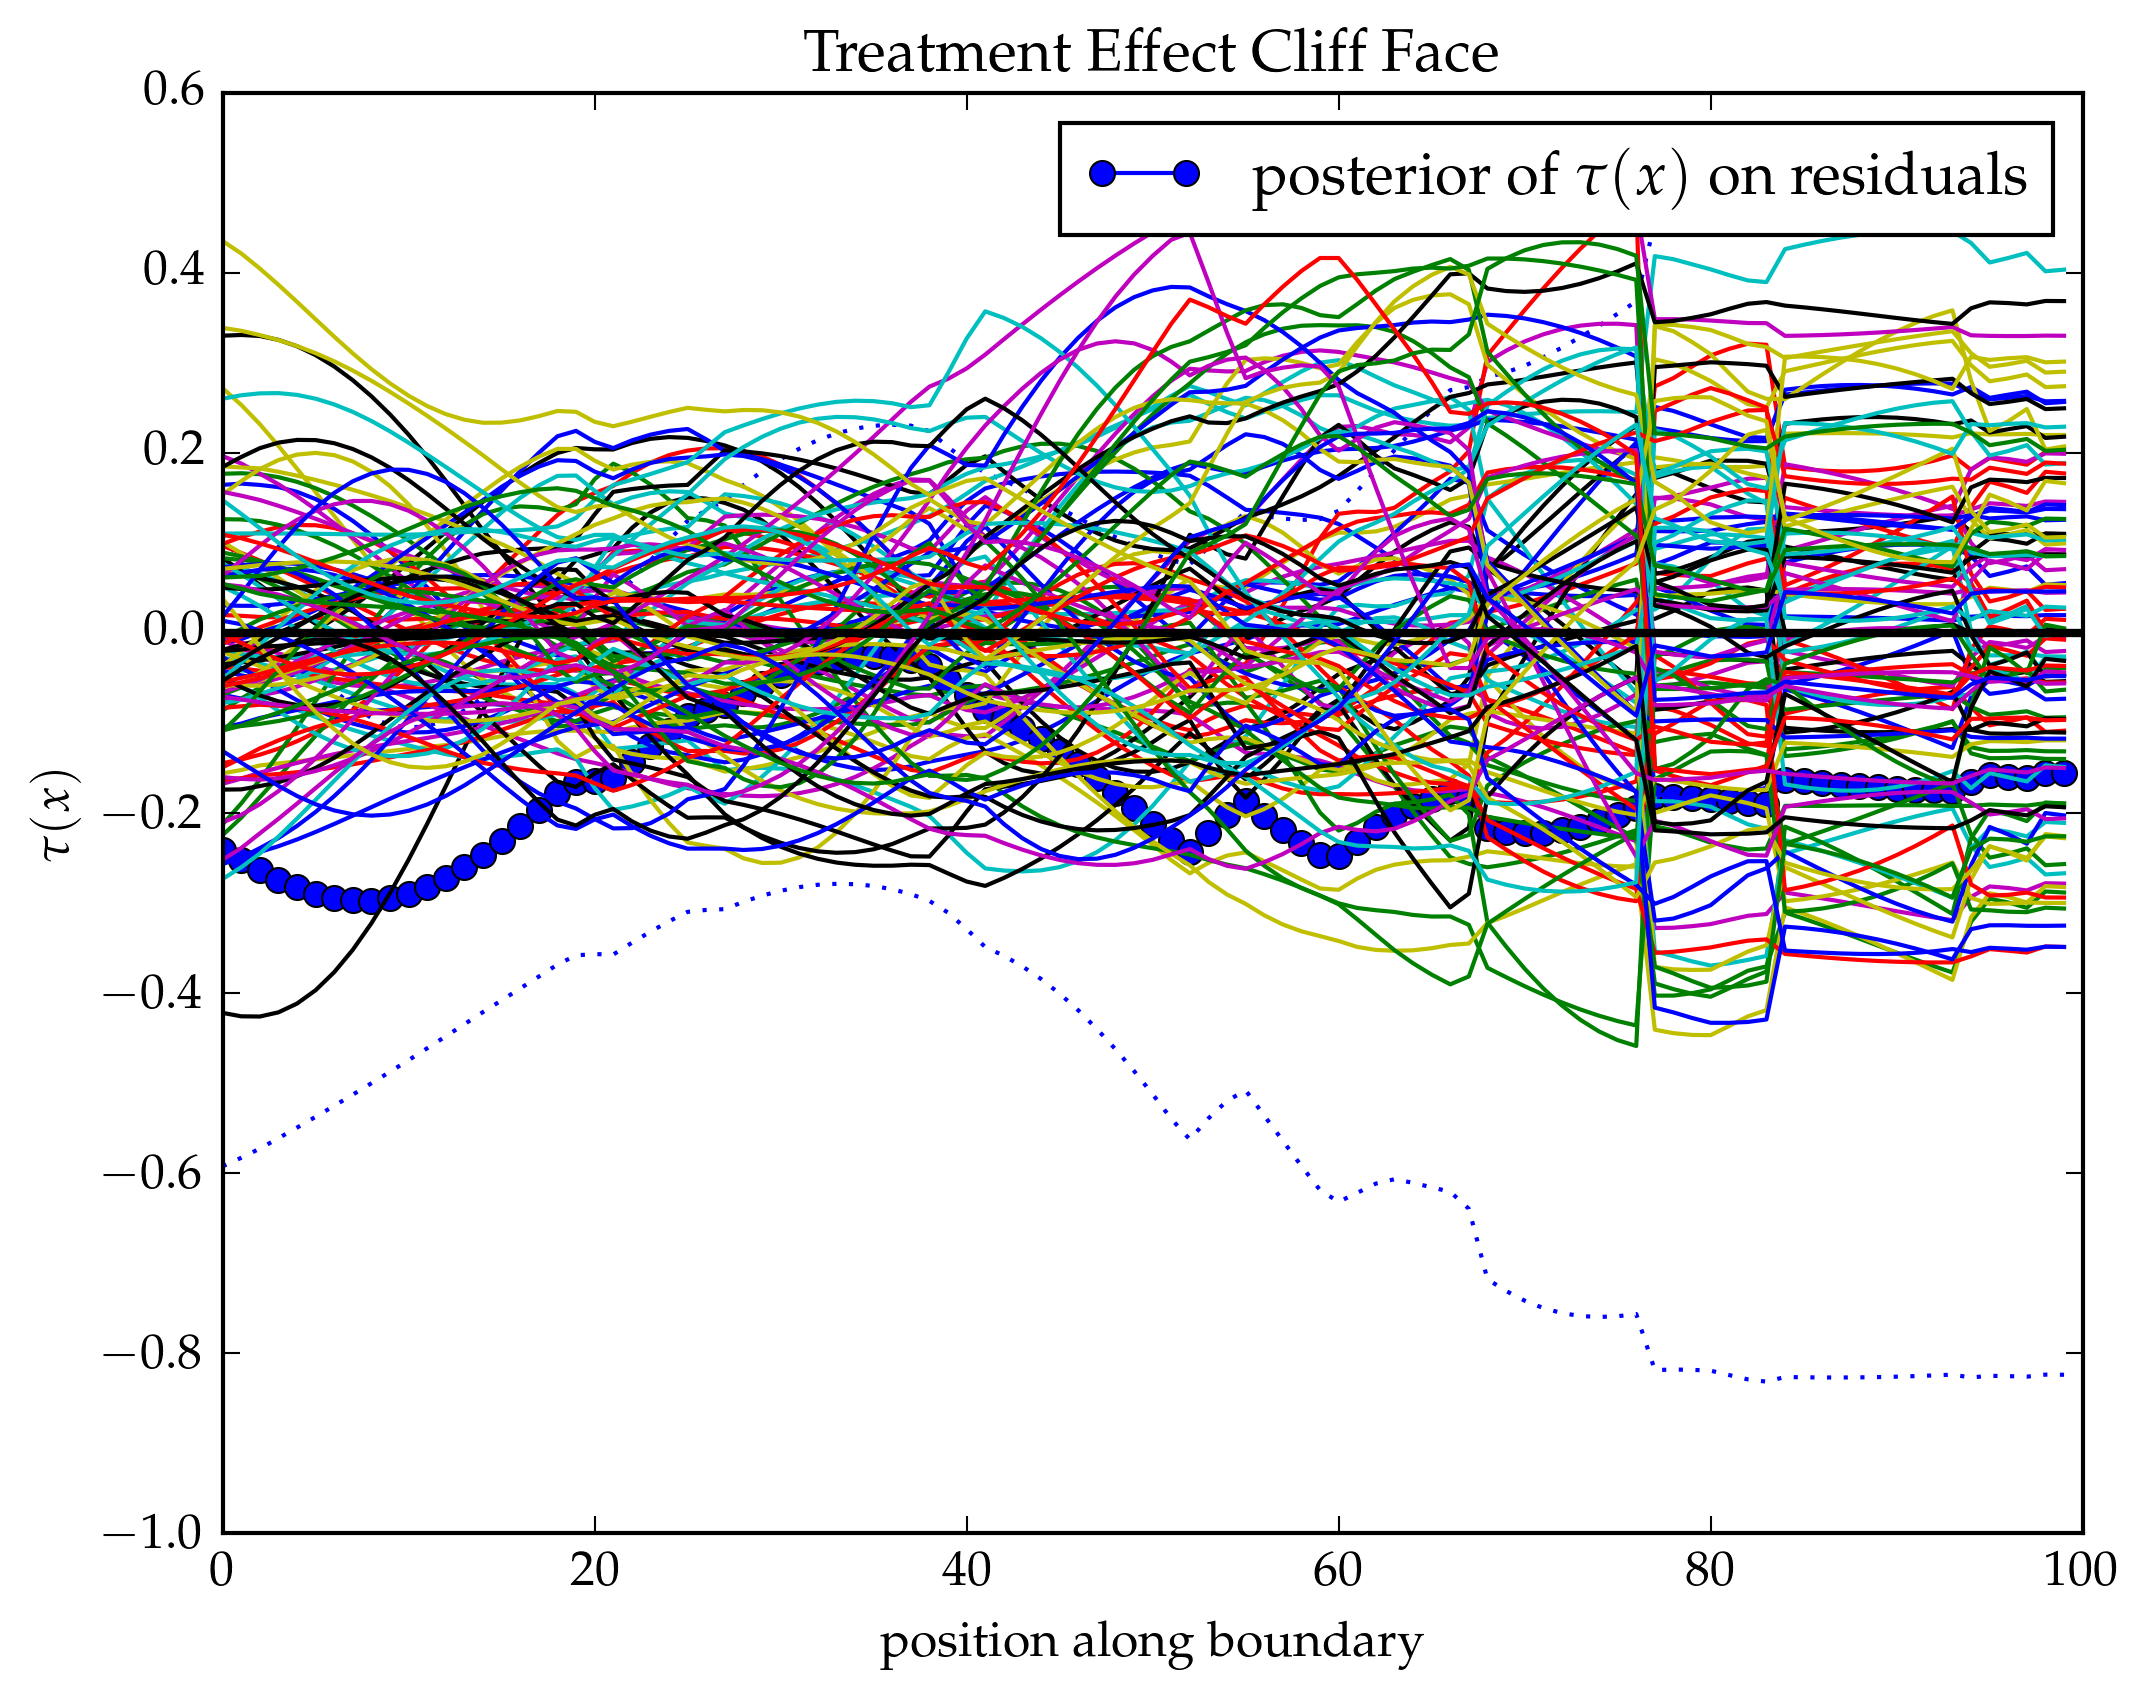

In [129]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+2*√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-2*√diag(resid_Σposterior), color="blue", linestyle=":")
for j in 1:length(boot_cliffs)
    plt.plot(boot_cliffs[j][1], linewidth=1)
end
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

## adding mean kernel

In the 1D simulations, I noticed that adding a constant kernel to account
for uncertainty in the mean could improve coverage significantly.
My intuition is that here we have enough data that the uncertainty
in the mean is very low, but I still want to check that the cliff face isn't
unduly affected by the change.

To be clear, by “constant kernel”, I mean that the kernel $k(\svec, \svec')$ is modified
to $k*$:
$$k*(\svec,\svec') = k(\svec,\svec') + \sigma_\mu^2$$

In [130]:
wmean_GP_dict=Dict{String, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), k_wmean, gp_mean.logNoise)
    wmean_GP_dict[name] = fit
end

In [131]:
wmean_μposterior, wmean_Σposterior = GeoRDD.cliff_face(
            wmean_GP_dict[distrA], 
            wmean_GP_dict[distrB],
            hcat(sentinels[distrA,distrB].coordinates...))
;

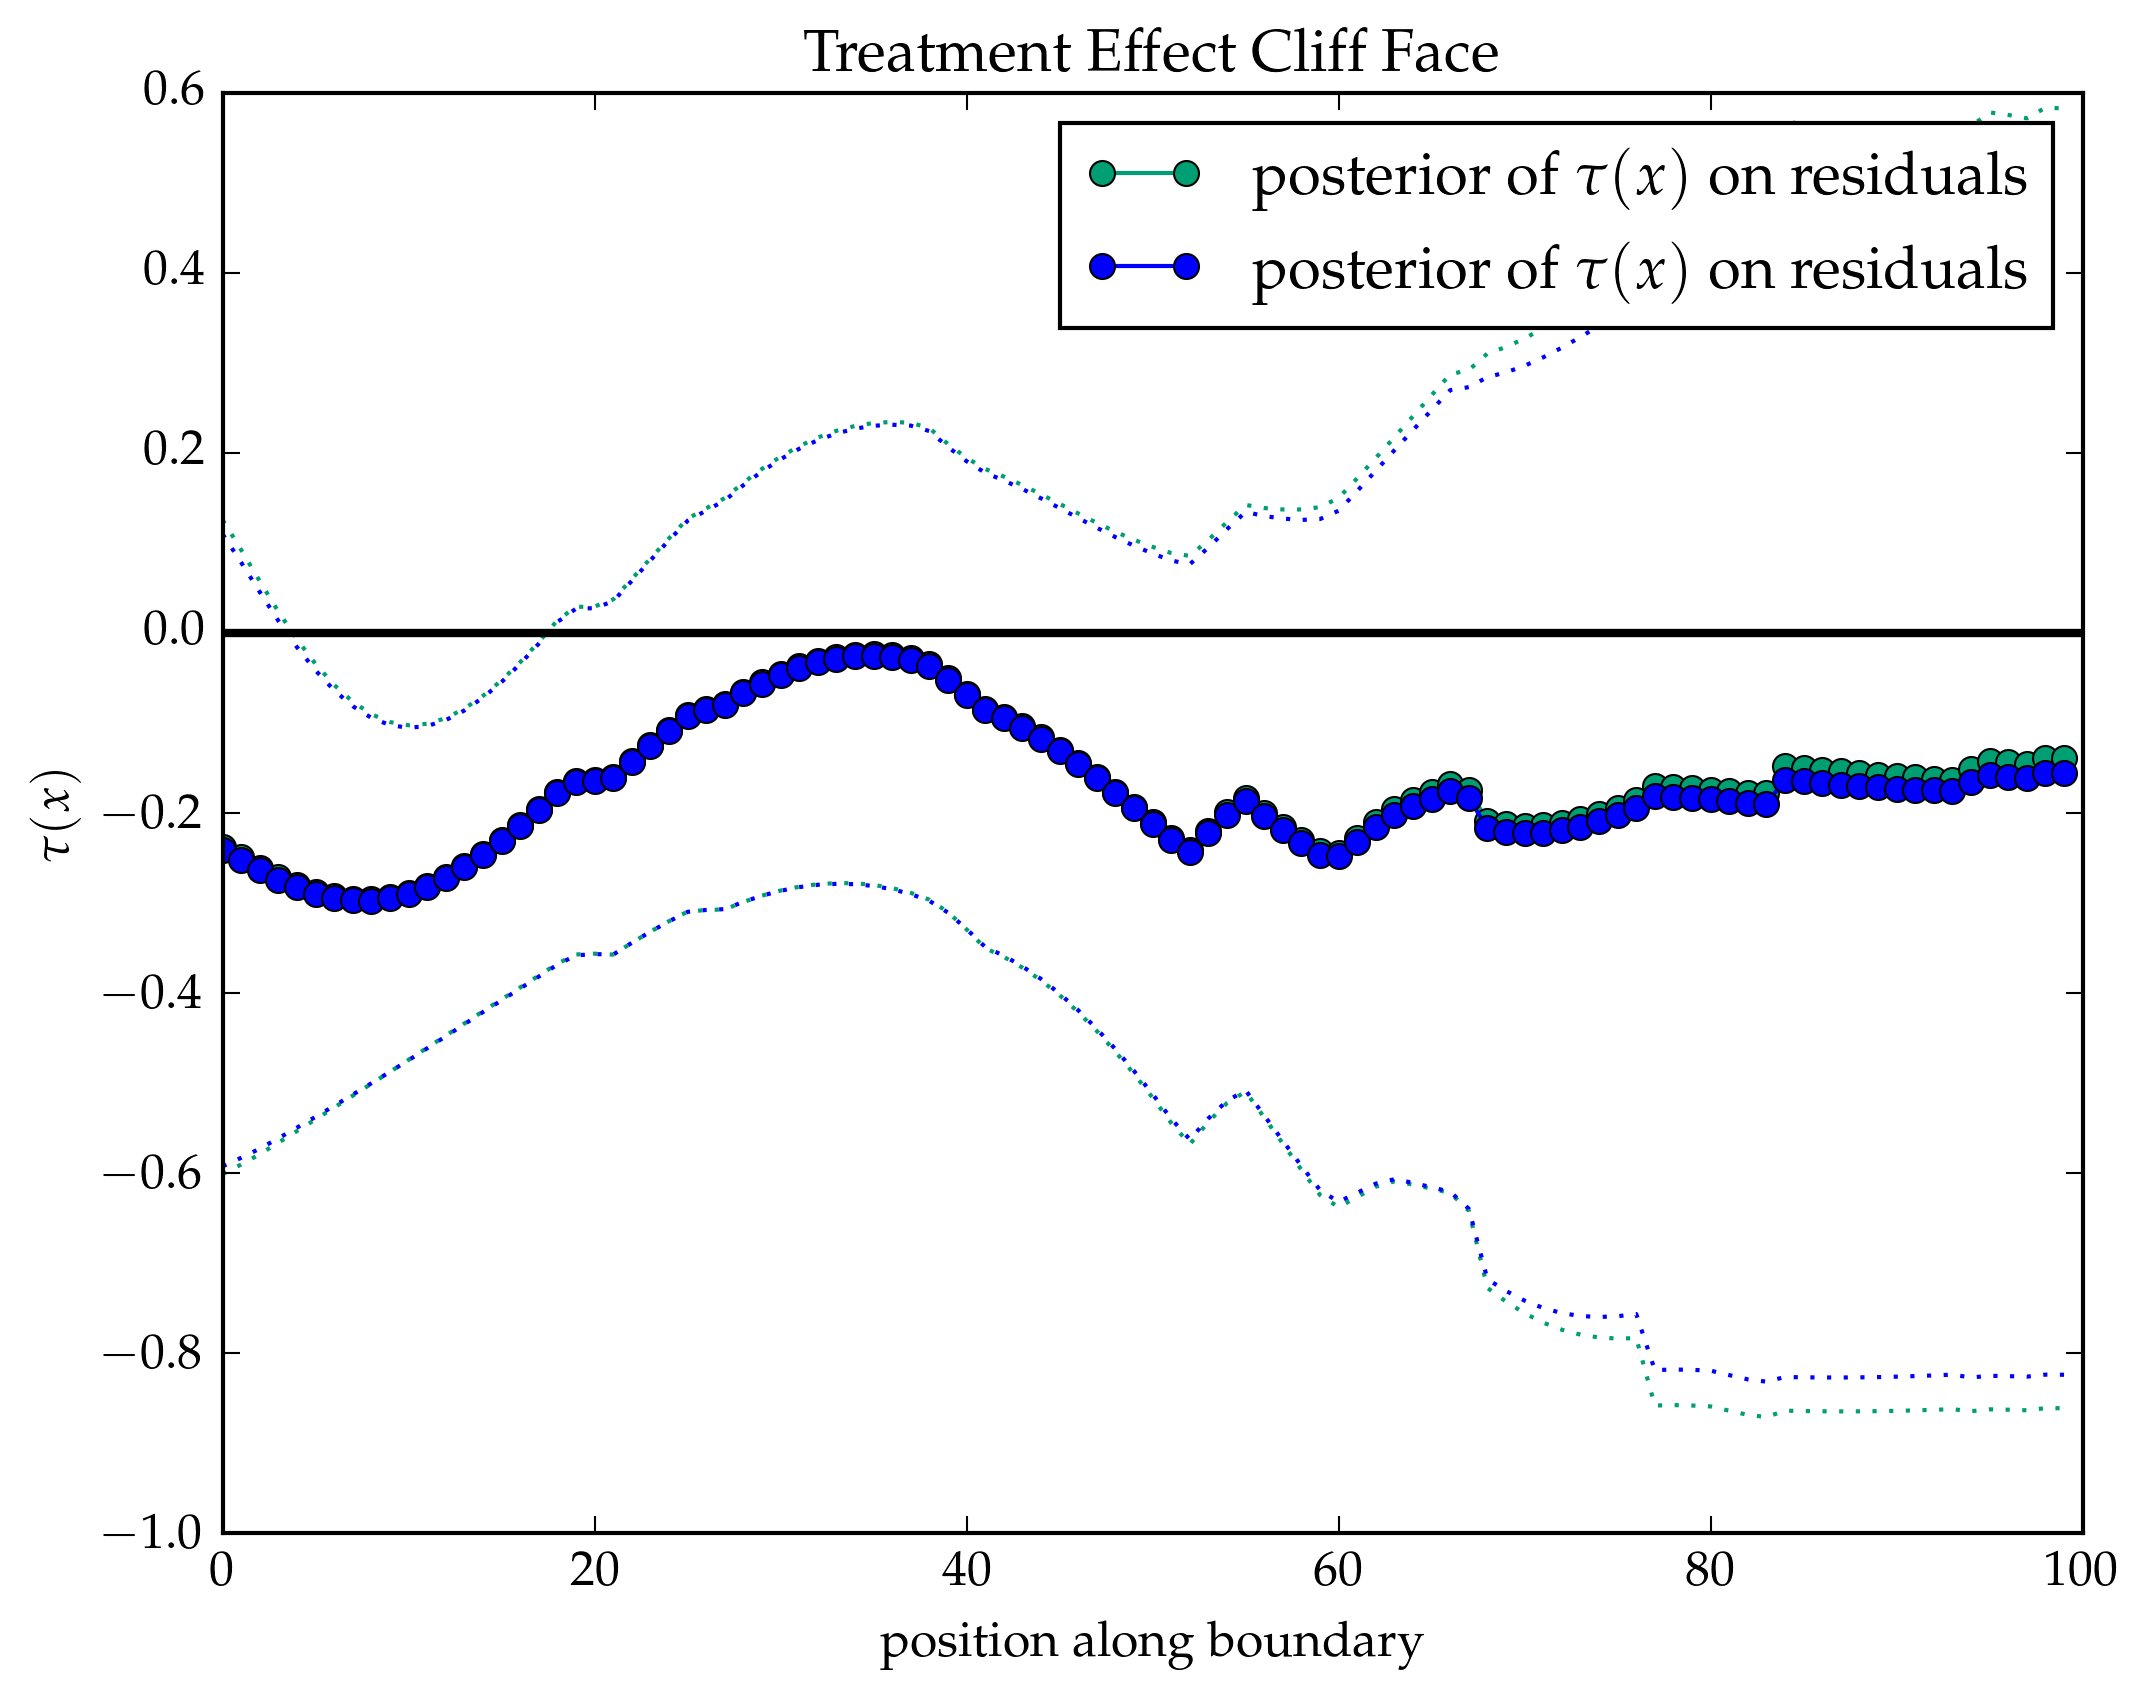

In [132]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(wmean_μposterior, color="#009E73", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(wmean_μposterior.+2*√diag(wmean_Σposterior), color="#009E73", linestyle=":")
plt.plot(wmean_μposterior.-2*√diag(wmean_Σposterior), color="#009E73", linestyle=":")
plt.plot(resid_μposterior, color="blue", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+2*√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-2*√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

It's reassuring that it made virtually no difference in this case. It means we can continue to ignore the uncertainty in the mean.

In [136]:
τpost=GeoRDD.inverse_variance(wmean_μposterior, wmean_Σposterior)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

τ|Y ∼ Normal(μ=-0.191, σ=0.066)
P(τ>0|Y) = 0.179%

## Unweighted mean treatment effect

In [137]:
τpost=GeoRDD.unweighted_mean(resid_μposterior, resid_Σposterior)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

τ|Y ∼ Normal(μ=-0.175, σ=0.090)
P(τ>0|Y) = 2.601%

## Inverse-variance treatment effect

The inverse-variance treatment effect is very strong, we get:
\begin{align}
    \tau &\mid Y \sim \normal\del{\mu=0.178, \sigma=0.051} \\
    \Pr\del{\tau>0 \mid Y} &= 99.979%\%
\end{align}

In [138]:
τpost=GeoRDD.inverse_variance(resid_μposterior, resid_Σposterior)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

τ|Y ∼ Normal(μ=-0.193, σ=0.059)
P(τ>0|Y) = 0.056%

## Chi-squared test

In [148]:
function get_pval(μ::Vector{Float64}, Σ::Matrix{Float64}, ϵ::Float64; verbose=false)
    Σsvd = svdfact(Σ)
    λvec = Σsvd[:S] # sorted in decreasing order
    aboveϵ = (λvec ./ sum(λvec)) .> ϵ
    ν = max(sum(aboveϵ),1)
    Sabove = Σsvd[:S][aboveϵ]
    Σsvd[:S][:] = 1./Σsvd[:S] # invert high eigenvalues
    Σsvd[:S][!aboveϵ] = 0.0 # but remove low eigenvalues
    t = dot(μ, (full(Σsvd) * μ))
    if verbose
        println("t: ", t)
        println("ν: ", ν)
    end
    nullhypo = Chisq(ν)
    pval = ccdf(nullhypo, t)
    return pval
end

get_pval (generic function with 1 method)

In [149]:
dot(resid_μposterior, resid_Σposterior \ resid_μposterior)

16.879424955399514

In [150]:
get_pval(resid_μposterior, full(resid_Σposterior), 0.01; verbose=true)

t: 13.585133473105701
ν: 9


0.13786700486000159

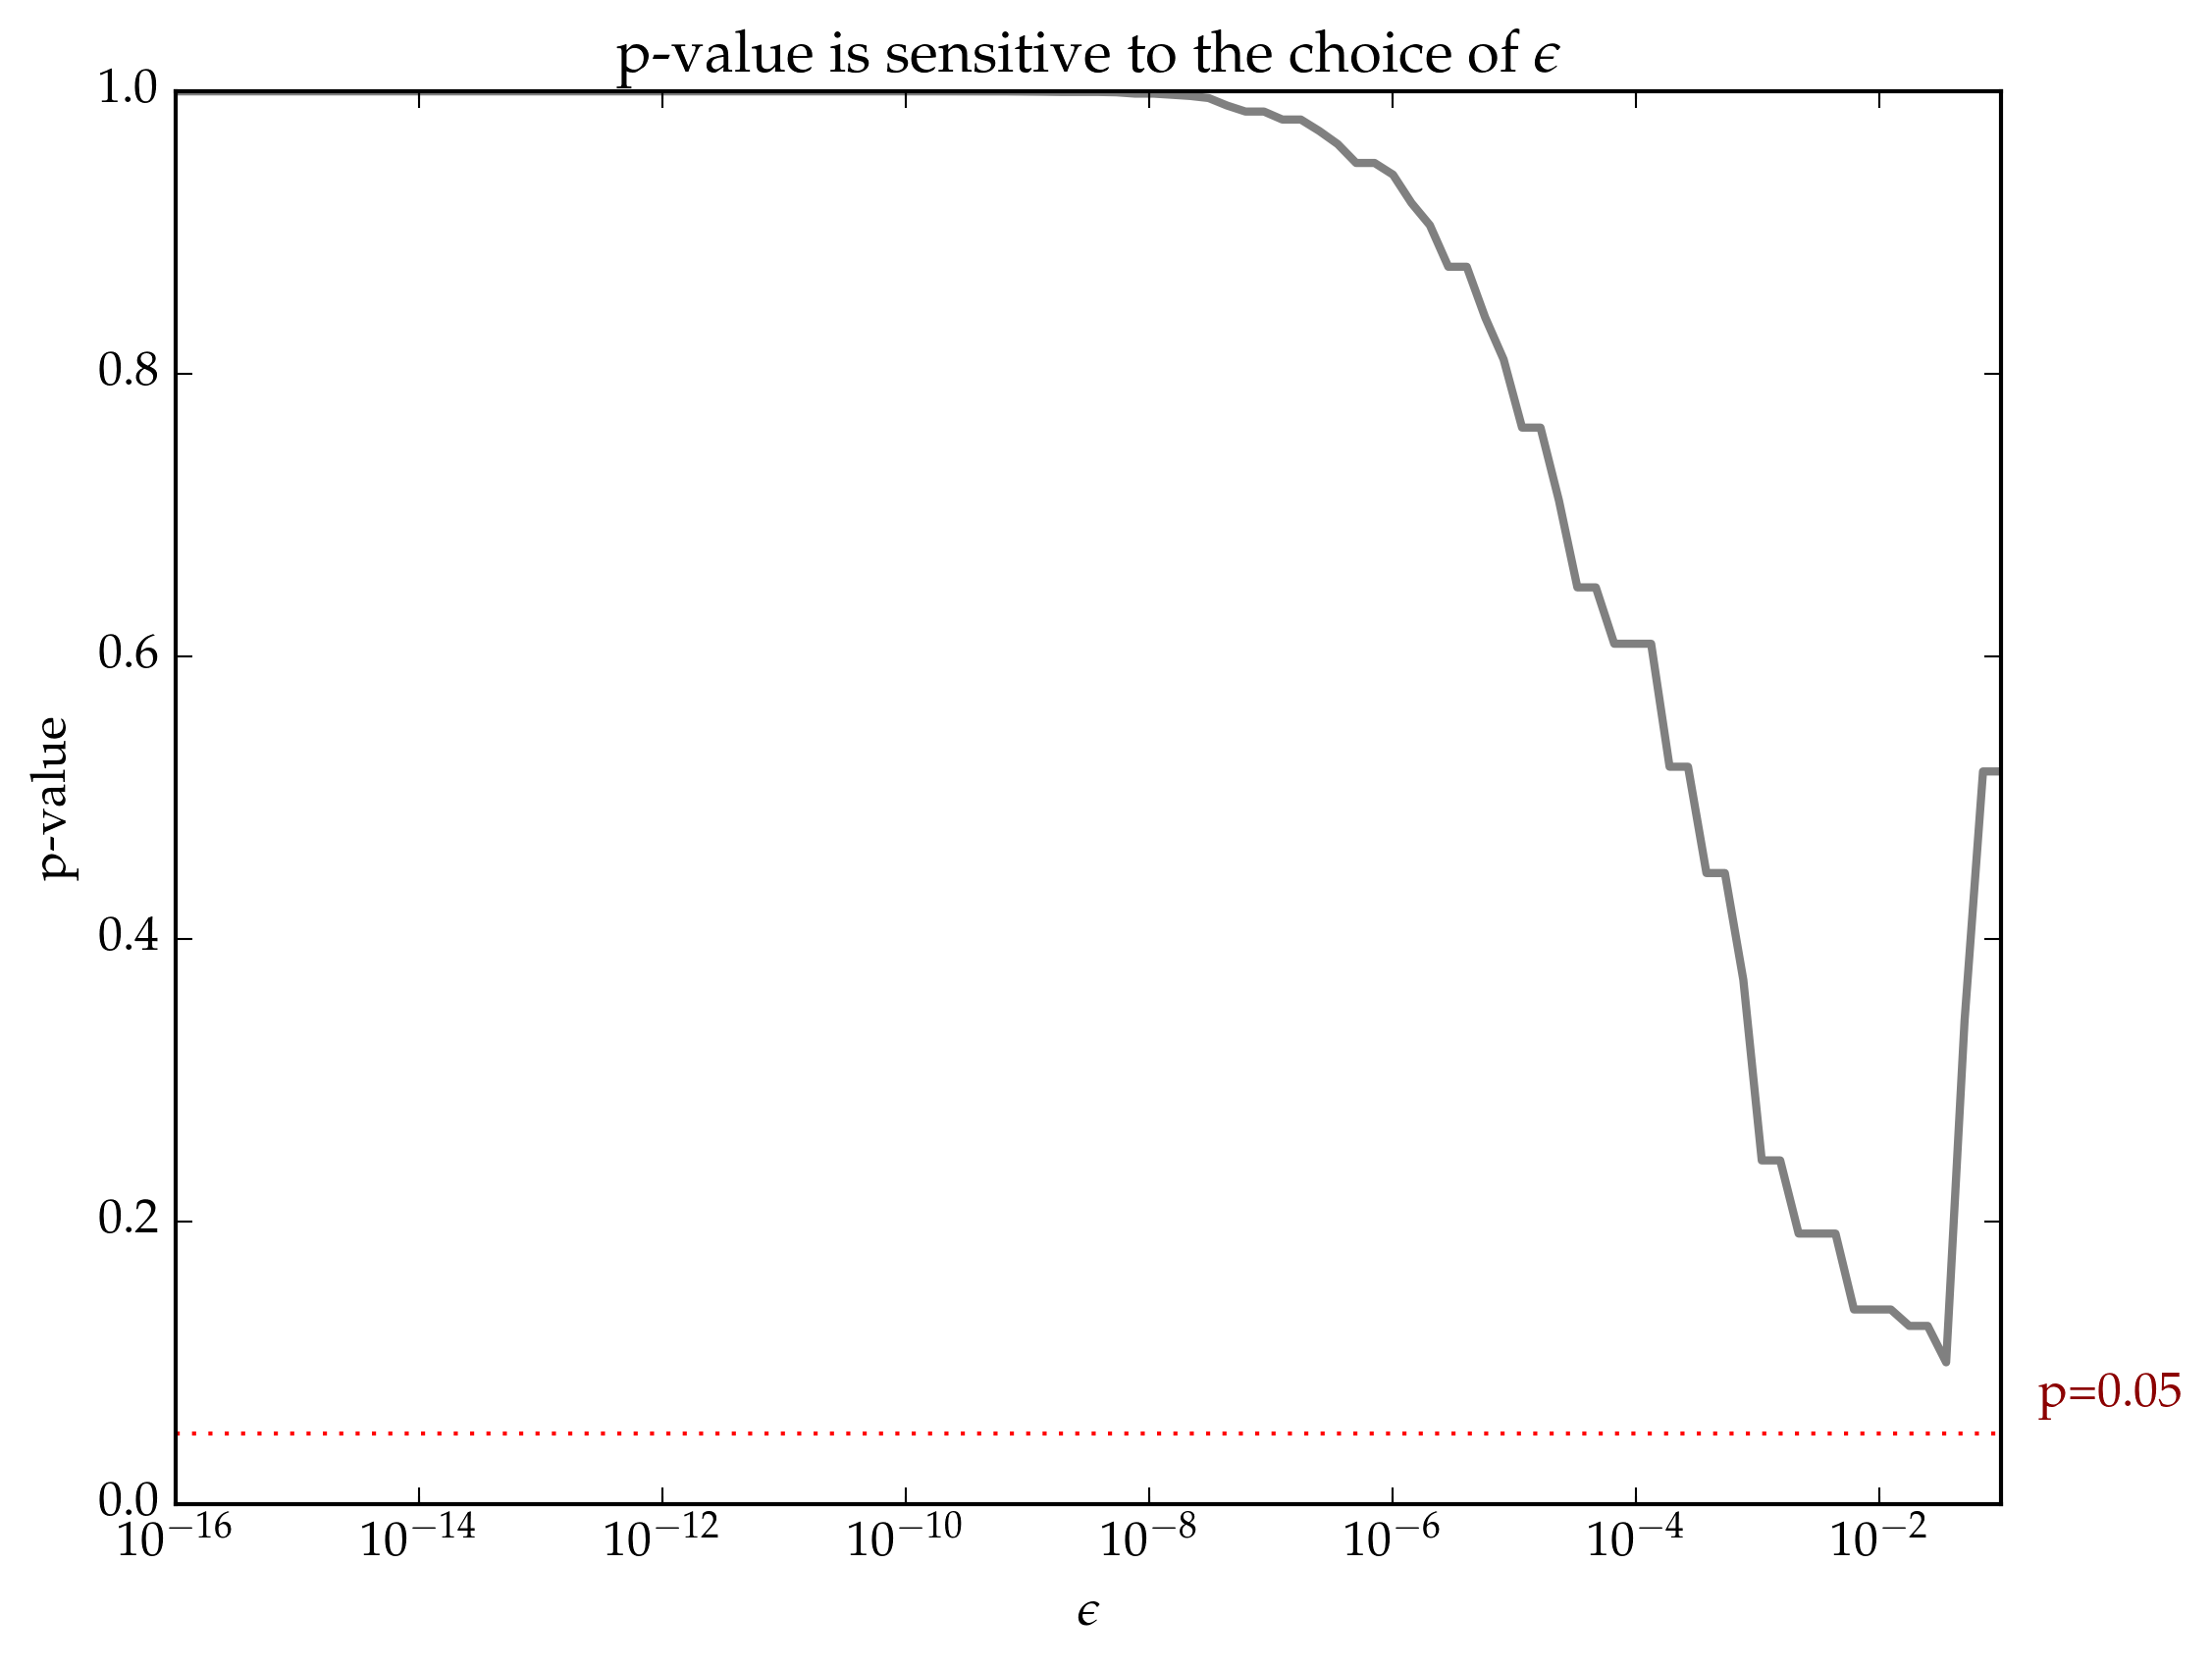

In [151]:
xϵ = logspace(-16,-1,100)
pval_ϵ = [get_pval(resid_μposterior, full(resid_Σposterior), ϵ) for ϵ in xϵ]
plt.semilogx(xϵ, pval_ϵ, "-", color="grey", linewidth=2)
plt.axhline(0.05, linestyle=":", color="red")
plt.text(x=0.2, y=0.06, s="p=0.05", color="darkred", verticalalignment="bottom")
plt.title(L"p-value is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel("p-value")
;

## modified $\chi^2$ test

In [152]:
function chisquare(gpT::GP, gpC::GP, X∂::Matrix, ϵ; verbose=false)
    extrap◫_T = GaussianProcesses.predict(gpT, X◫; full_cov=true)
    extrap◫_C = GaussianProcesses.predict(gpC, X◫; full_cov=true)
    μpost = extrap◫_T[1].-extrap◫_C[1]
    
    K∂C = cov(gpC.k, X∂, gpC.X)
    KC∂ = K∂C'
    KCC = gpC.cK
    
    KCT = cov(gpC.k, gpC.X, gpT.X)
    KTT = gpT.cK
    KT∂ = cov(gpT.k, gpT.X, X∂)
    K∂T = KT∂'
    
    K∂CT∂ = K∂C * (KCC \ KCT) * (KTT \ KT∂)
    
    Σ∂T12 = PDMats.whiten(KTT, KT∂)
#     Σ∂T = K∂T * (KTT \ KT∂)
    Σ∂T = Σ∂T12' * Σ∂T12
    
    Σ∂C12 = PDMats.whiten(KCC, KC∂)
    Σ∂C = Σ∂C12' * Σ∂C12
    
    chi2cov = Σ∂T + Σ∂C - (K∂CT∂ + K∂CT∂')
    if verbose
        evals = eigvals(Symmetric(chi2cov))
        print(evals)
        plt.semilogy(eigvals(Symmetric(chi2cov)))
        plt.xlabel("Eigenvalue number")
        plt.ylabel("Eigenvalue")
        thresh = minimum(evals[evals ./ sum(evals) .> ϵ])
        plt.axhline(thresh, color="red")
    end
    return get_pval(μpost, chi2cov, ϵ)
end

chisquare (generic function with 1 method)

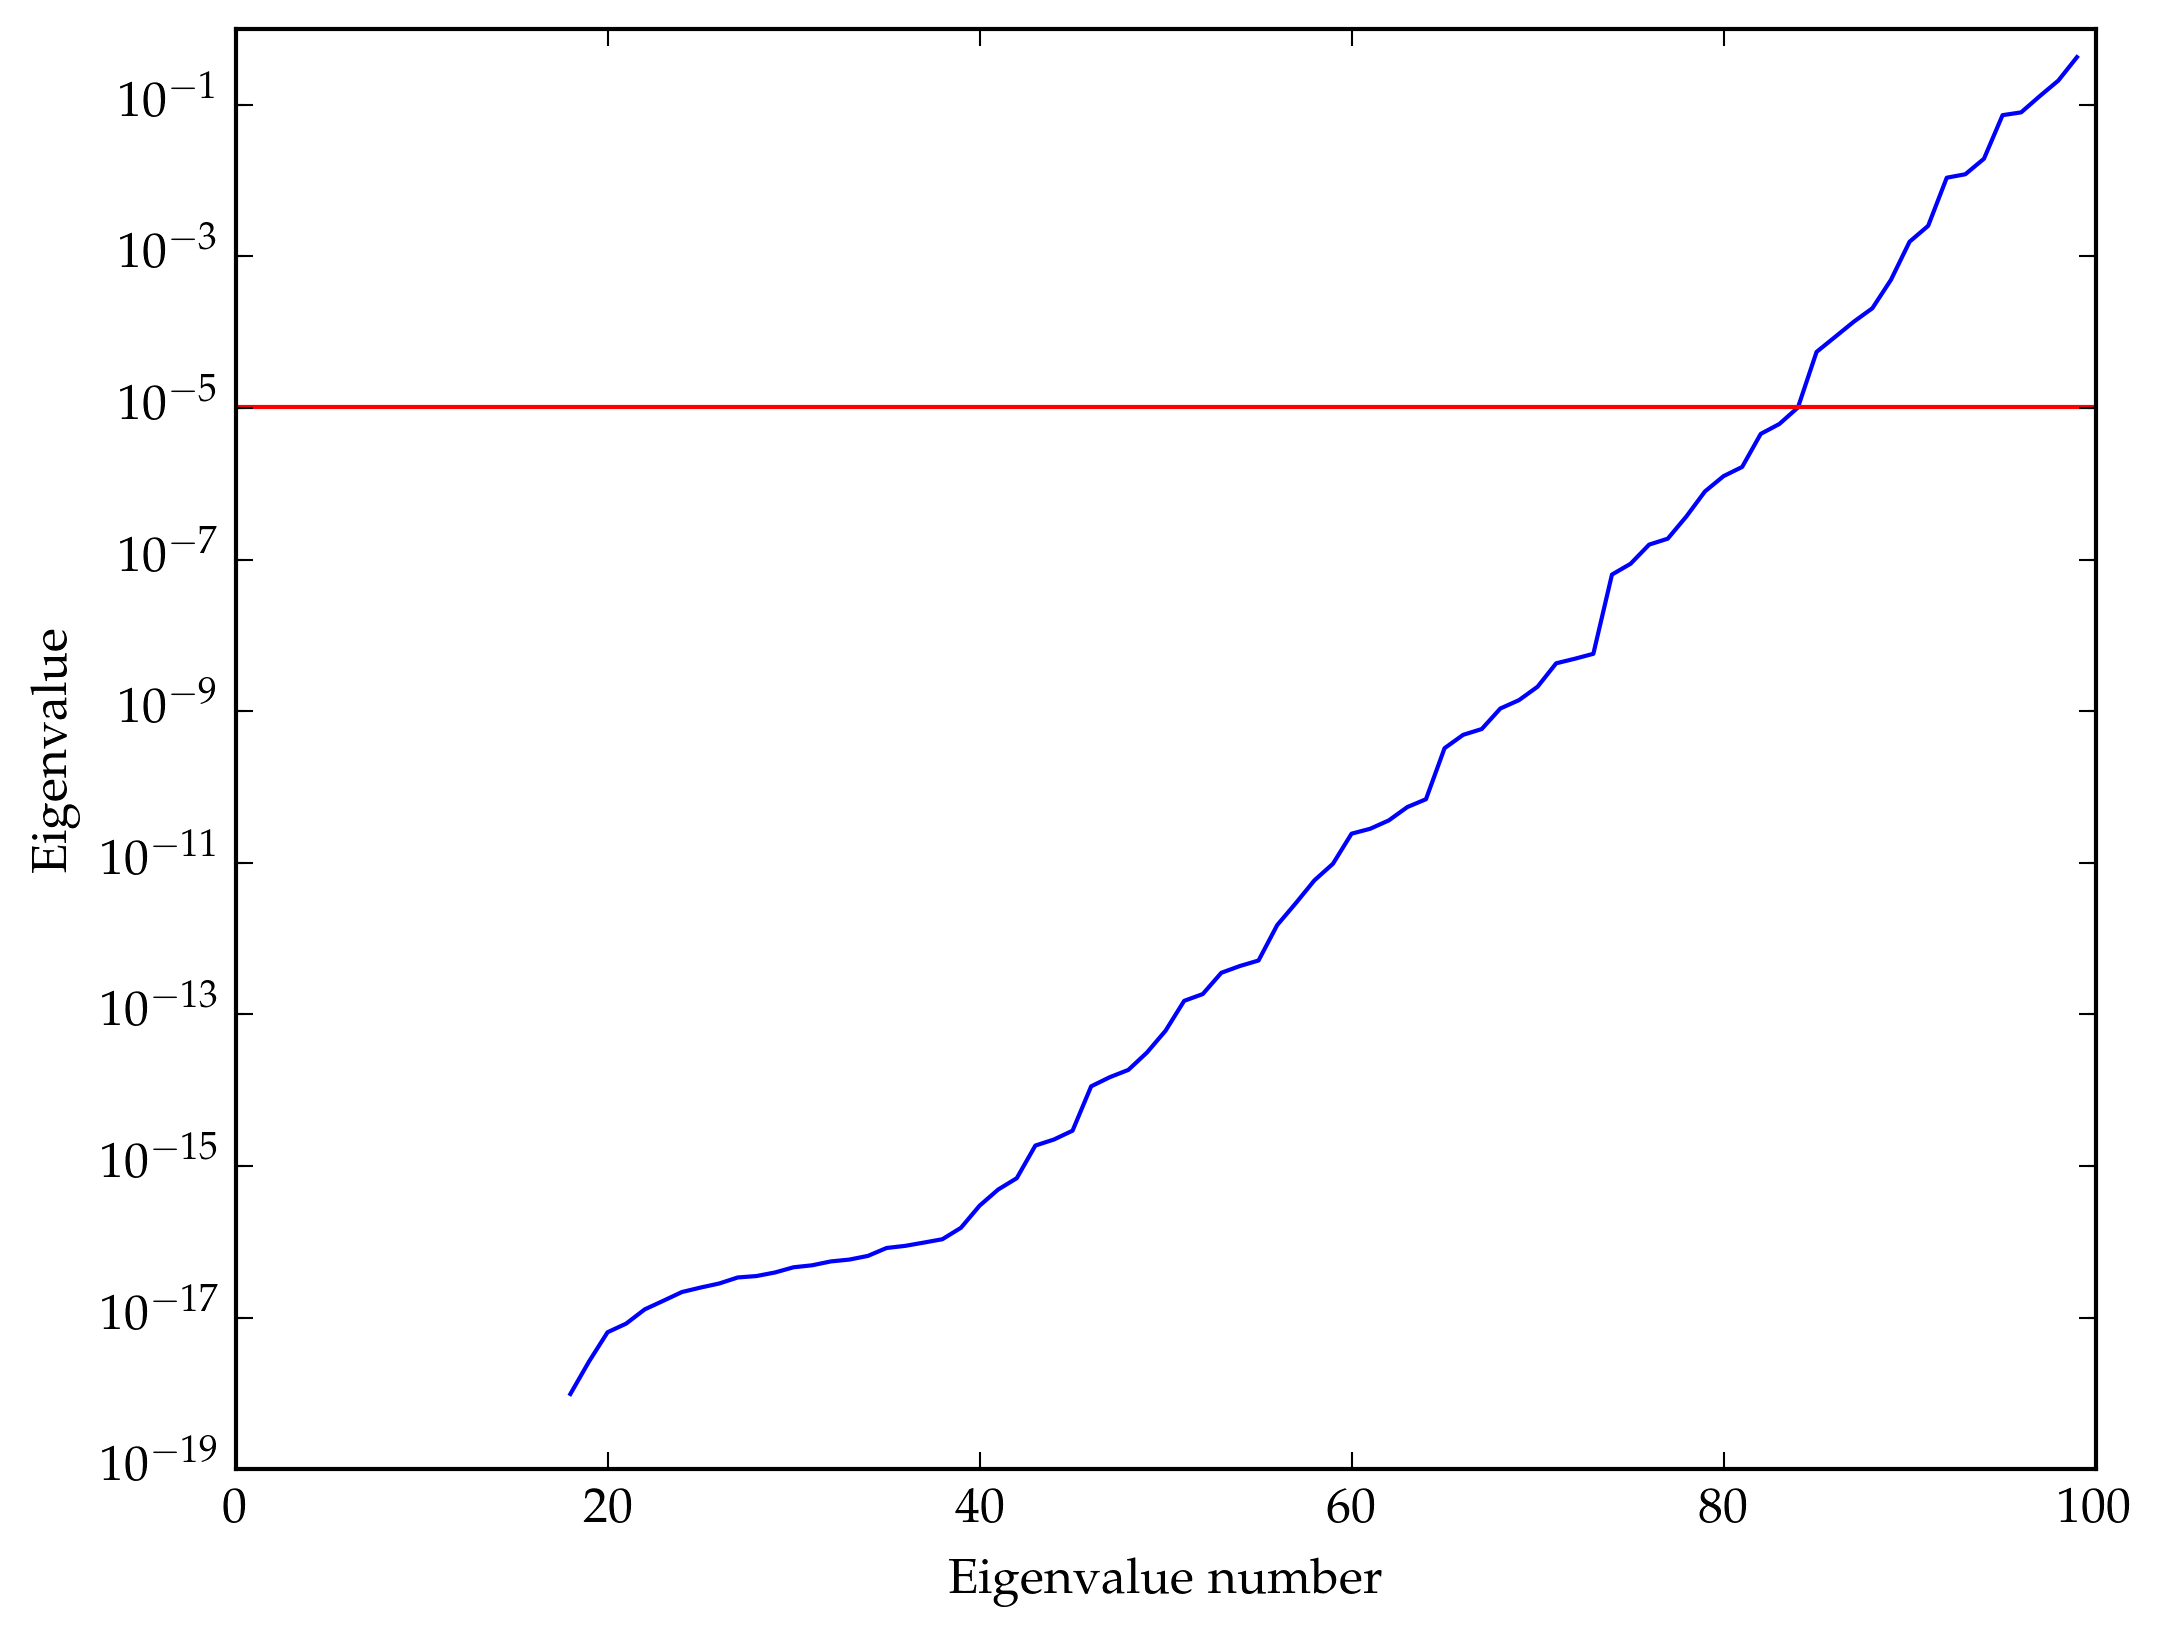

[-1.08126e-16,-1.03879e-16,-9.90537e-17,-7.90804e-17,-6.76713e-17,-5.15199e-17,-4.79169e-17,-4.21478e-17,-4.01868e-17,-3.65499e-17,-3.06045e-17,-2.44044e-17,-2.24818e-17,-1.73811e-17,-9.38926e-18,-4.69154e-18,-3.14522e-18,-1.38893e-18,9.79895e-19,2.62185e-18,6.39904e-18,8.31636e-18,1.28208e-17,1.66509e-17,2.17147e-17,2.4865e-17,2.81209e-17,3.37889e-17,3.52728e-17,3.93086e-17,4.60556e-17,4.8934e-17,5.50004e-17,5.81881e-17,6.50738e-17,8.27264e-17,8.82564e-17,9.74768e-17,1.07956e-16,1.52888e-16,2.98934e-16,4.88486e-16,6.89903e-16,1.85875e-15,2.2342e-15,2.92186e-15,1.1239e-14,1.48278e-14,1.8514e-14,3.13873e-14,6.08819e-14,1.50863e-13,1.854e-13,3.54201e-13,4.34923e-13,5.1426e-13,1.50475e-12,2.92979e-12,5.85741e-12,9.71435e-12,2.42236e-11,2.81257e-11,3.62231e-11,5.44111e-11,6.89978e-11,3.25264e-10,4.88168e-10,5.82223e-10,1.08632e-9,1.39953e-9,2.1039e-9,4.28809e-9,4.924e-9,5.72483e-9,6.35442e-8,8.81968e-8,1.57903e-7,1.8914e-7,3.71222e-7,7.94607e-7,1.26464e-6,1.67157e-6,4.56649e-6,6.16447e-6,1

1.8502155769202734e-20

In [153]:
chisquare(resid_GP_dict[distrA], 
          resid_GP_dict[distrB],
          hcat(sentinels[distrA,distrB].coordinates...),
          1e-5,
          verbose=true,
          )

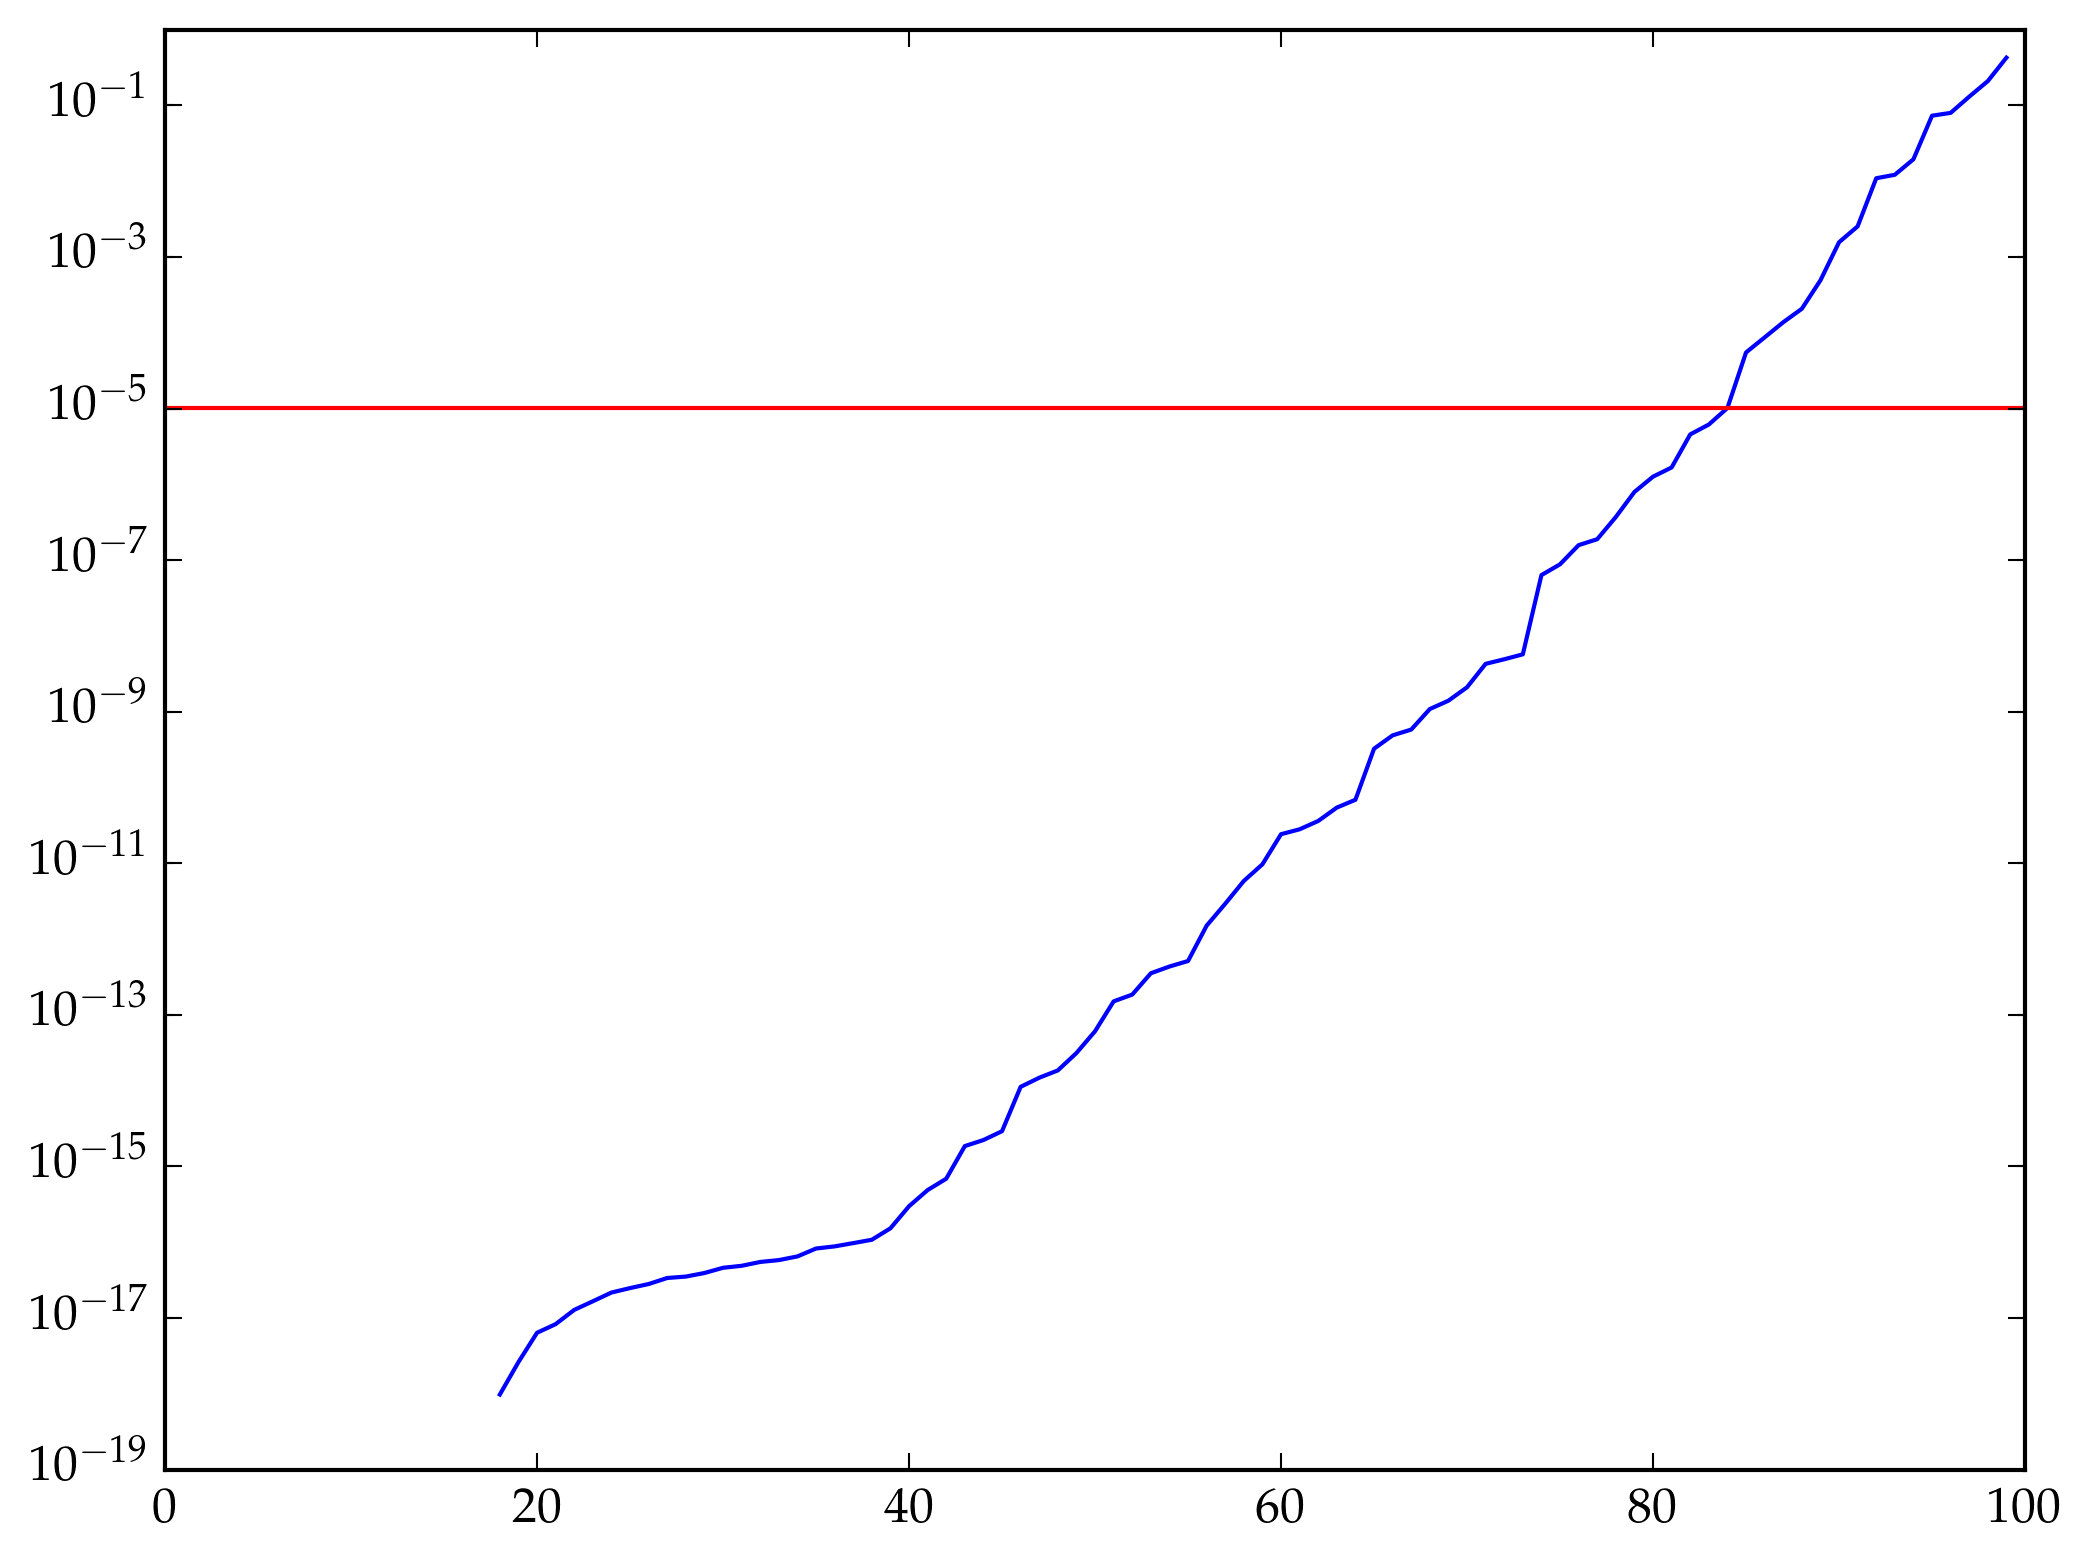

[-1.08126e-16,-1.03879e-16,-9.90537e-17,-7.90804e-17,-6.76713e-17,-5.15199e-17,-4.79169e-17,-4.21478e-17,-4.01868e-17,-3.65499e-17,-3.06045e-17,-2.44044e-17,-2.24818e-17,-1.73811e-17,-9.38926e-18,-4.69154e-18,-3.14522e-18,-1.38893e-18,9.79895e-19,2.62185e-18,6.39904e-18,8.31636e-18,1.28208e-17,1.66509e-17,2.17147e-17,2.4865e-17,2.81209e-17,3.37889e-17,3.52728e-17,3.93086e-17,4.60556e-17,4.8934e-17,5.50004e-17,5.81881e-17,6.50738e-17,8.27264e-17,8.82564e-17,9.74768e-17,1.07956e-16,1.52888e-16,2.98934e-16,4.88486e-16,6.89903e-16,1.85875e-15,2.2342e-15,2.92186e-15,1.1239e-14,1.48278e-14,1.8514e-14,3.13873e-14,6.08819e-14,1.50863e-13,1.854e-13,3.54201e-13,4.34923e-13,5.1426e-13,1.50475e-12,2.92979e-12,5.85741e-12,9.71435e-12,2.42236e-11,2.81257e-11,3.62231e-11,5.44111e-11,6.89978e-11,3.25264e-10,4.88168e-10,5.82223e-10,1.08632e-9,1.39953e-9,2.1039e-9,4.28809e-9,4.924e-9,5.72483e-9,6.35442e-8,8.81968e-8,1.57903e-7,1.8914e-7,3.71222e-7,7.94607e-7,1.26464e-6,1.67157e-6,4.56649e-6,6.16447e-6,1

1.8502155769202734e-20

In [154]:
GeoRDD.chisquare(resid_GP_dict[distrA], 
          resid_GP_dict[distrB],
          hcat(sentinels[distrA,distrB].coordinates...),
          1e-5,
          verbose=true,
          )

### p-value as a function of $\epsilon$ (yikes)

In [155]:
xϵ = logspace(-16,-1,100)
pval_ϵ = [chisquare(resid_GP_dict[distrA], 
          resid_GP_dict[distrB],
          hcat(sentinels[distrA,distrB].coordinates...),
          ϵ,
          verbose=false,
          ) for ϵ in xϵ]
;

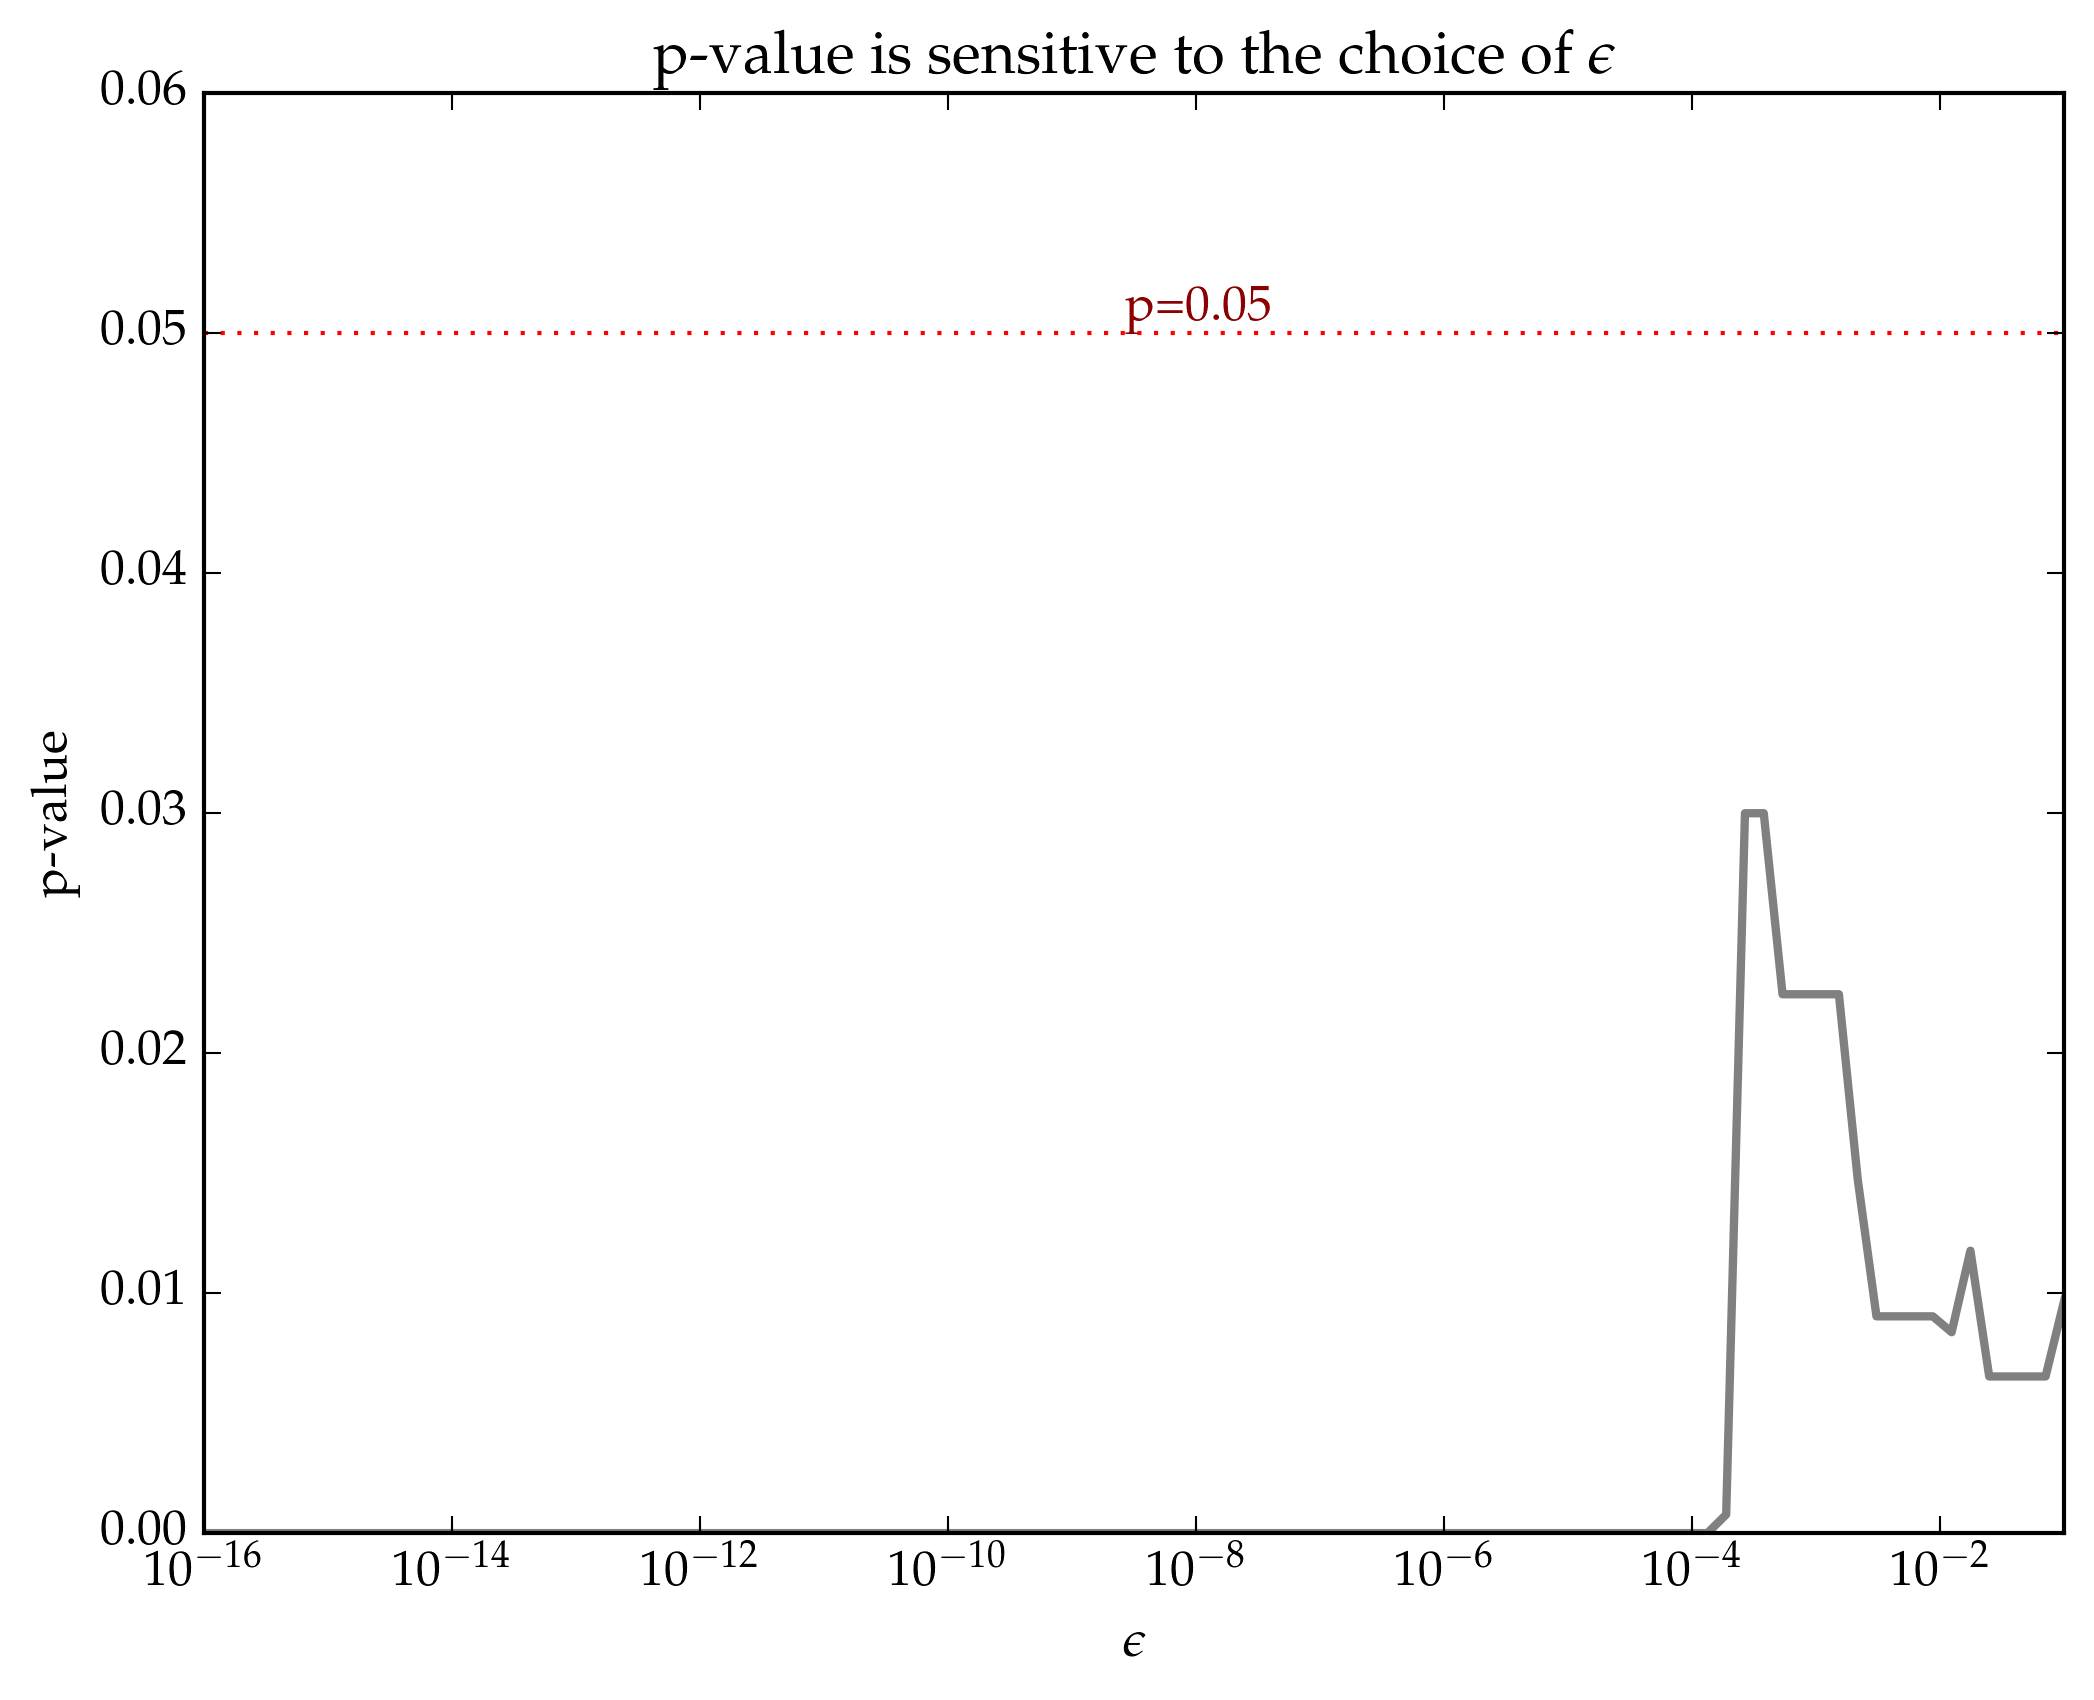

In [156]:
plt.semilogx(xϵ, pval_ϵ, "-", color="grey", linewidth=2)
plt.axhline(0.05, linestyle=":", color="red")
plt.text(x=xϵ[50], y=0.05, s="p=0.05", color="darkred", verticalalignment="bottom")
plt.title(L"p-value is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel("p-value")
;

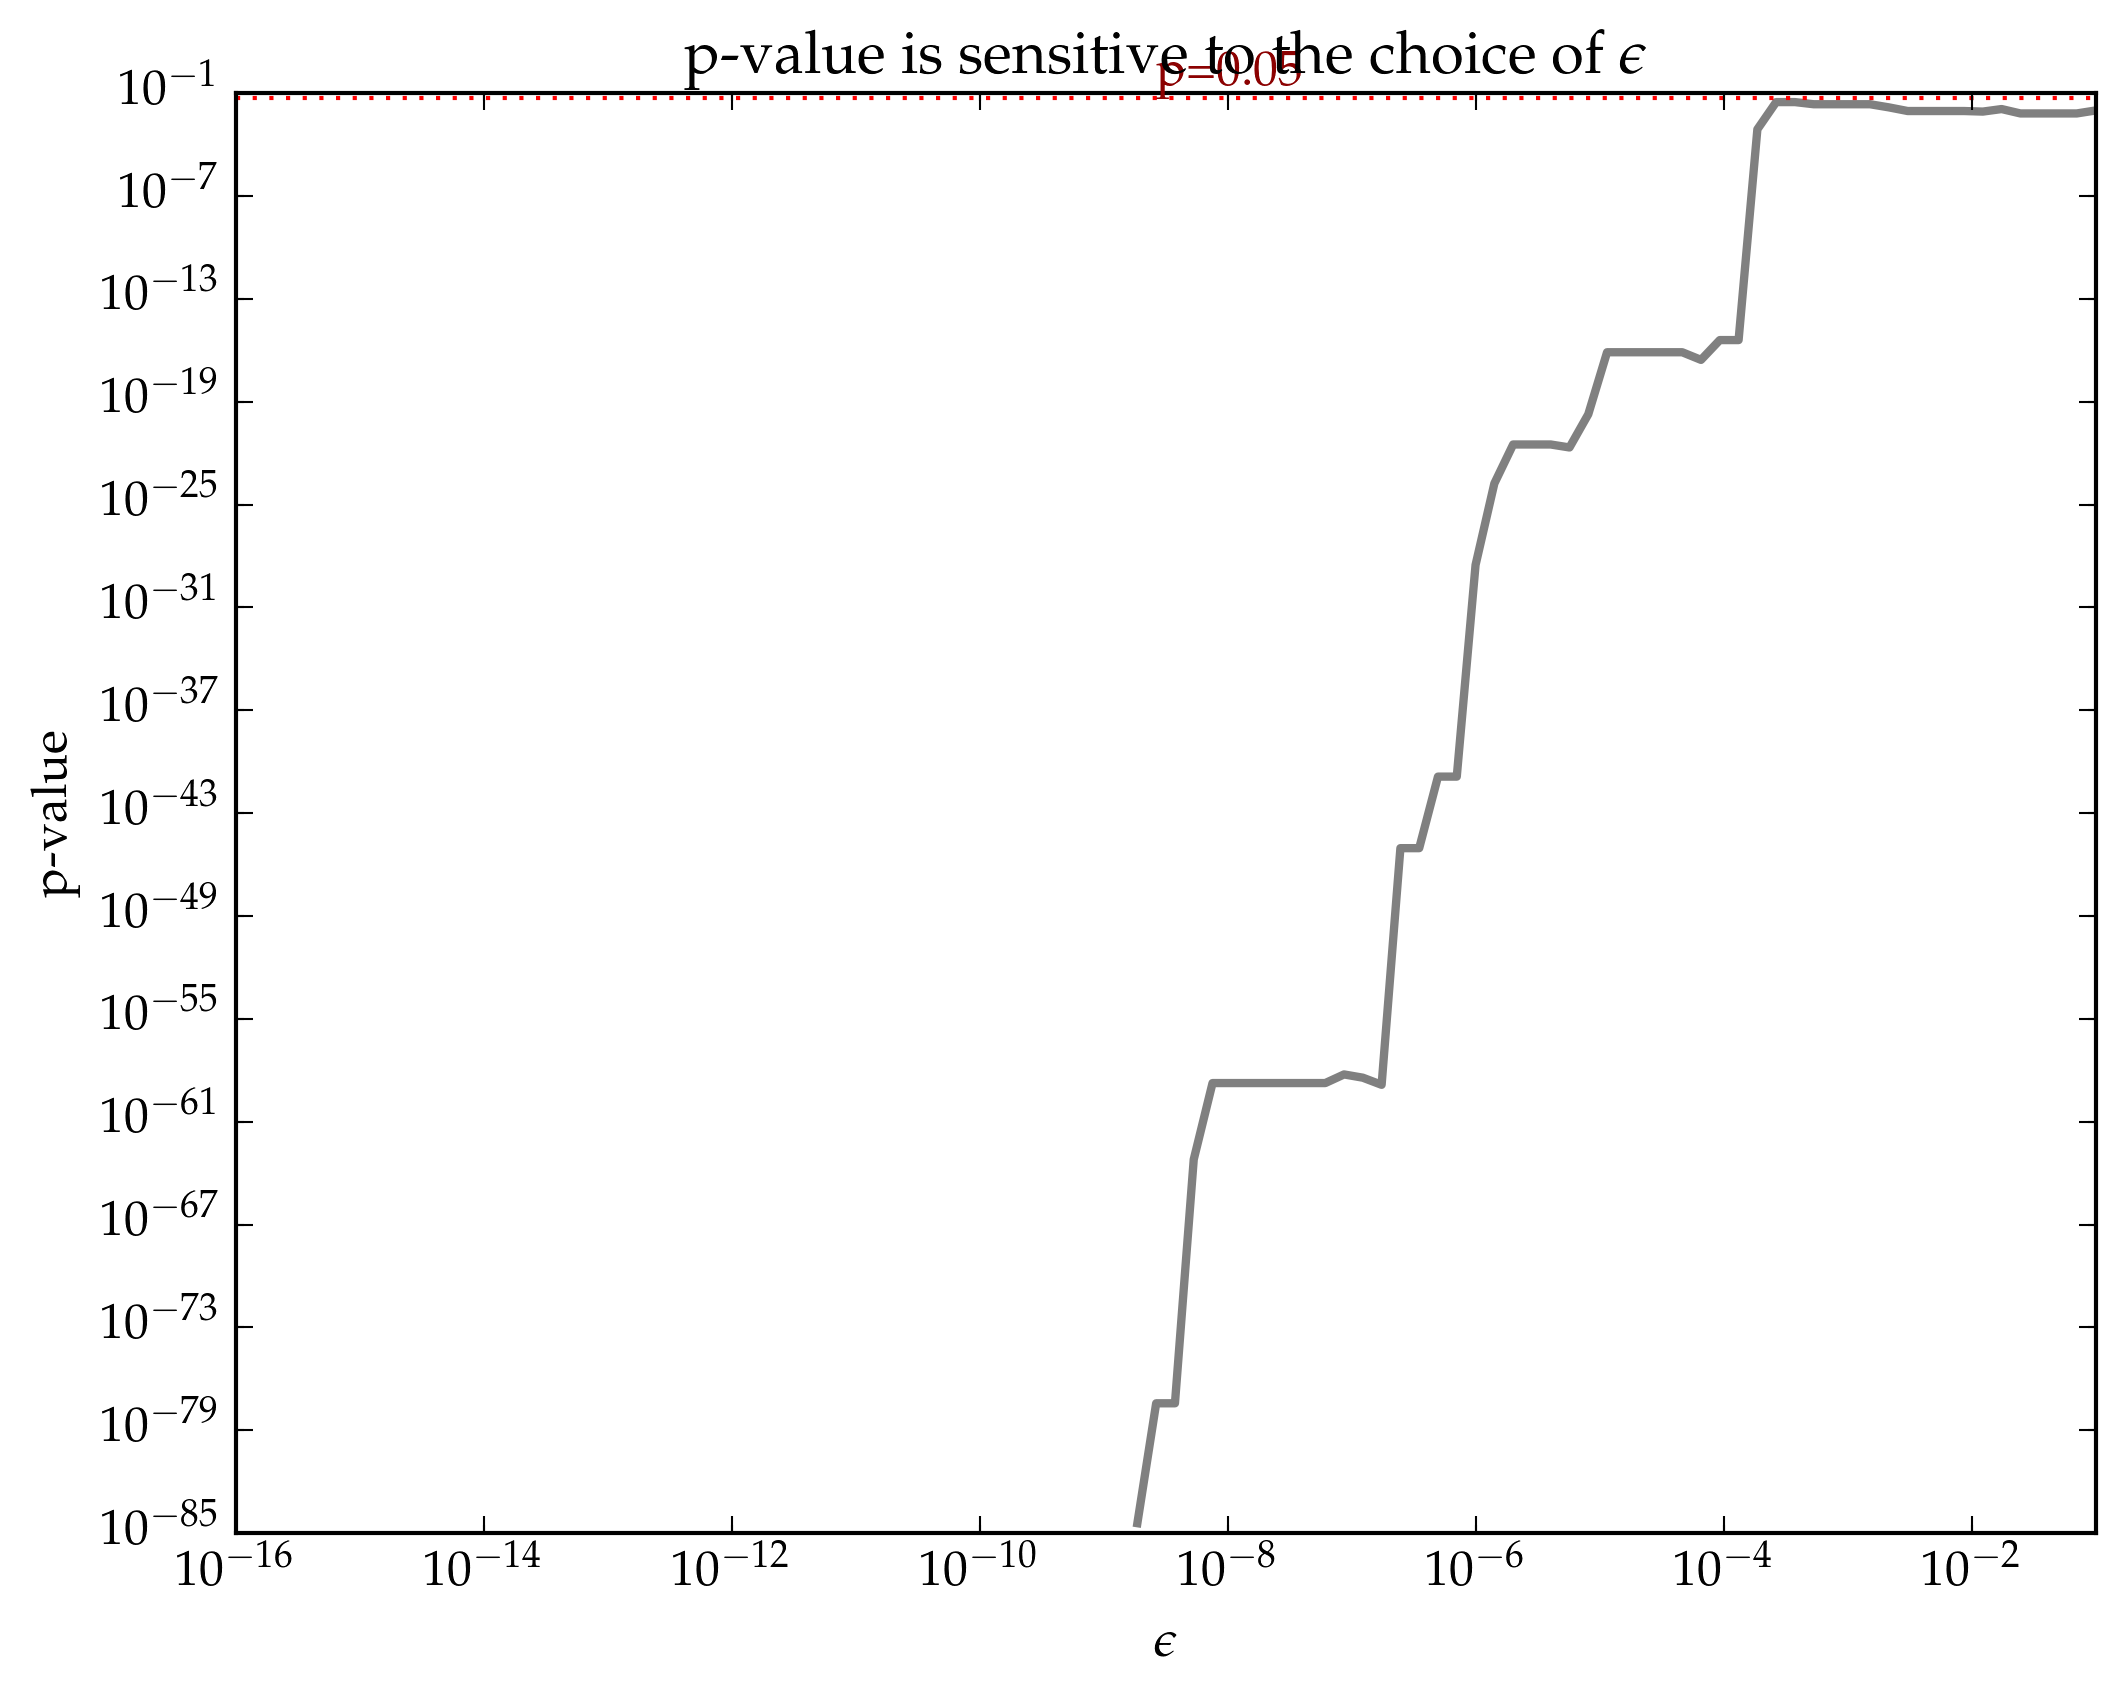

In [157]:
plt.loglog(xϵ, pval_ϵ, "-", color="grey", linewidth=2)
plt.axhline(0.05, linestyle=":", color="red")
plt.text(x=xϵ[50], y=0.05, s="p=0.05", color="darkred", verticalalignment="bottom")
plt.title(L"p-value is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel("p-value")
;

In [158]:
function ϵPINV(Σ::Matrix{Float64})
    tol = eps() * maximum(Σ) * maximum(size(Σ))
    sumλ = trace(Σ)
    ϵ = tol / sumλ
    return ϵ
end

ϵPINV (generic function with 1 method)

Good news: below 0.05. Bad news: depends heavily on the choice of $\epsilon$.

## p-value from $\chi^2$ statistic under simulated null parametric bootstrap

In [159]:
distrA = "19"
distrB = "27"
t=GeoRDD.chistat(resid_GP_dict[distrA], 
             resid_GP_dict[distrB], 
             hcat(sentinels[distrA,distrB].coordinates...))

9.563123772452045

In [160]:
@time t_nulls = GeoRDD.nsim_chi(resid_GP_dict[distrA], 
                             resid_GP_dict[distrB], 
                             hcat(sentinels[distrA,distrB].coordinates...),
                             1000;
                             update_mean=true
                             );

 30.961921 seconds (434.93 k allocations: 7.508 GB, 2.87% gc time)


In [161]:
median(t_nulls)

8.779850121777557

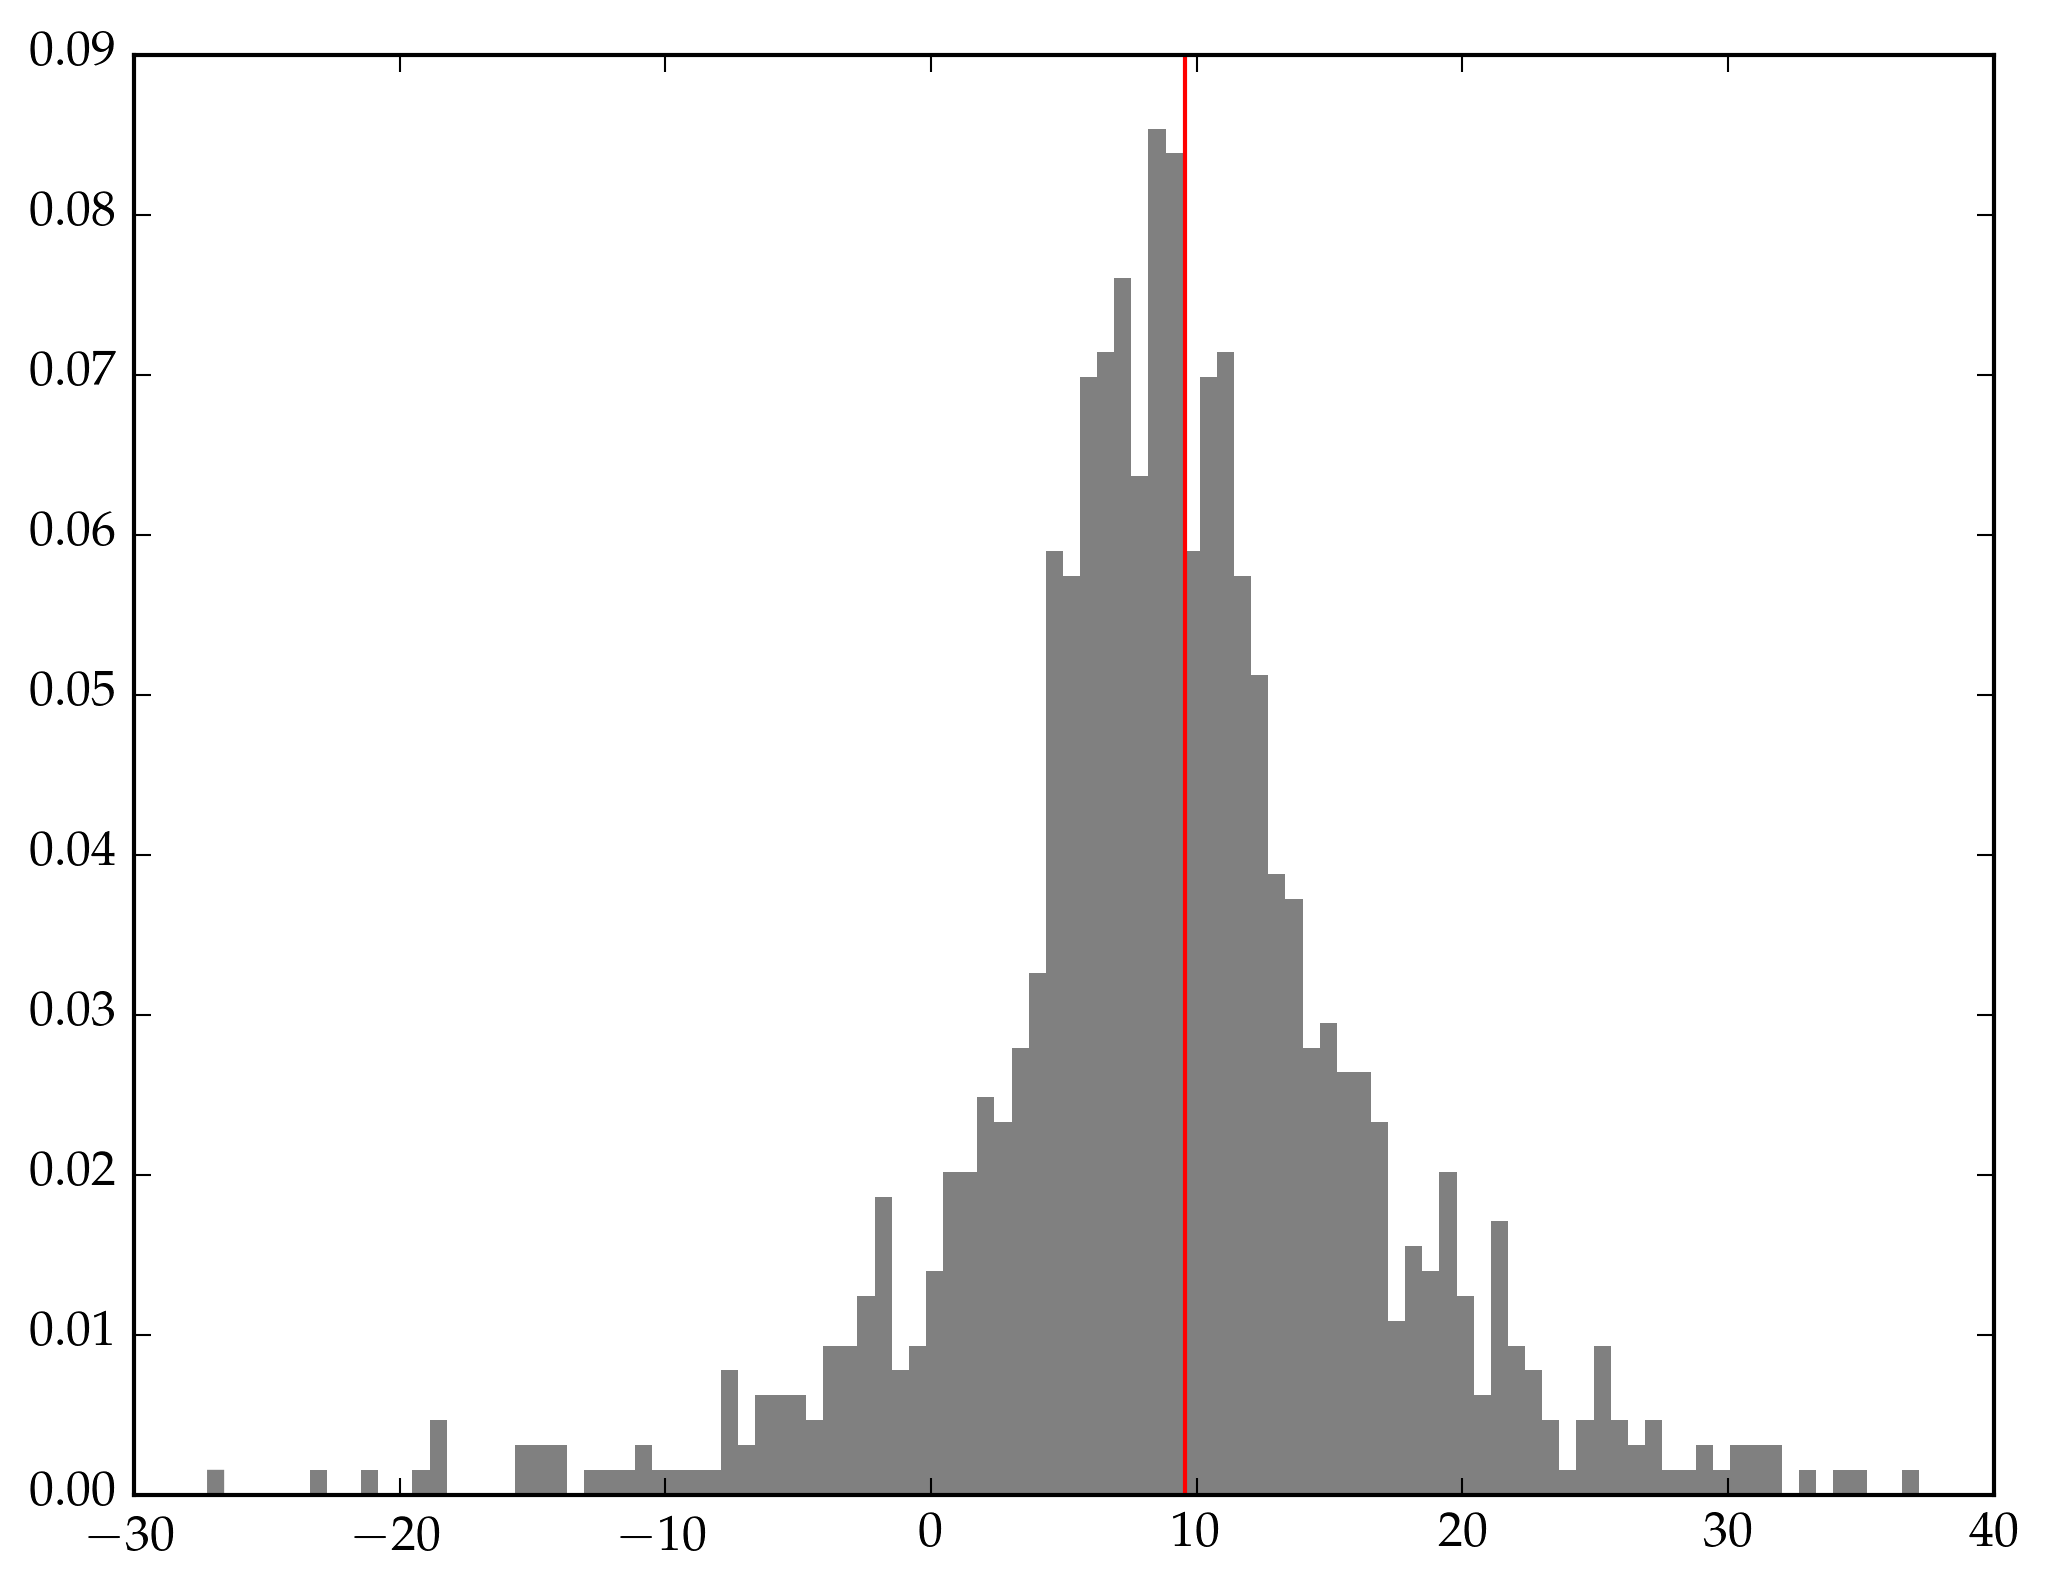

In [162]:
plt.plt[:hist](t_nulls, normed=true, bins=100, color="grey", edgecolor="none")
plt.axvline(t, color="red")
xx=linspace(0,160,200)
# plt.plot(xx, pdf(d,xx), color="turquoise")
;

In [163]:
chi2_boot_pval = mean(t_nulls .> t)

0.437

So we get a p-value of $\approx0.45$, and no significant effect at all.
Shit.

### Sanity check: add constant to one side, do we get a significant treatment effect?

In [269]:
distrB

"27"

In [277]:
begin
    name=distrB
    X = X_dict[name]
    Y = resid_dict[name].+0.2
    global distrBplus = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
end
;

In [278]:
tplus=GeoRDD.chistat(resid_GP_dict[distrA], 
             distrBplus, 
             hcat(sentinels[distrA,distrB].coordinates...))

47.25841423975919

In [279]:
mean(t_nulls .> tplus)

0.0

It doesn't take much of a treatment effect to bring the p-value down to zero (to the nearest thousandth). 
We've added 0.2 to district 27 log residual house prices, which is comparable to the inverse-variance estimated mean treatment effect of 0.176.
So the test seems to be working properly.

### Placebo test for $\chi^2$ parametric bootstrap test

In [164]:
gpA=resid_GP_dict[distrA]
@time placebo_chi_pvals_A = [GeoRDD.placebo_chi(angle, 
    gpA.X, 
    gpA.y, 
    gpA.k, 
    gpA.logNoise, 
    1000;
    update_mean=true
    ) 
    for angle in 1.:2.:180.];

560.836270 seconds (32.04 M allocations: 212.170 GB, 4.86% gc time)


In [182]:
gpB=resid_GP_dict[distrB]
@time placebo_chi_pvals_B = [GeoRDD.placebo_chi(angle, 
    gpB.X, 
    gpB.y, 
    gpB.k, 
    gpB.logNoise, 
    1000;
    update_mean=true
    ) 
    for angle in 1.:2.:180.];

1724.731577 seconds (40.28 M allocations: 543.712 GB, 3.82% gc time)


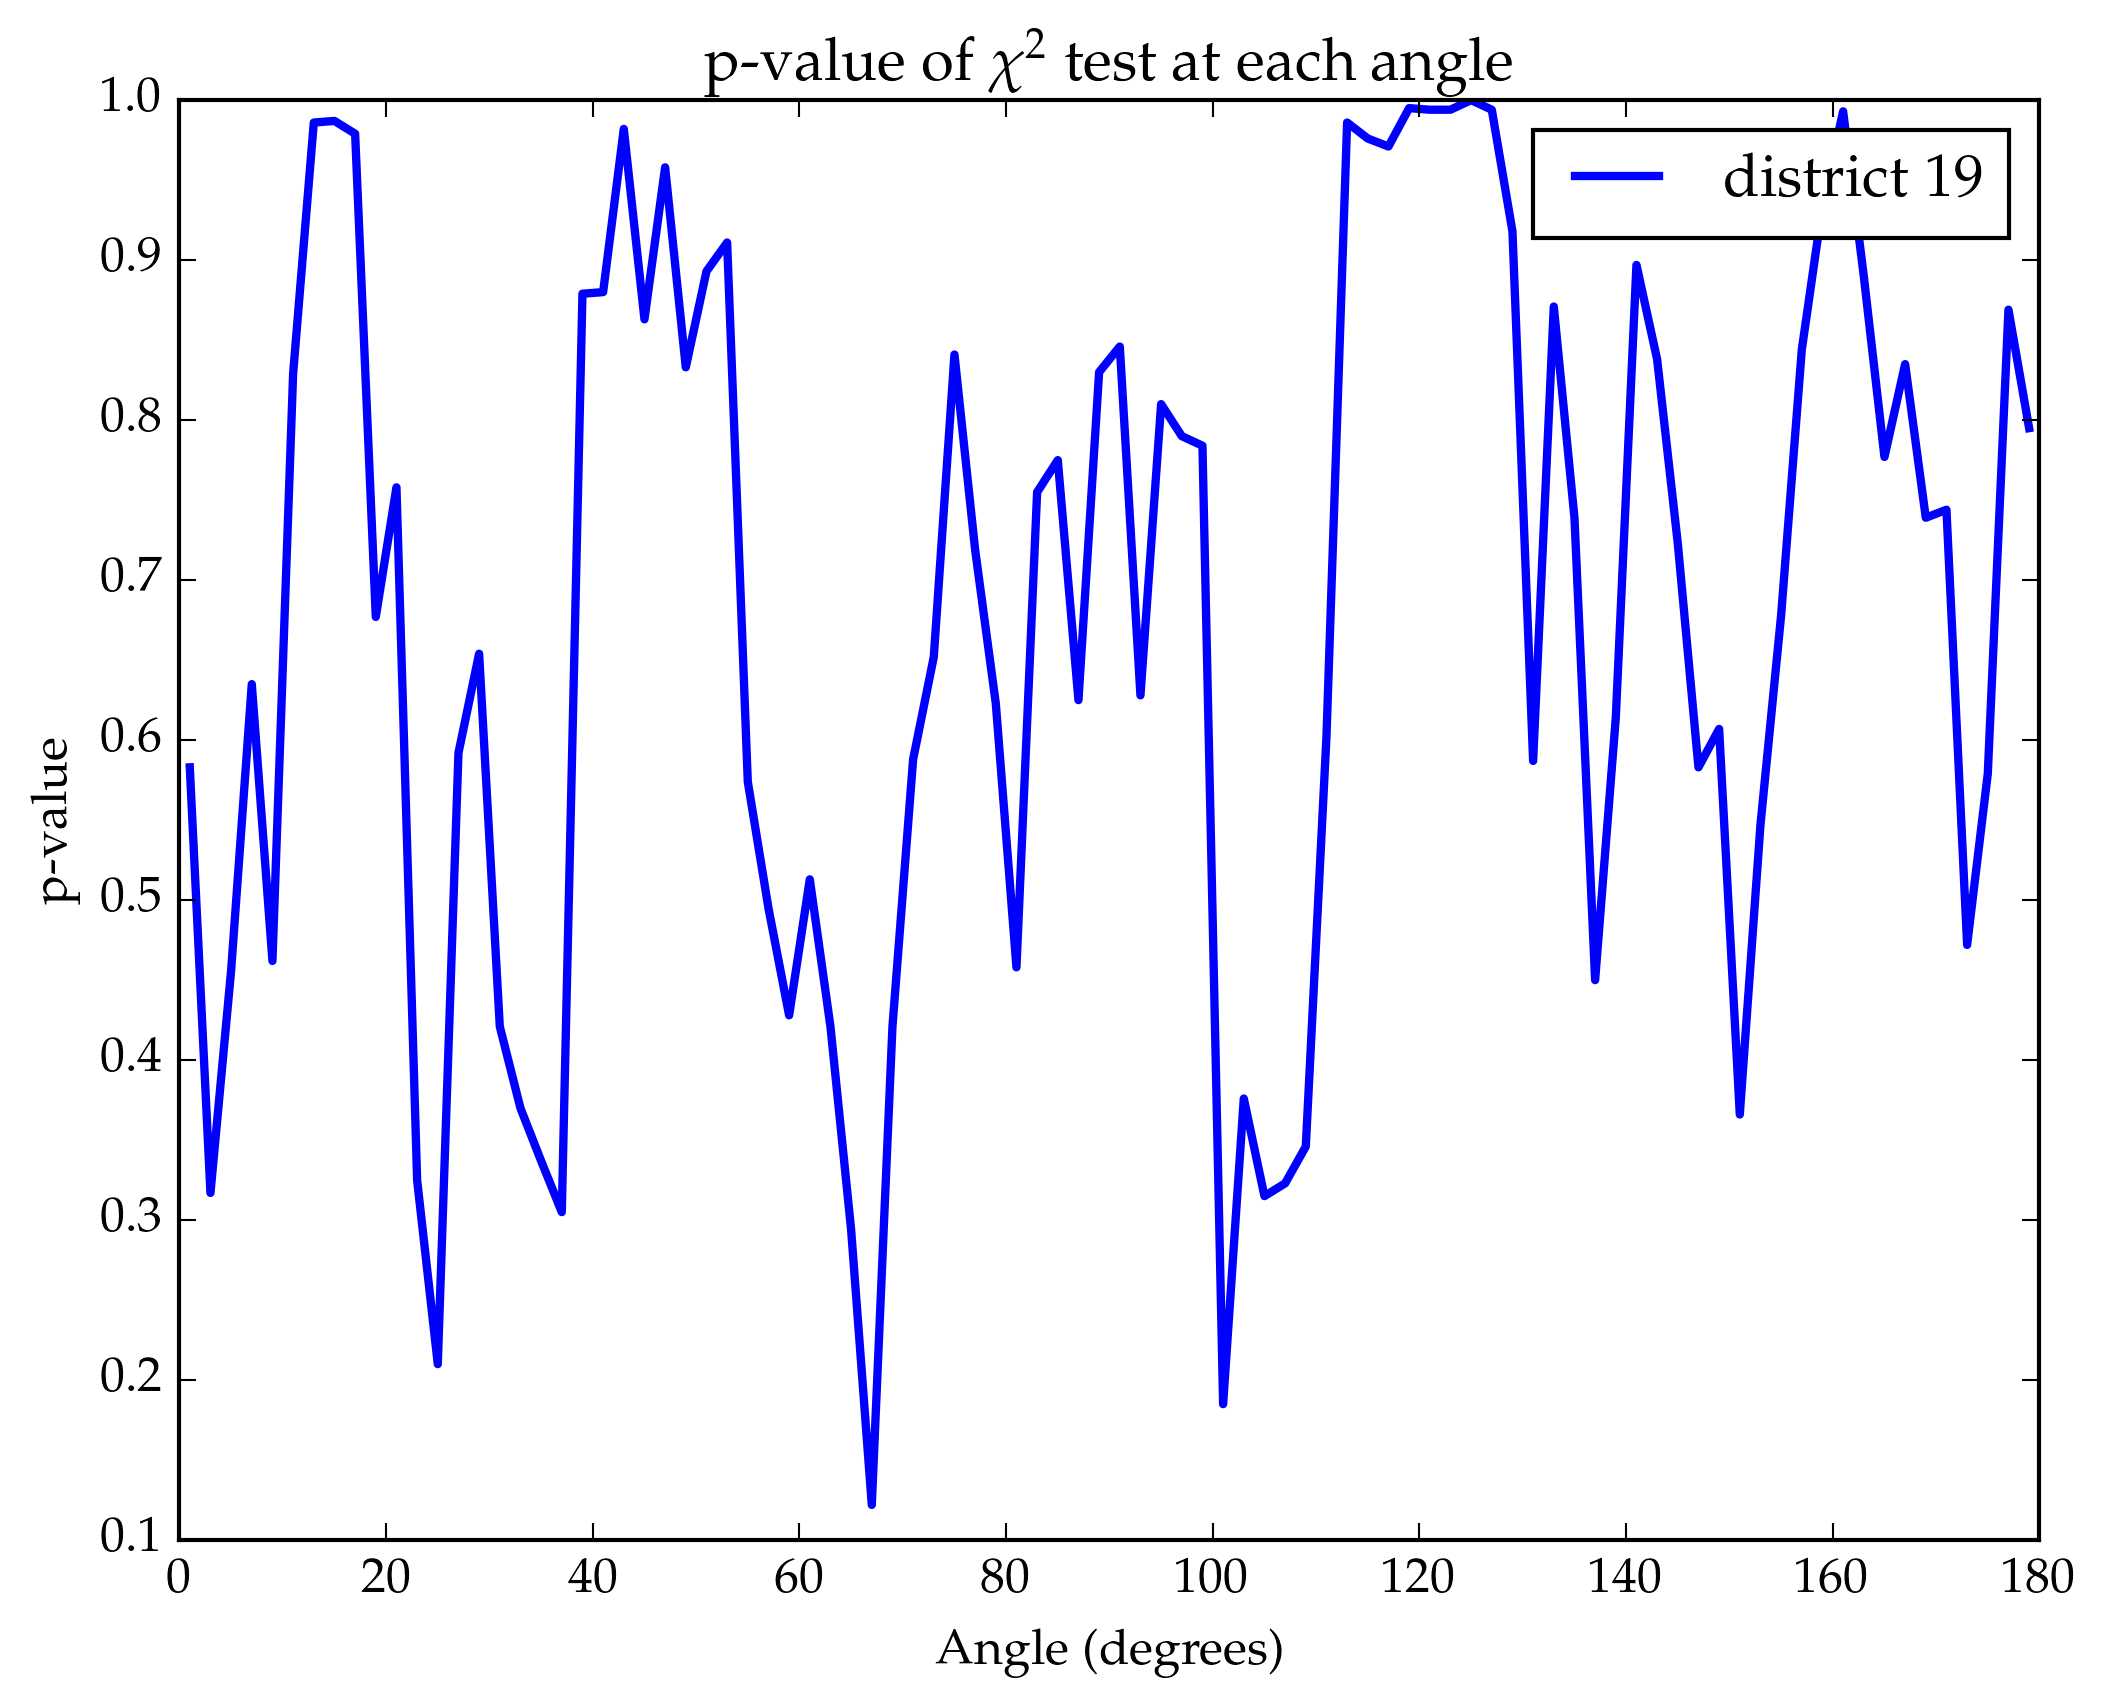

In [165]:
plt.plot(1:2:180, placebo_chi_pvals_A, label=@sprintf("district %s", distrA), linewidth=2)
# plt.plot(1:2:180, placebo_chi_pvals_B, label=@sprintf("district %s", distrB), linewidth=2)
plt.xlabel("Angle (degrees)")
plt.ylabel("p-value")
plt.title(L"p-value of $\chi^2$ test at each angle")
plt.legend()
;

In [220]:
mean(placebo_chi_pvals_A.<0.05),mean(placebo_chi_pvals_B.<0.05)

(0.0,0.07777777777777778)

In [221]:
mean(placebo_chi_pvals_A.<chi2_boot_pval),mean(placebo_chi_pvals_B.<chi2_boot_pval)

(0.2,0.7111111111111111)

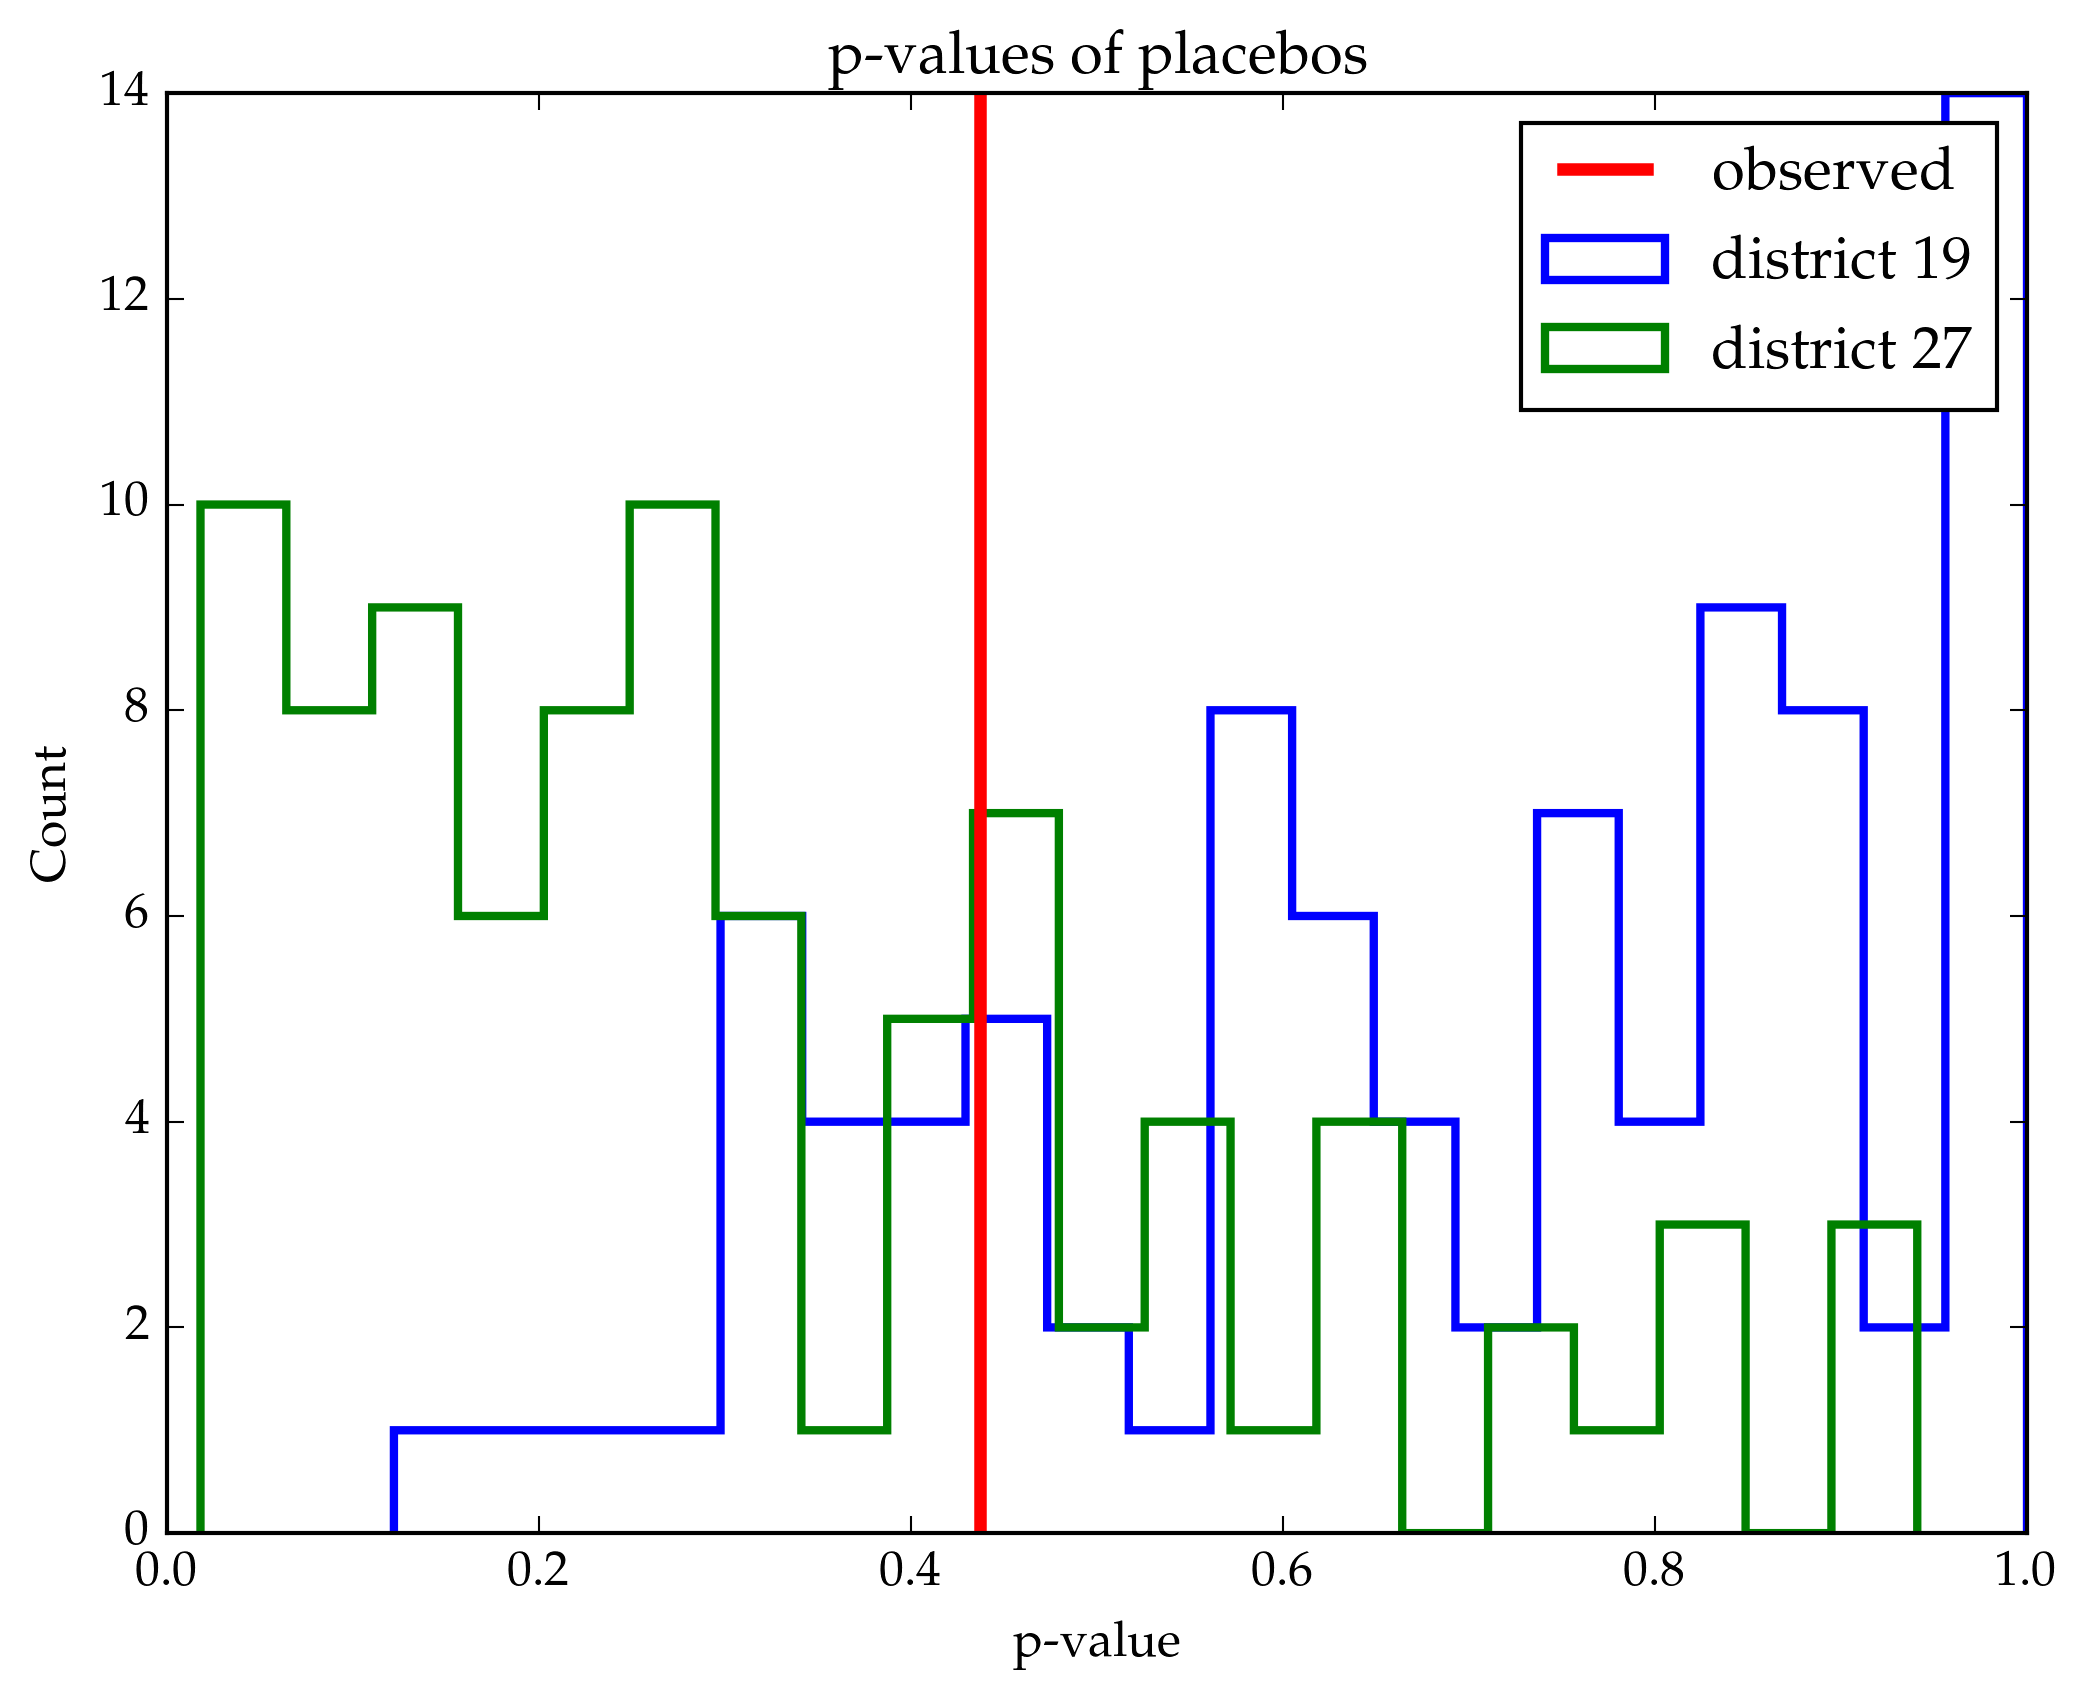

In [224]:
plt.plt[:hist](placebo_chi_pvals_A, bins=20, linewidth=2, label=@sprintf("district %s", distrA), histtype="step")
plt.plt[:hist](placebo_chi_pvals_B, bins=20, linewidth=2, label=@sprintf("district %s", distrB), histtype="step")
plt.axvline(chi2_boot_pval, color="red", label="observed", linewidth=3)
plt.legend(loc="upper right")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.title("p-values of placebos")
;

The placebo test for the $\chi^2$ bootstrap test doesn't show any particularly strong bias. 
We actually see a slant towards high p-values in district 19, and a slant towards low p-values in district 27. 
Considering the low number of effective samples, this seems pretty reasonable to me.
Unfortunately, this means we can't invalidate the $\chi^2$ test's failure to reject the sharp null.

## simulated nulls looking at mLL instead of $\chi^2$

In [169]:
@time mLL_sims = GeoRDD.nsim_logP(resid_GP_dict[distrA], 
                             resid_GP_dict[distrB], 
                             1000;
                             update_mean=true
                             );

 22.063436 seconds (195.99 k allocations: 479.505 MB, 3.05% gc time)


In [170]:
mLL_sim_null = [sim[1] for sim in mLL_sims]
mLL_sim_altv = [sim[2] for sim in mLL_sims]
;

In [171]:
mLL_null, mLL_altv = GeoRDD.data_logP(resid_GP_dict[distrA], resid_GP_dict[distrB])

(-1747.9034321280674,-1744.7760663612426)

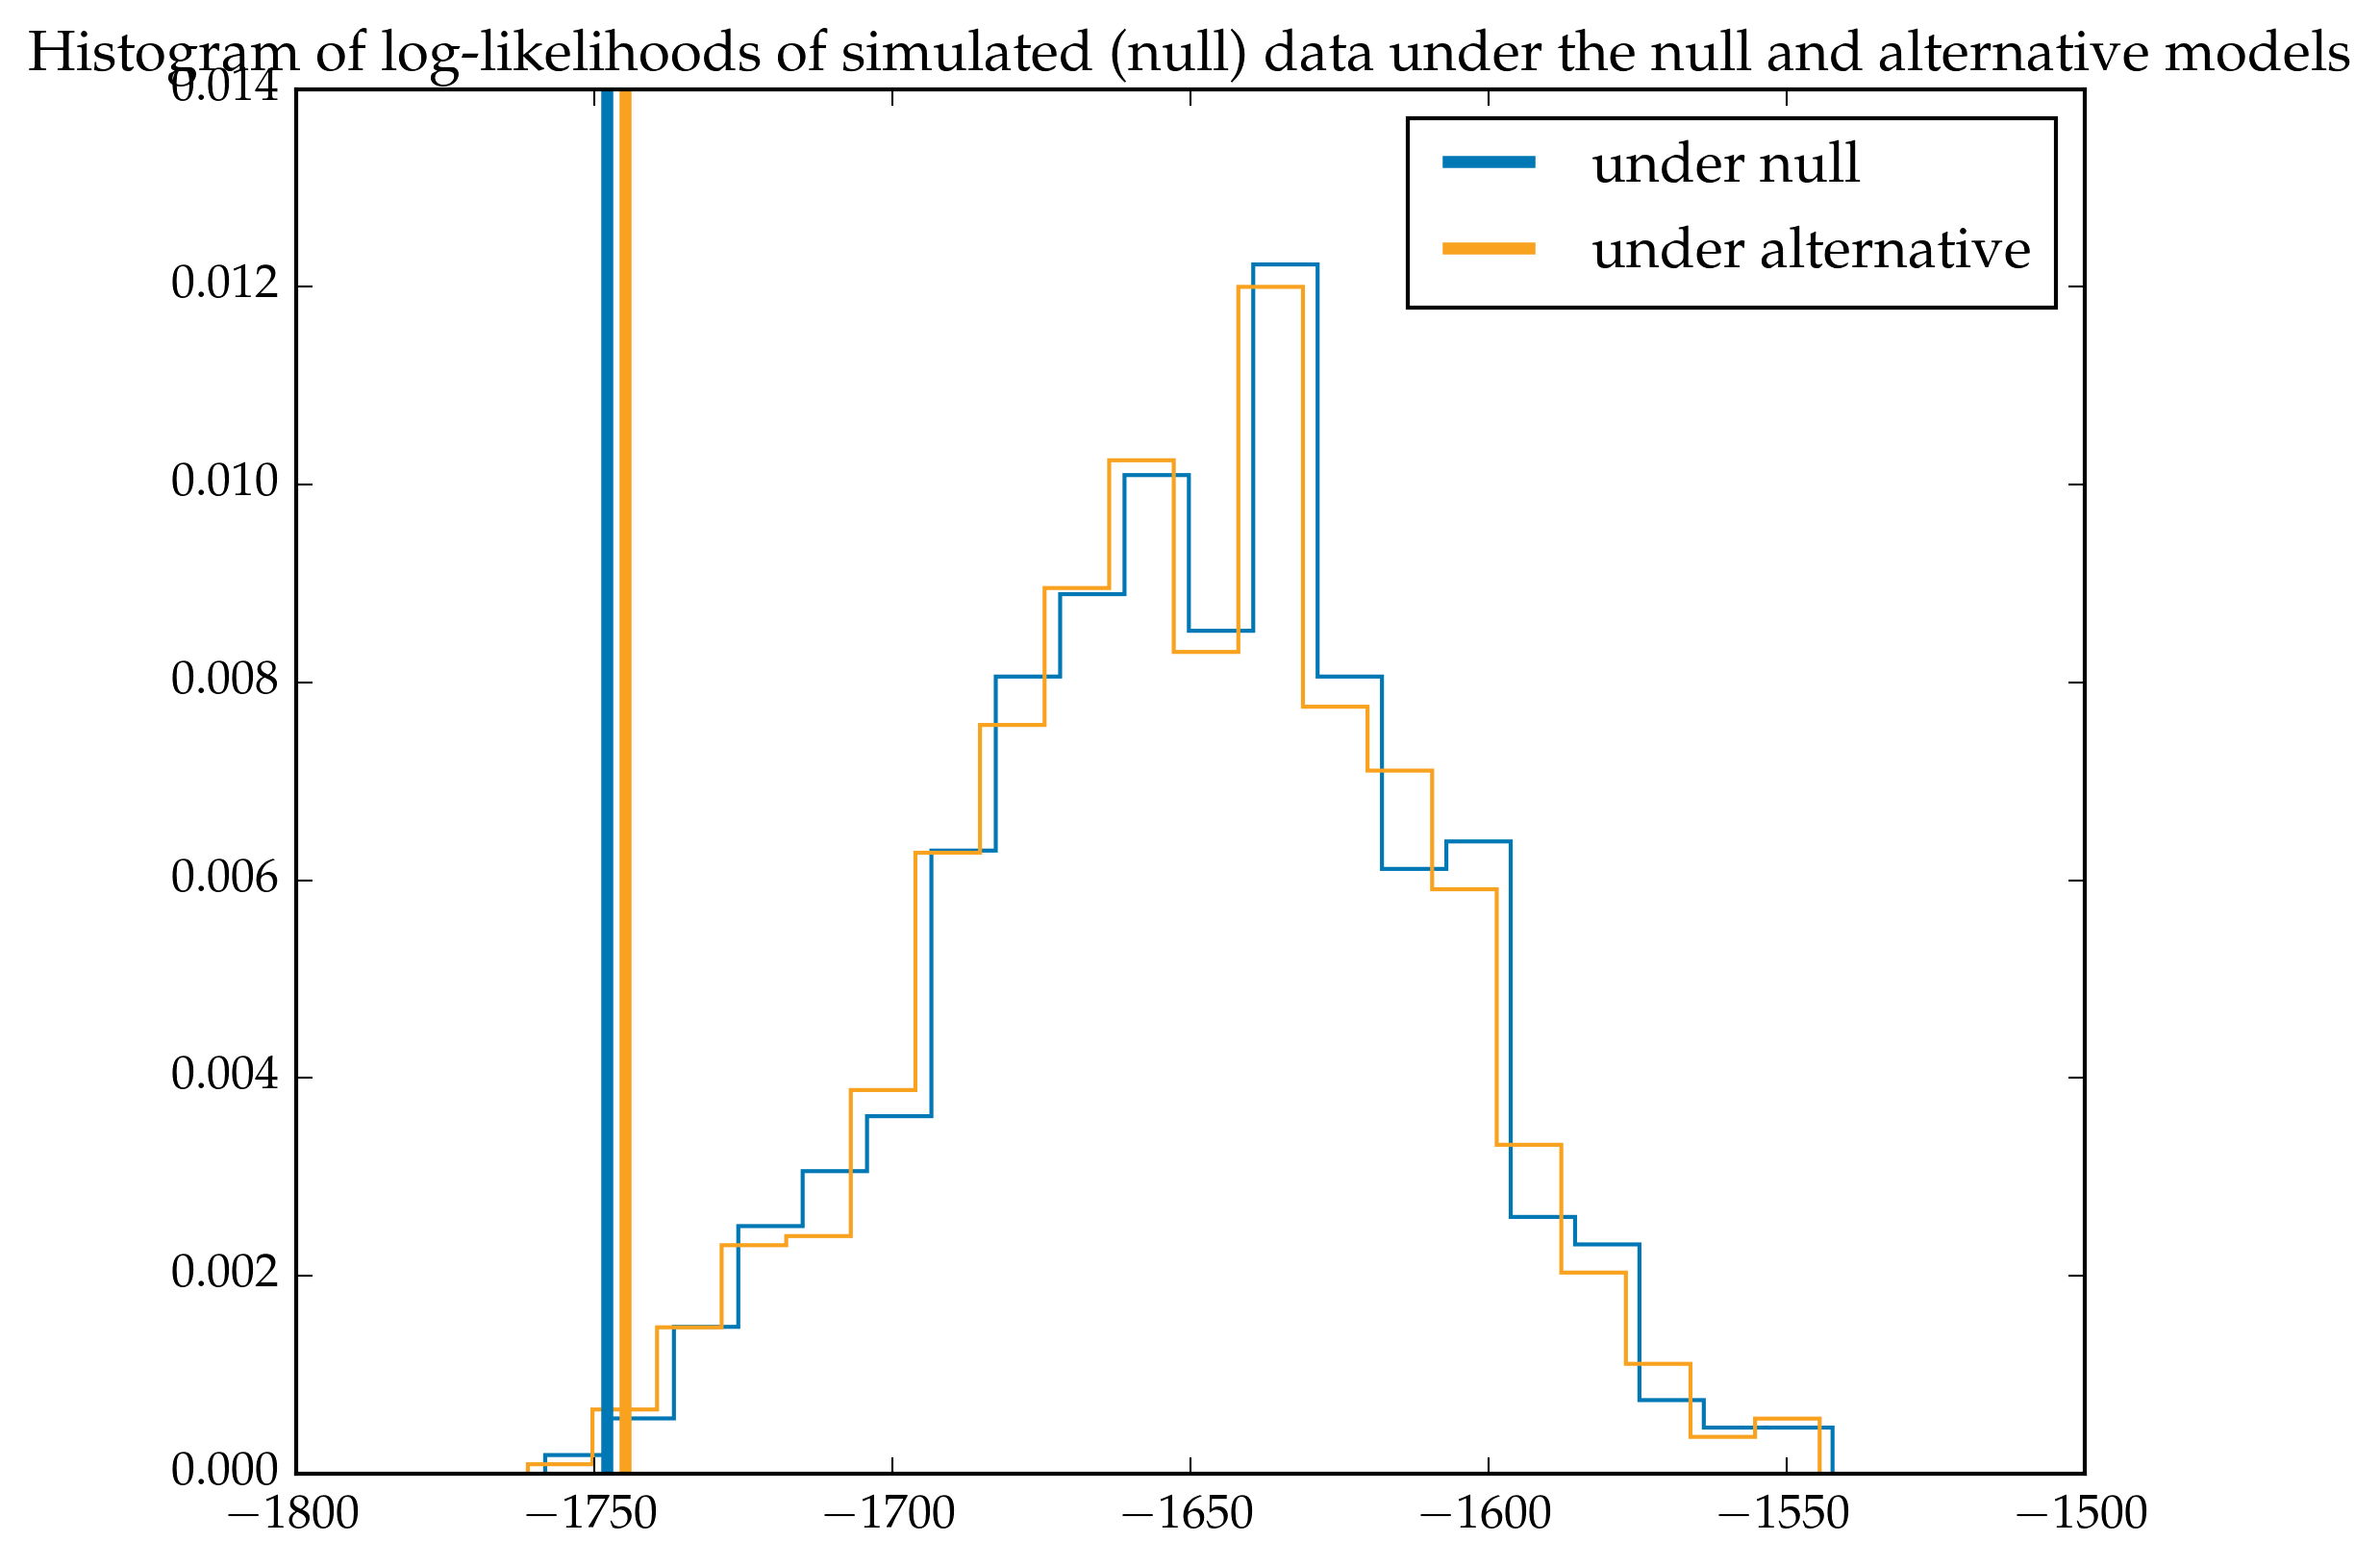

In [172]:
plt.plt[:hist](mLL_sim_null, normed=true, bins=20, color="#0078B5", histtype="step", linewidth=1)
plt.plt[:hist](mLL_sim_altv, normed=true, bins=20, color="#F8A21F", histtype="step", linewidth=1)
plt.axvline(mLL_null, color="#0078B5", label="under null", linewidth=3)
plt.axvline(mLL_altv, color="#F8A21F", label="under alternative", linewidth=3)
plt.legend()
plt.title("Histogram of log-likelihoods of simulated (null) data under the null and alternative models")
;

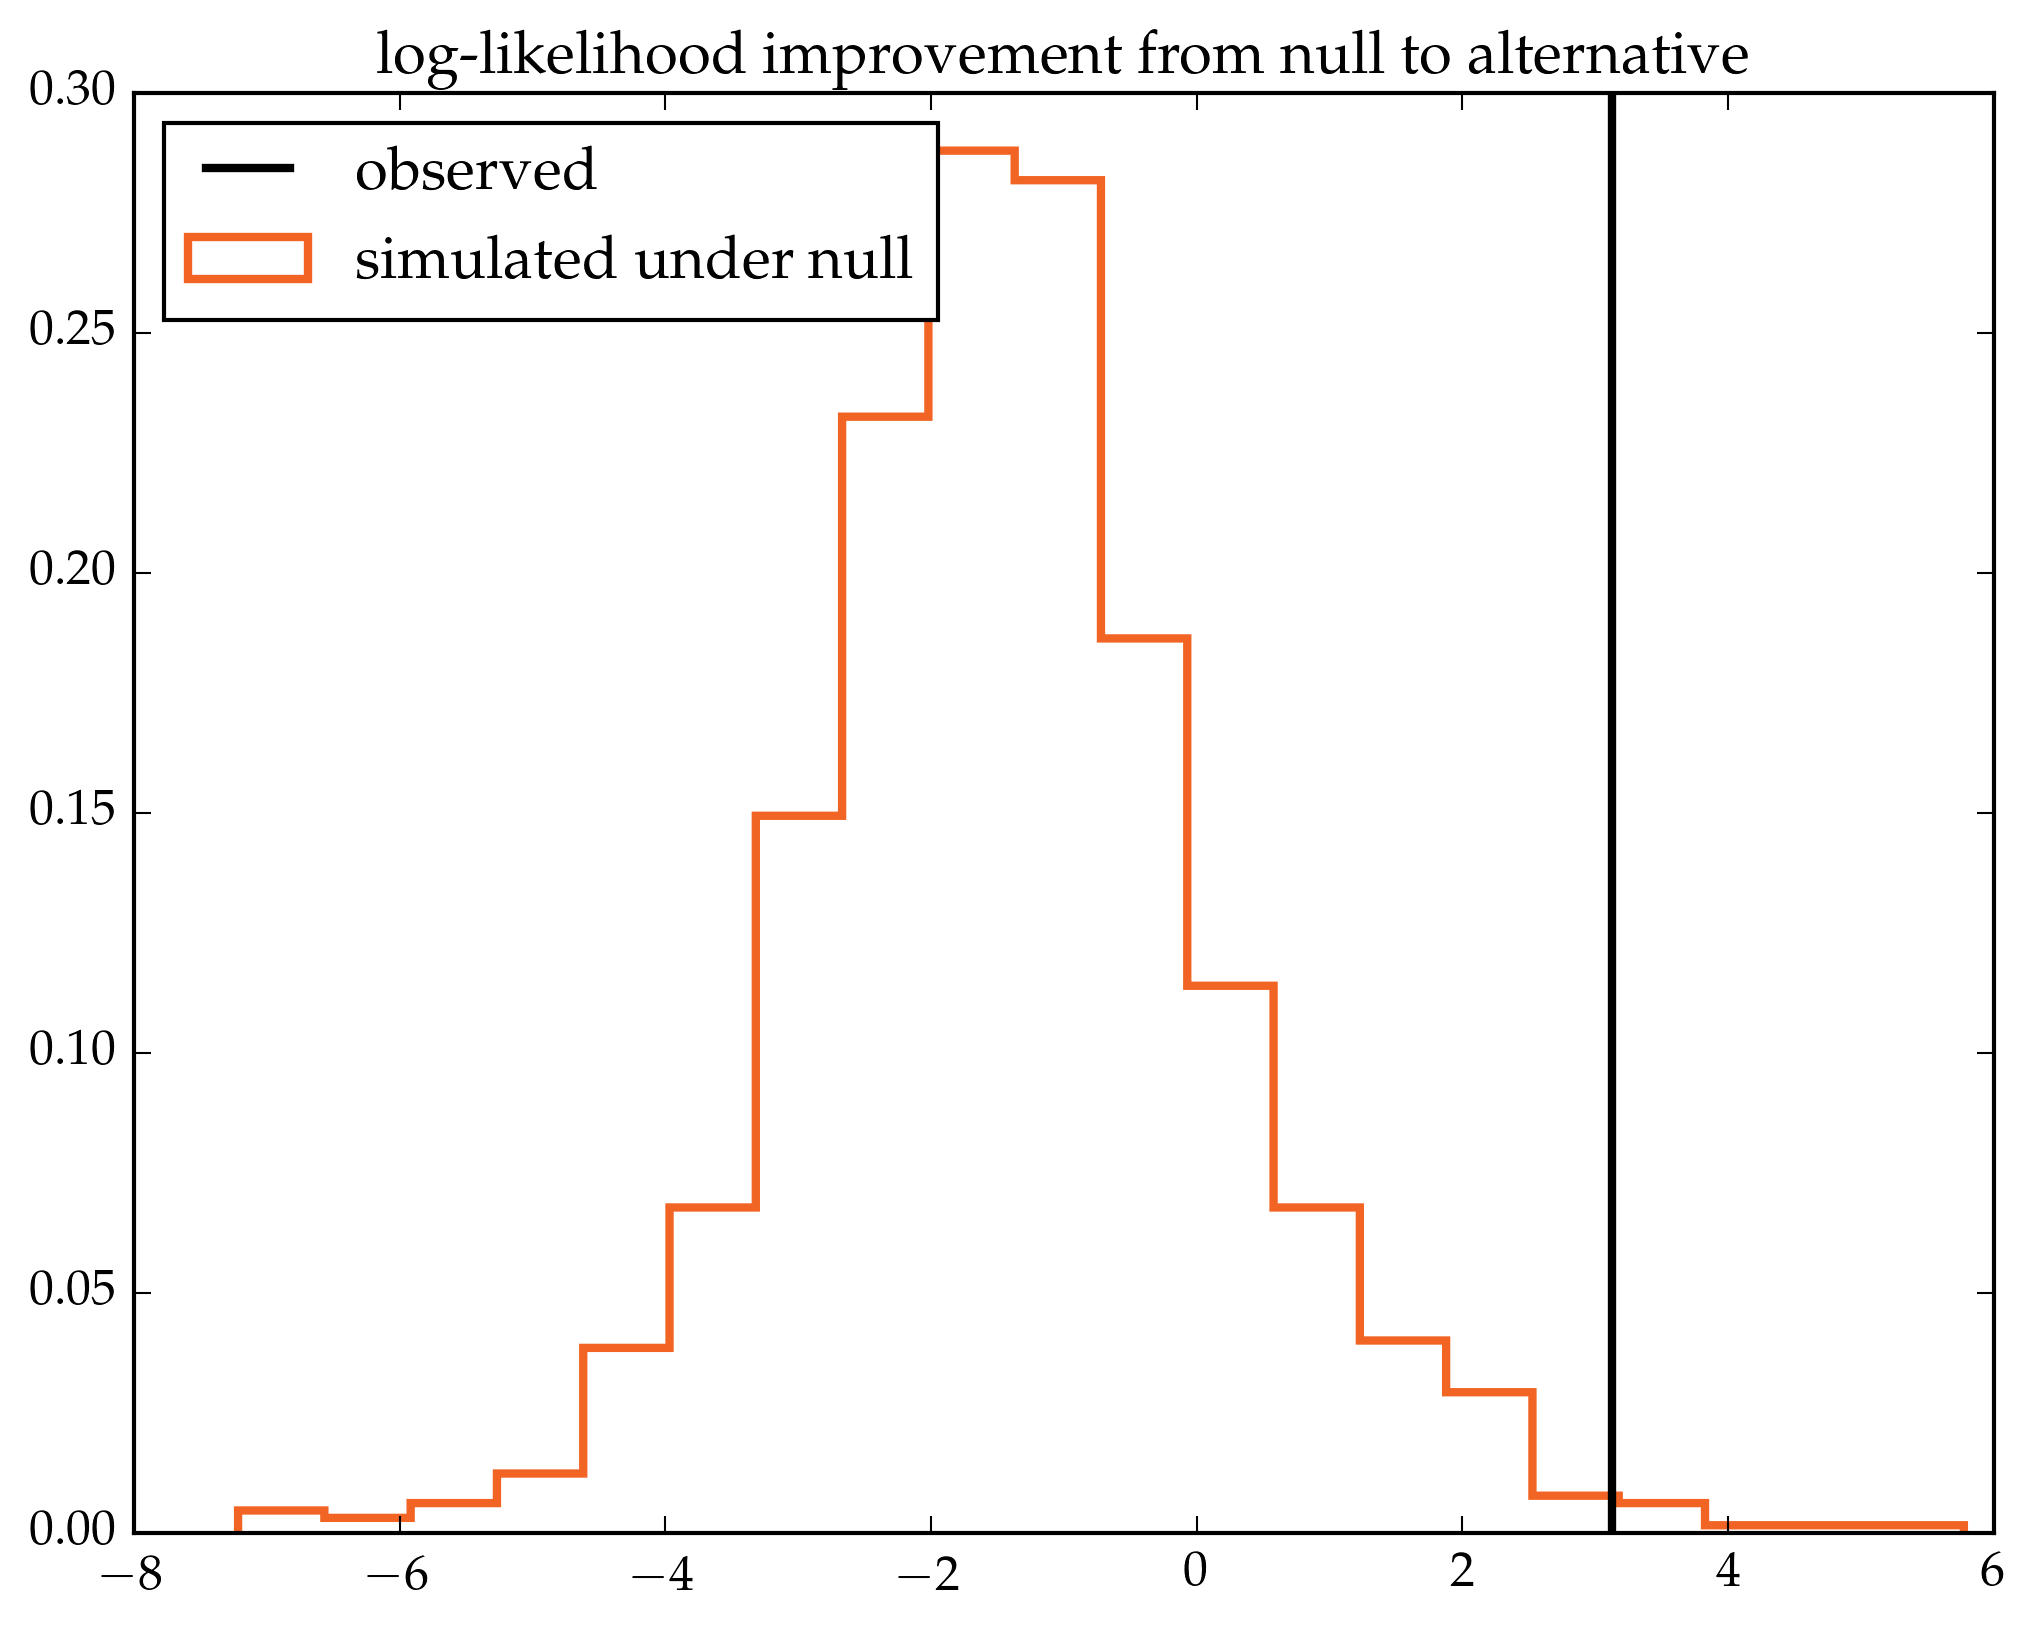

In [173]:
plt.plt[:hist](mLL_sim_altv.-mLL_sim_null, normed=true, bins=20, color="#F16424", histtype="step", linewidth=2, label="simulated under null")
plt.axvline(mLL_altv-mLL_null, color="black", label="observed", linewidth=2)
plt.legend(loc="best")
plt.title("log-likelihood improvement from null to alternative")
;

In [174]:
p_val_mLL = mean((mLL_sim_altv.-mLL_sim_null) .> (mLL_altv-mLL_null))
@printf("p-value of mLL parametric bootstrap test: %.3f", p_val_mLL)

p-value of mLL parametric bootstrap test: 0.008

### placebo test for mLL test

In [175]:
gpA=resid_GP_dict[distrA]
@time placebo_pvals_A = [GeoRDD.placebo_mLL(angle, 
    gpA.X, 
    gpA.y, 
    gpA.k, 
    gpA.logNoise, 
    1000;
    update_mean=true
    ) 
    for angle in 1.:2.:180.];

152.292867 seconds (10.21 M allocations: 8.819 GB, 5.74% gc time)


In [176]:
gpB=resid_GP_dict[distrB]
@time placebo_pvals_B = [GeoRDD.placebo_mLL(angle, 
    gpB.X, 
    gpB.y, 
    gpB.k, 
    gpB.logNoise, 
    1000;
    update_mean=true
    ) 
    for angle in 1.:2.:180.];

1175.

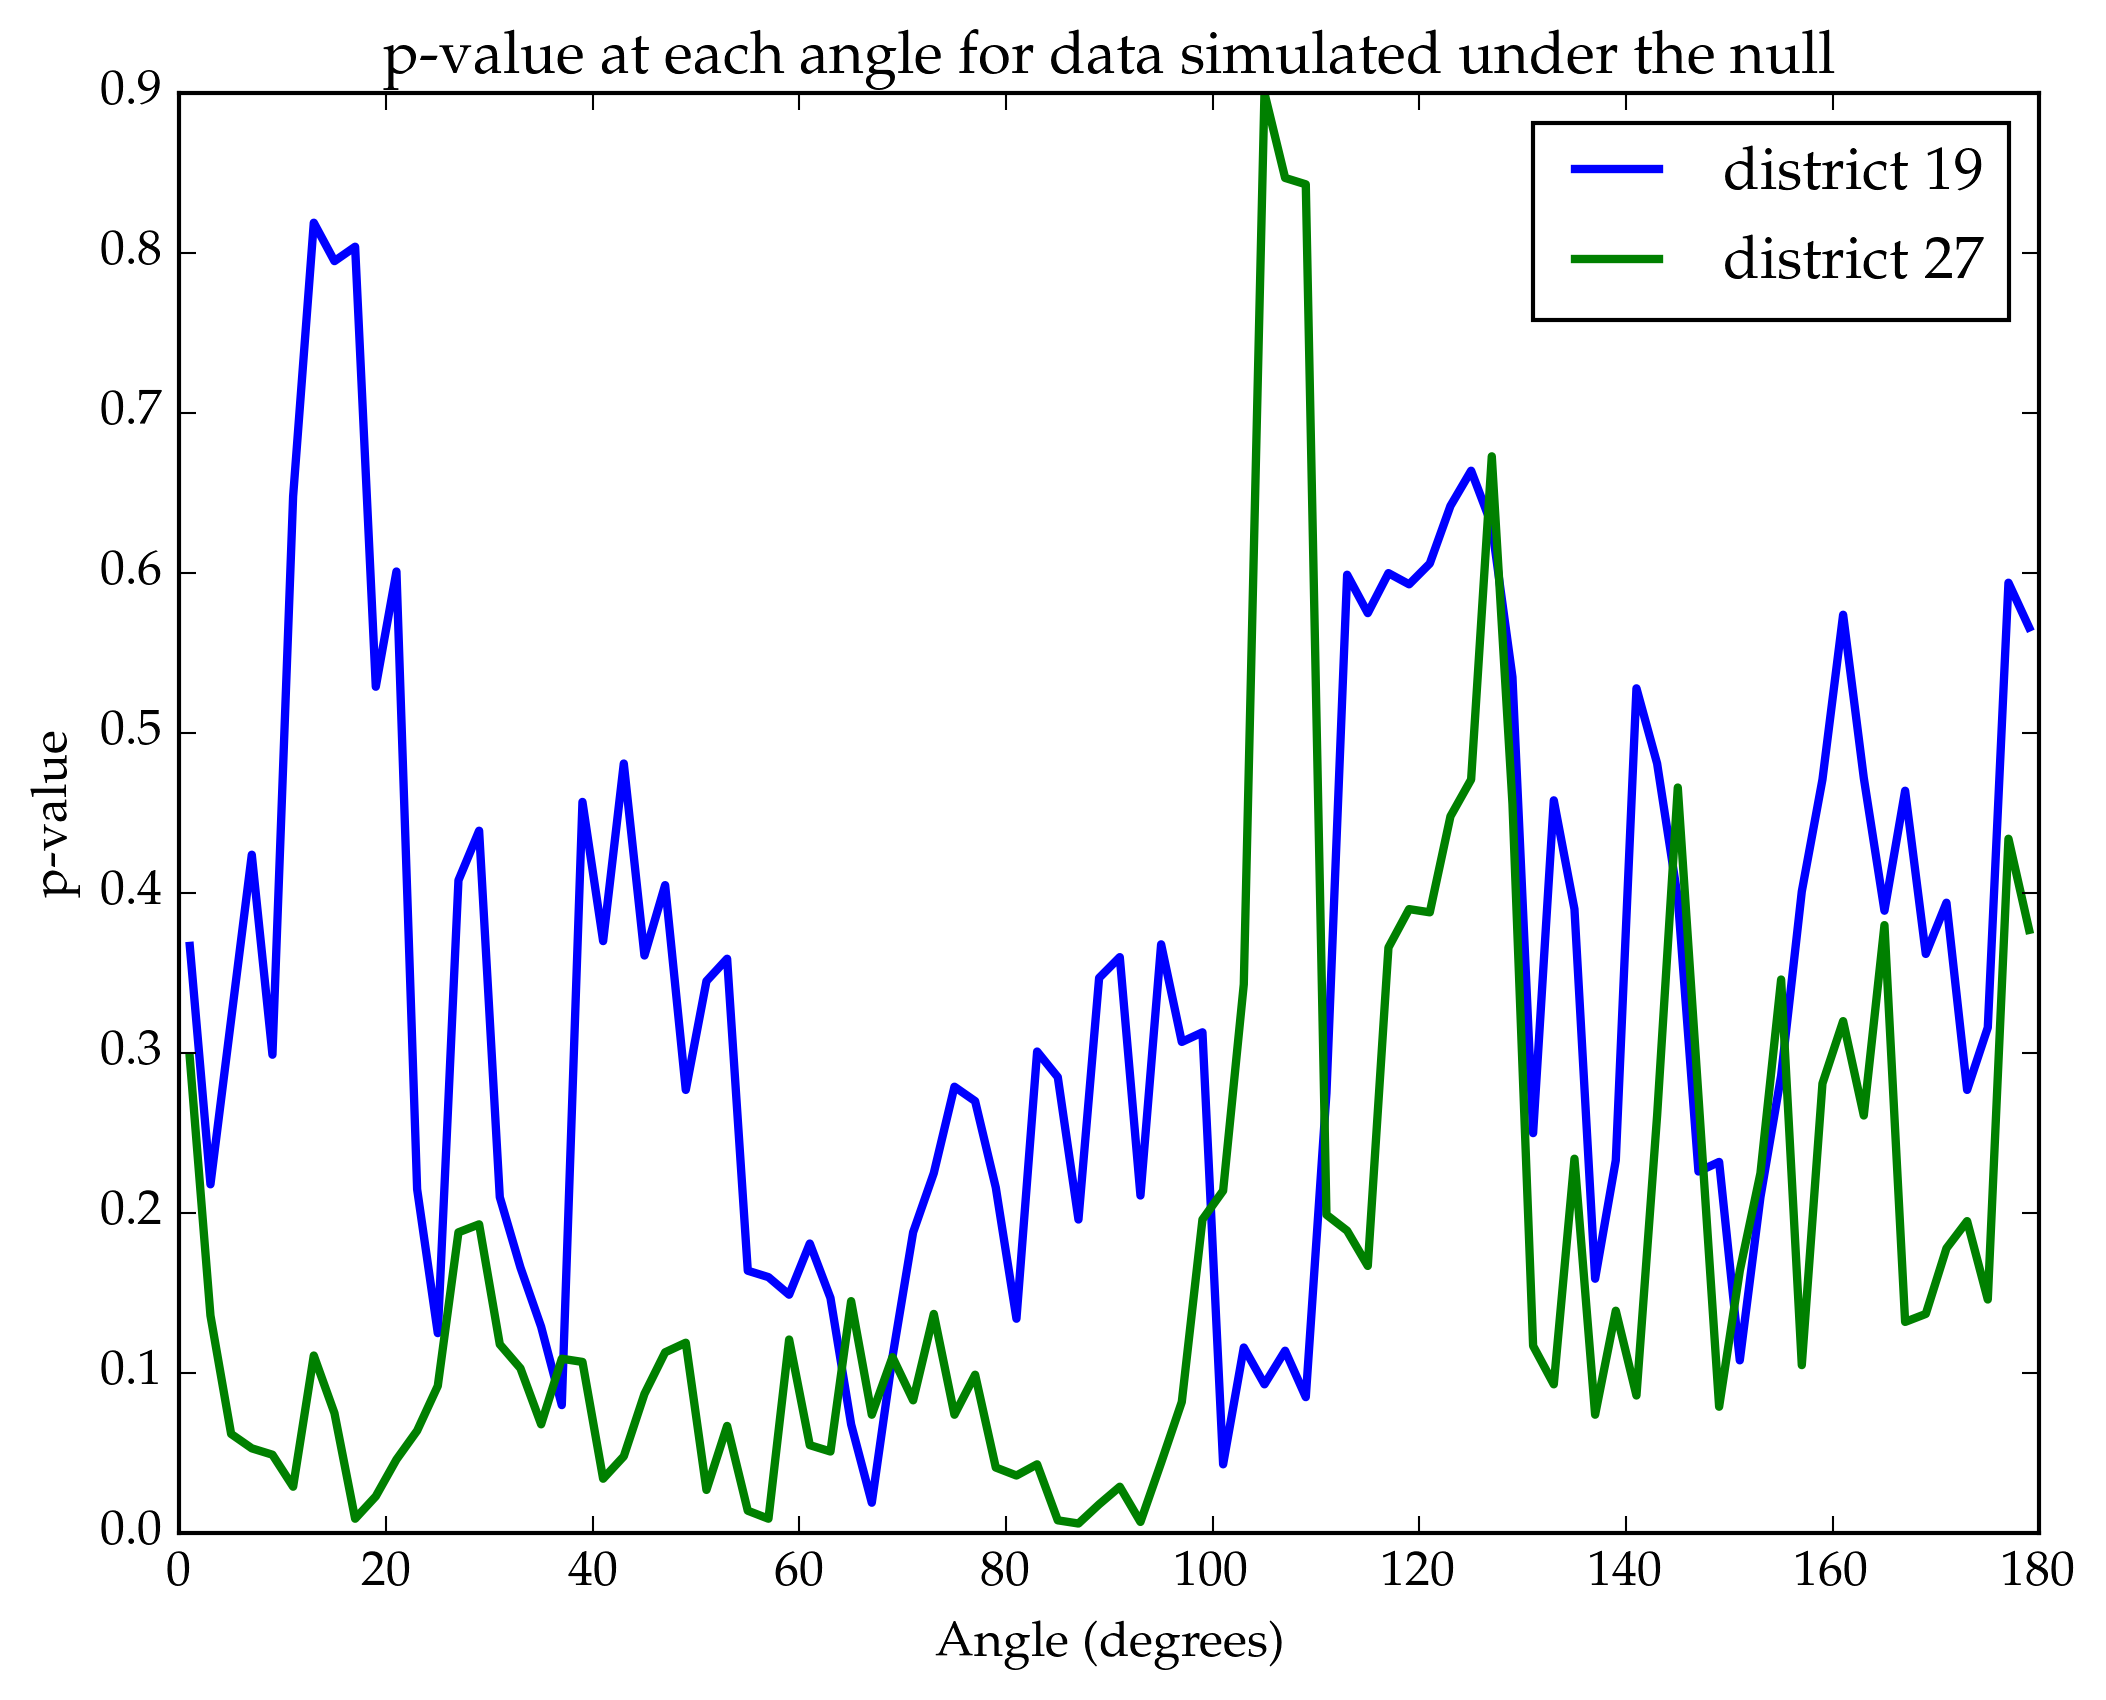

In [177]:
plt.plot(1:2:180, placebo_pvals_A, label=@sprintf("district %s", distrA), linewidth=2)
plt.plot(1:2:180, placebo_pvals_B, label=@sprintf("district %s", distrB), linewidth=2)
plt.xlabel("Angle (degrees)")
plt.ylabel("p-value")
plt.title("p-value at each angle for data simulated under the null")
plt.legend()
;

In [178]:
mean(placebo_pvals_A.<0.05),mean(placebo_pvals_B.<0.05)

(0.022222222222222223,0.2111111111111111)

In [179]:
mean(placebo_pvals_A.<p_val_mLL),mean(placebo_pvals_B.<p_val_mLL)

(0.0,0.022222222222222223)

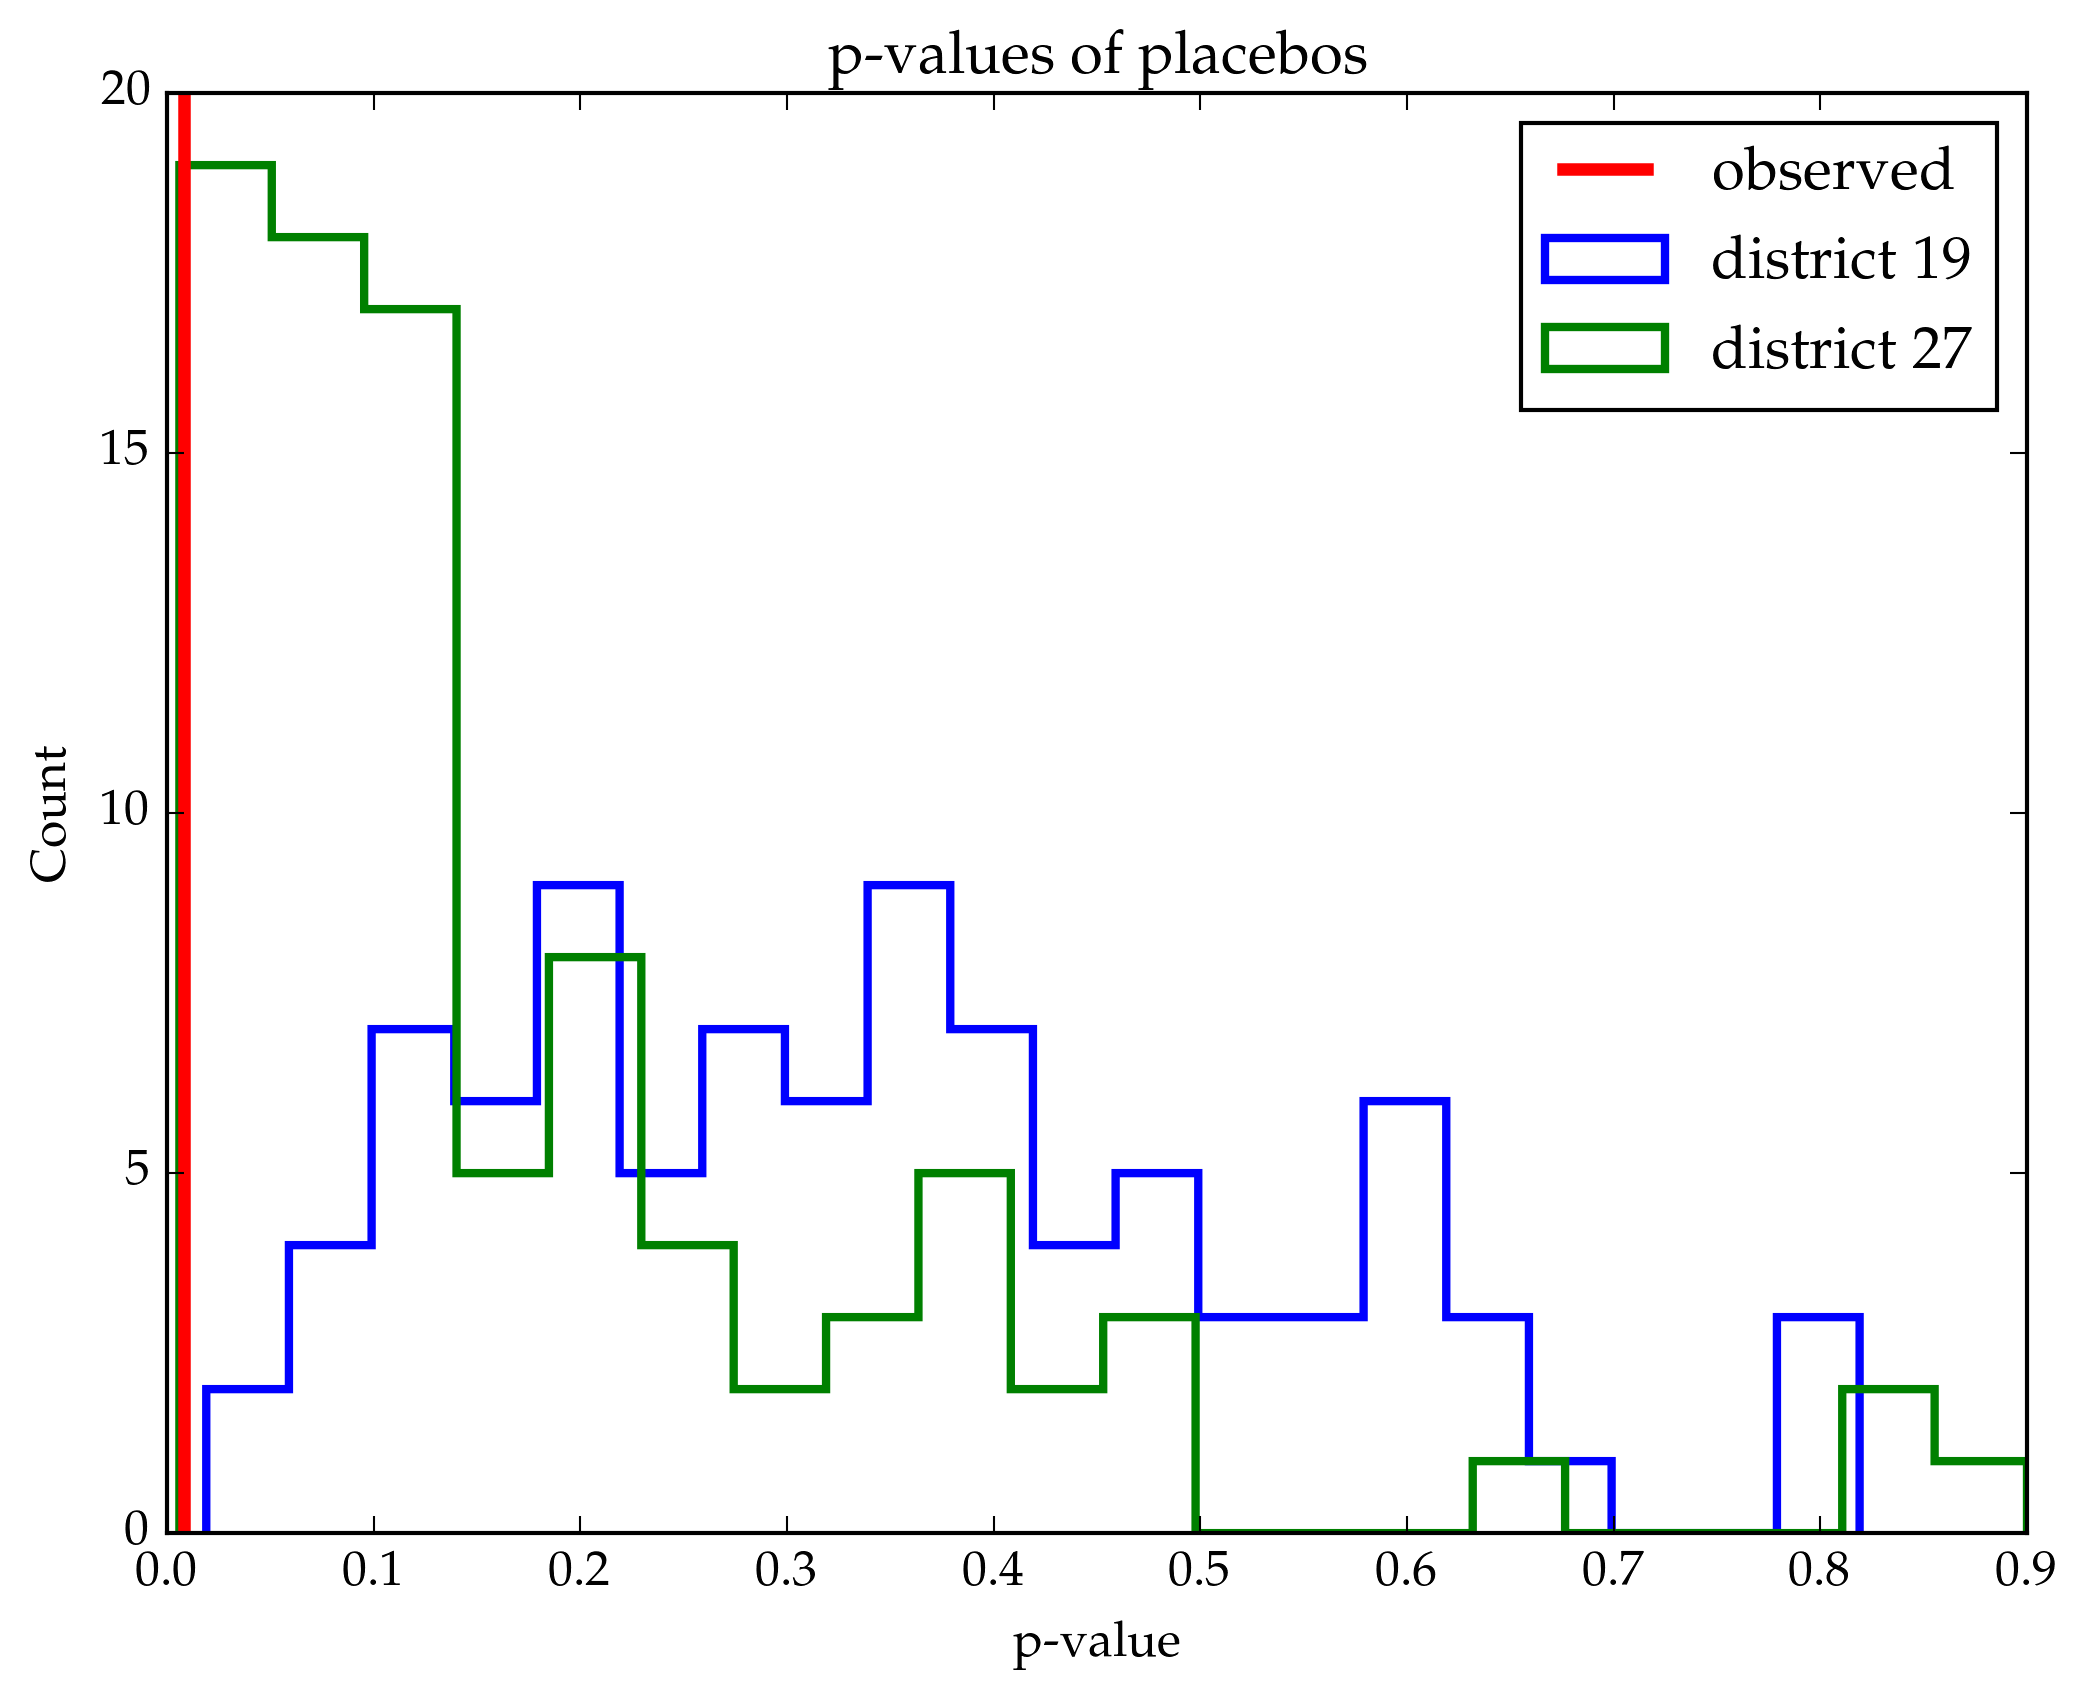

In [180]:
plt.plt[:hist](placebo_pvals_A, bins=20, linewidth=2, label=@sprintf("district %s", distrA), histtype="step")
plt.plt[:hist](placebo_pvals_B, bins=20, linewidth=2, label=@sprintf("district %s", distrB), histtype="step")
plt.axvline(p_val_mLL, color="red", label="observed", linewidth=3)
plt.legend(loc="upper right")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.title("p-values of placebos")
;

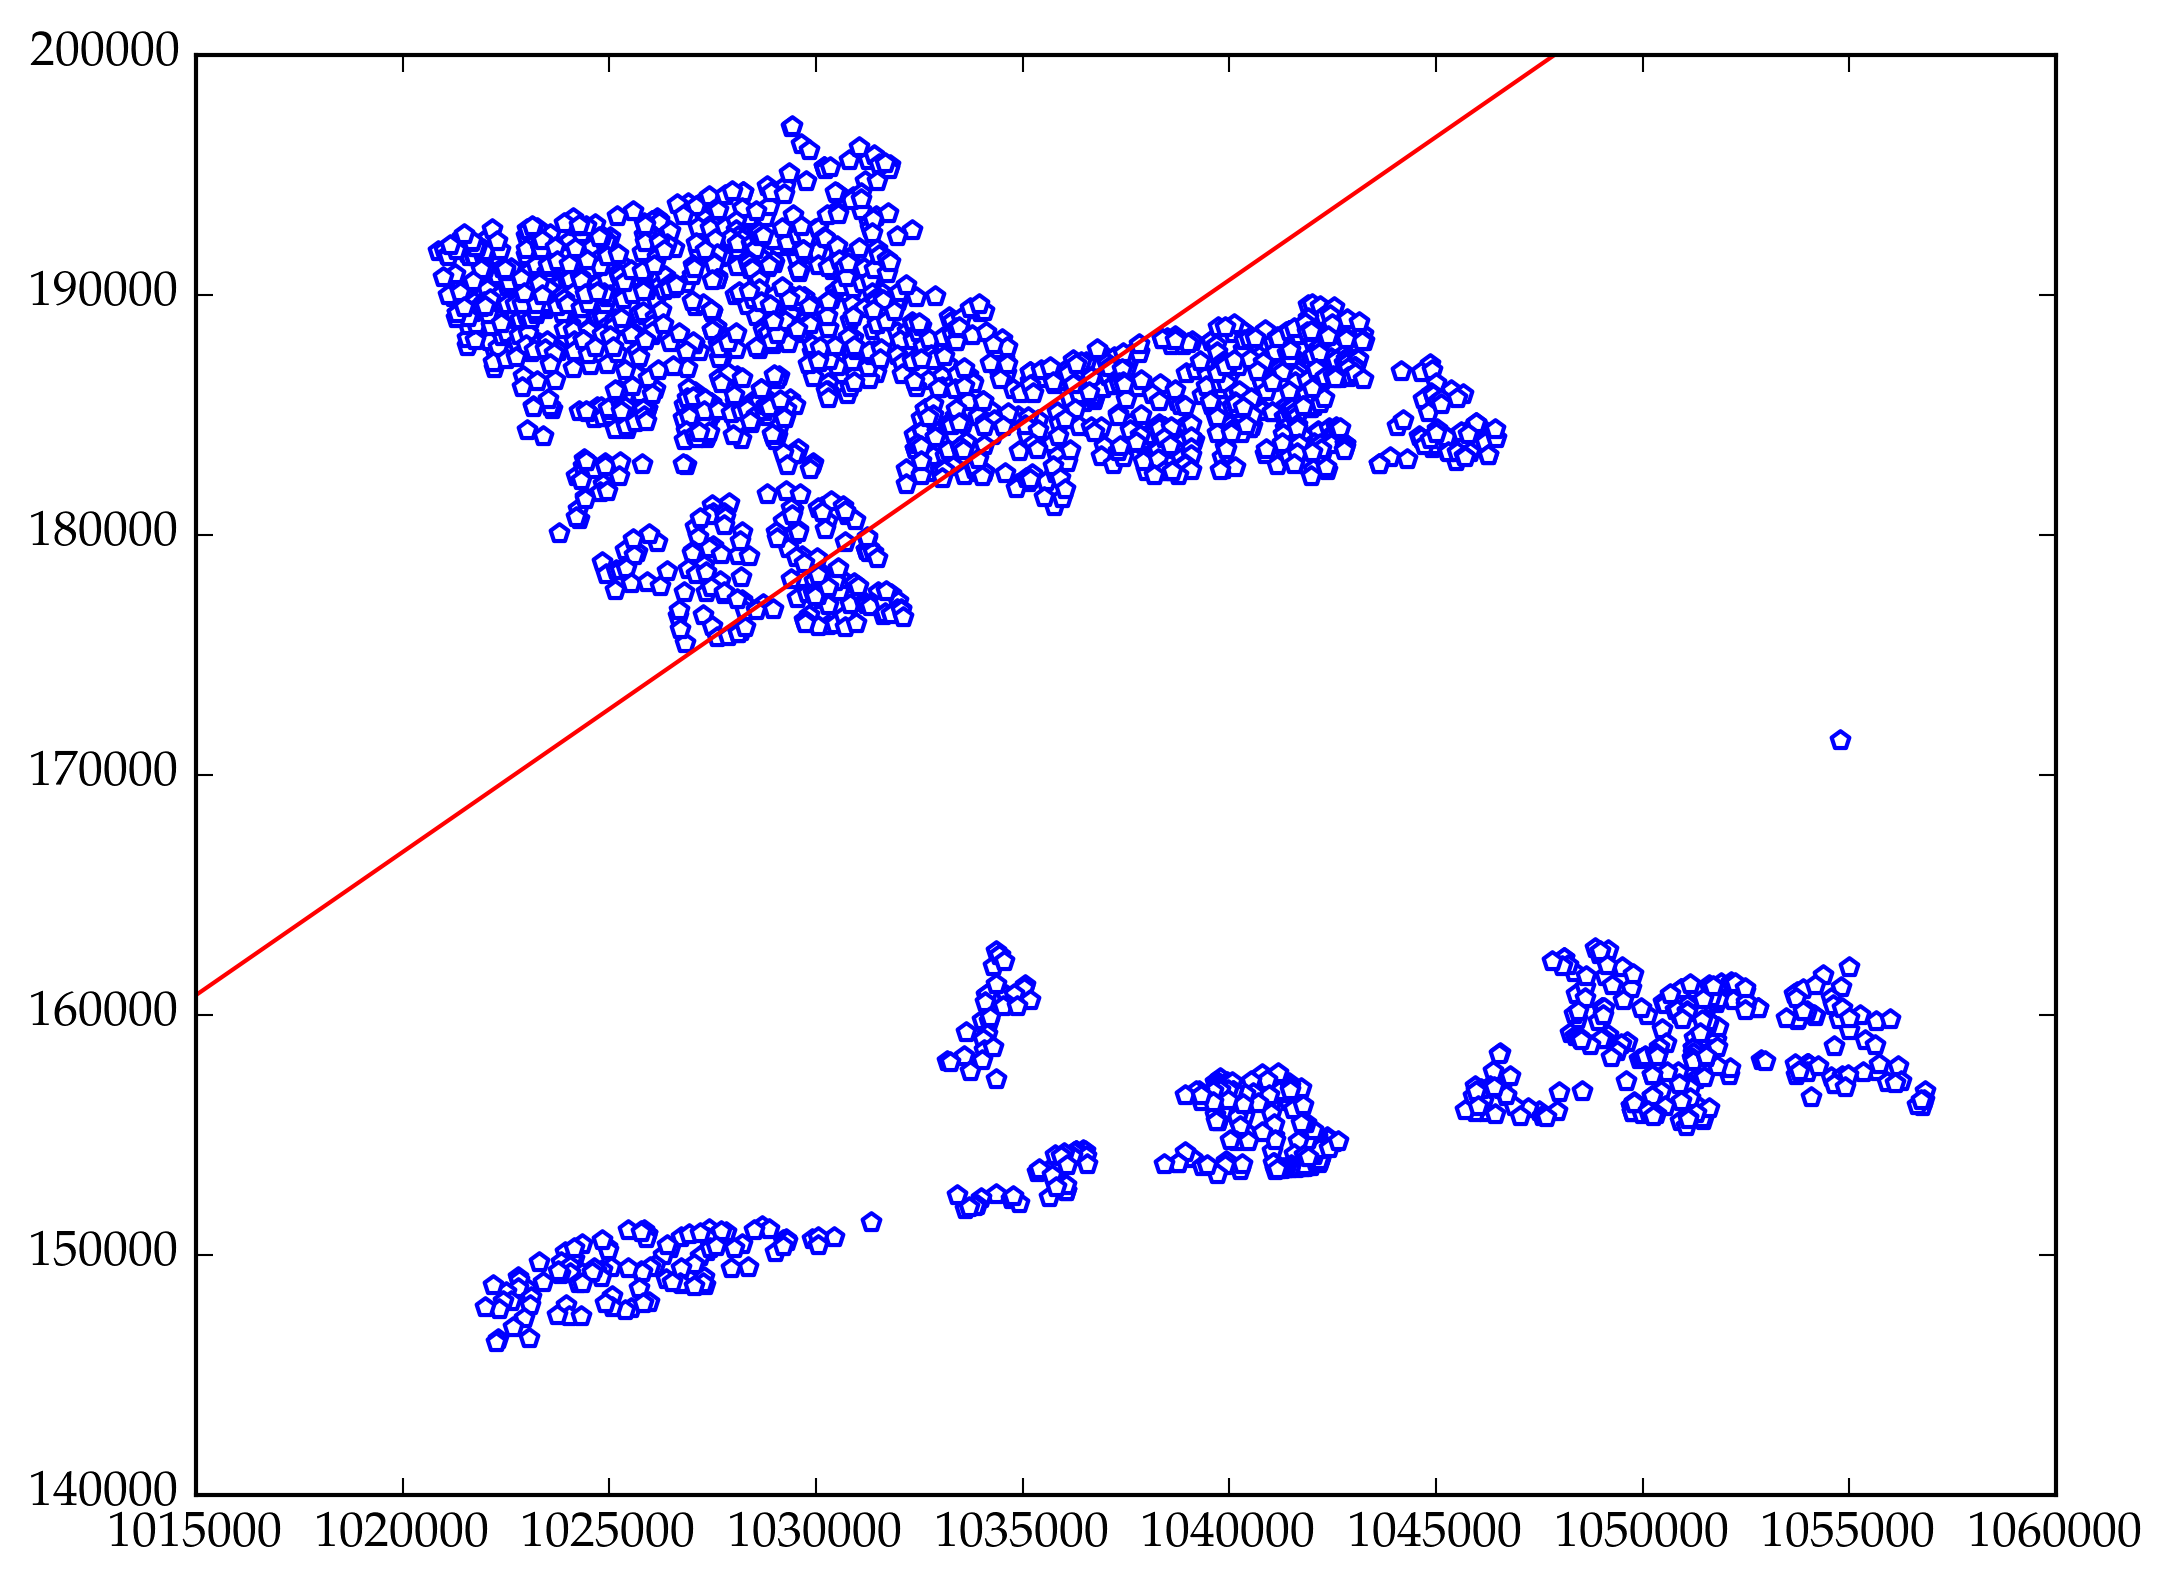

In [181]:
function plot_line(angle::Float64, shift::Float64, X::Matrix; kwargs...)
    meanx=mean(X[1,:])
    meany=mean(X[2,:])
    dydx=tand(angle)
    direction=sign(cosd(angle+90))
    if direction==0.0
        direction=1.0
    end
    shift_x = shift*cosd(angle+90)*direction
    shift_y = shift*sind(angle+90)*direction
    
    xlim=plt.xlim()
    ylim=plt.ylim()
    xlim_arr = Float64[xlim[1],xlim[2]]
    ylim_arr = Float64[ylim[1],ylim[2]]
    if dydx > 1e3
        plt.axvline(meanx+shift_x, color="red"; kwargs...)
    elseif dydx > 10
        plt.plot(meanx+(ylim_arr.-meany.-shift_y)./dydx+shift_x,ylim_arr; color="red", kwargs...)
    else
        plt.plot(xlim_arr,meany+(xlim_arr.-shift_x.-meanx).*dydx+shift_y; color="red", kwargs...)
    end
    plt.xlim(xlim)
    plt.ylim(ylim)
end
plt.scatter(gpB.X[1,:],gpB.X[2,:], color="white", edgecolor="blue", marker="p")
plot_line(50.0, GeoRDD.shift_for_even_split(50.0, gpB.X), gpB.X)
;

## Plot surface

In [49]:
# mean(Y_dict[distrA])-mean(Y_dict[distrB])

In [50]:
distrA

"19"

In [51]:
gridA = readcsv(
    @sprintf("NYC_data/processed/SchoolDistrict_grids/SchoolDistrict_grid_%s.csv", distrA), 
    header=false)
gridB = readcsv(
    @sprintf("NYC_data/processed/SchoolDistrict_grids/SchoolDistrict_grid_%s.csv", distrB), 
    header=false)

predgridA=GaussianProcesses.predict(resid_GP_dict[distrA], gridA'; full_cov=false)
predgridB=GaussianProcesses.predict(resid_GP_dict[distrB], gridB'; full_cov=false)

Xsent=hcat(sentinels[distrA,distrB].coordinates...)
predA_sent = GaussianProcesses.predict(resid_GP_dict[distrA], Xsent; full_cov=false)
predB_sent = GaussianProcesses.predict(resid_GP_dict[distrB], Xsent; full_cov=false)
;

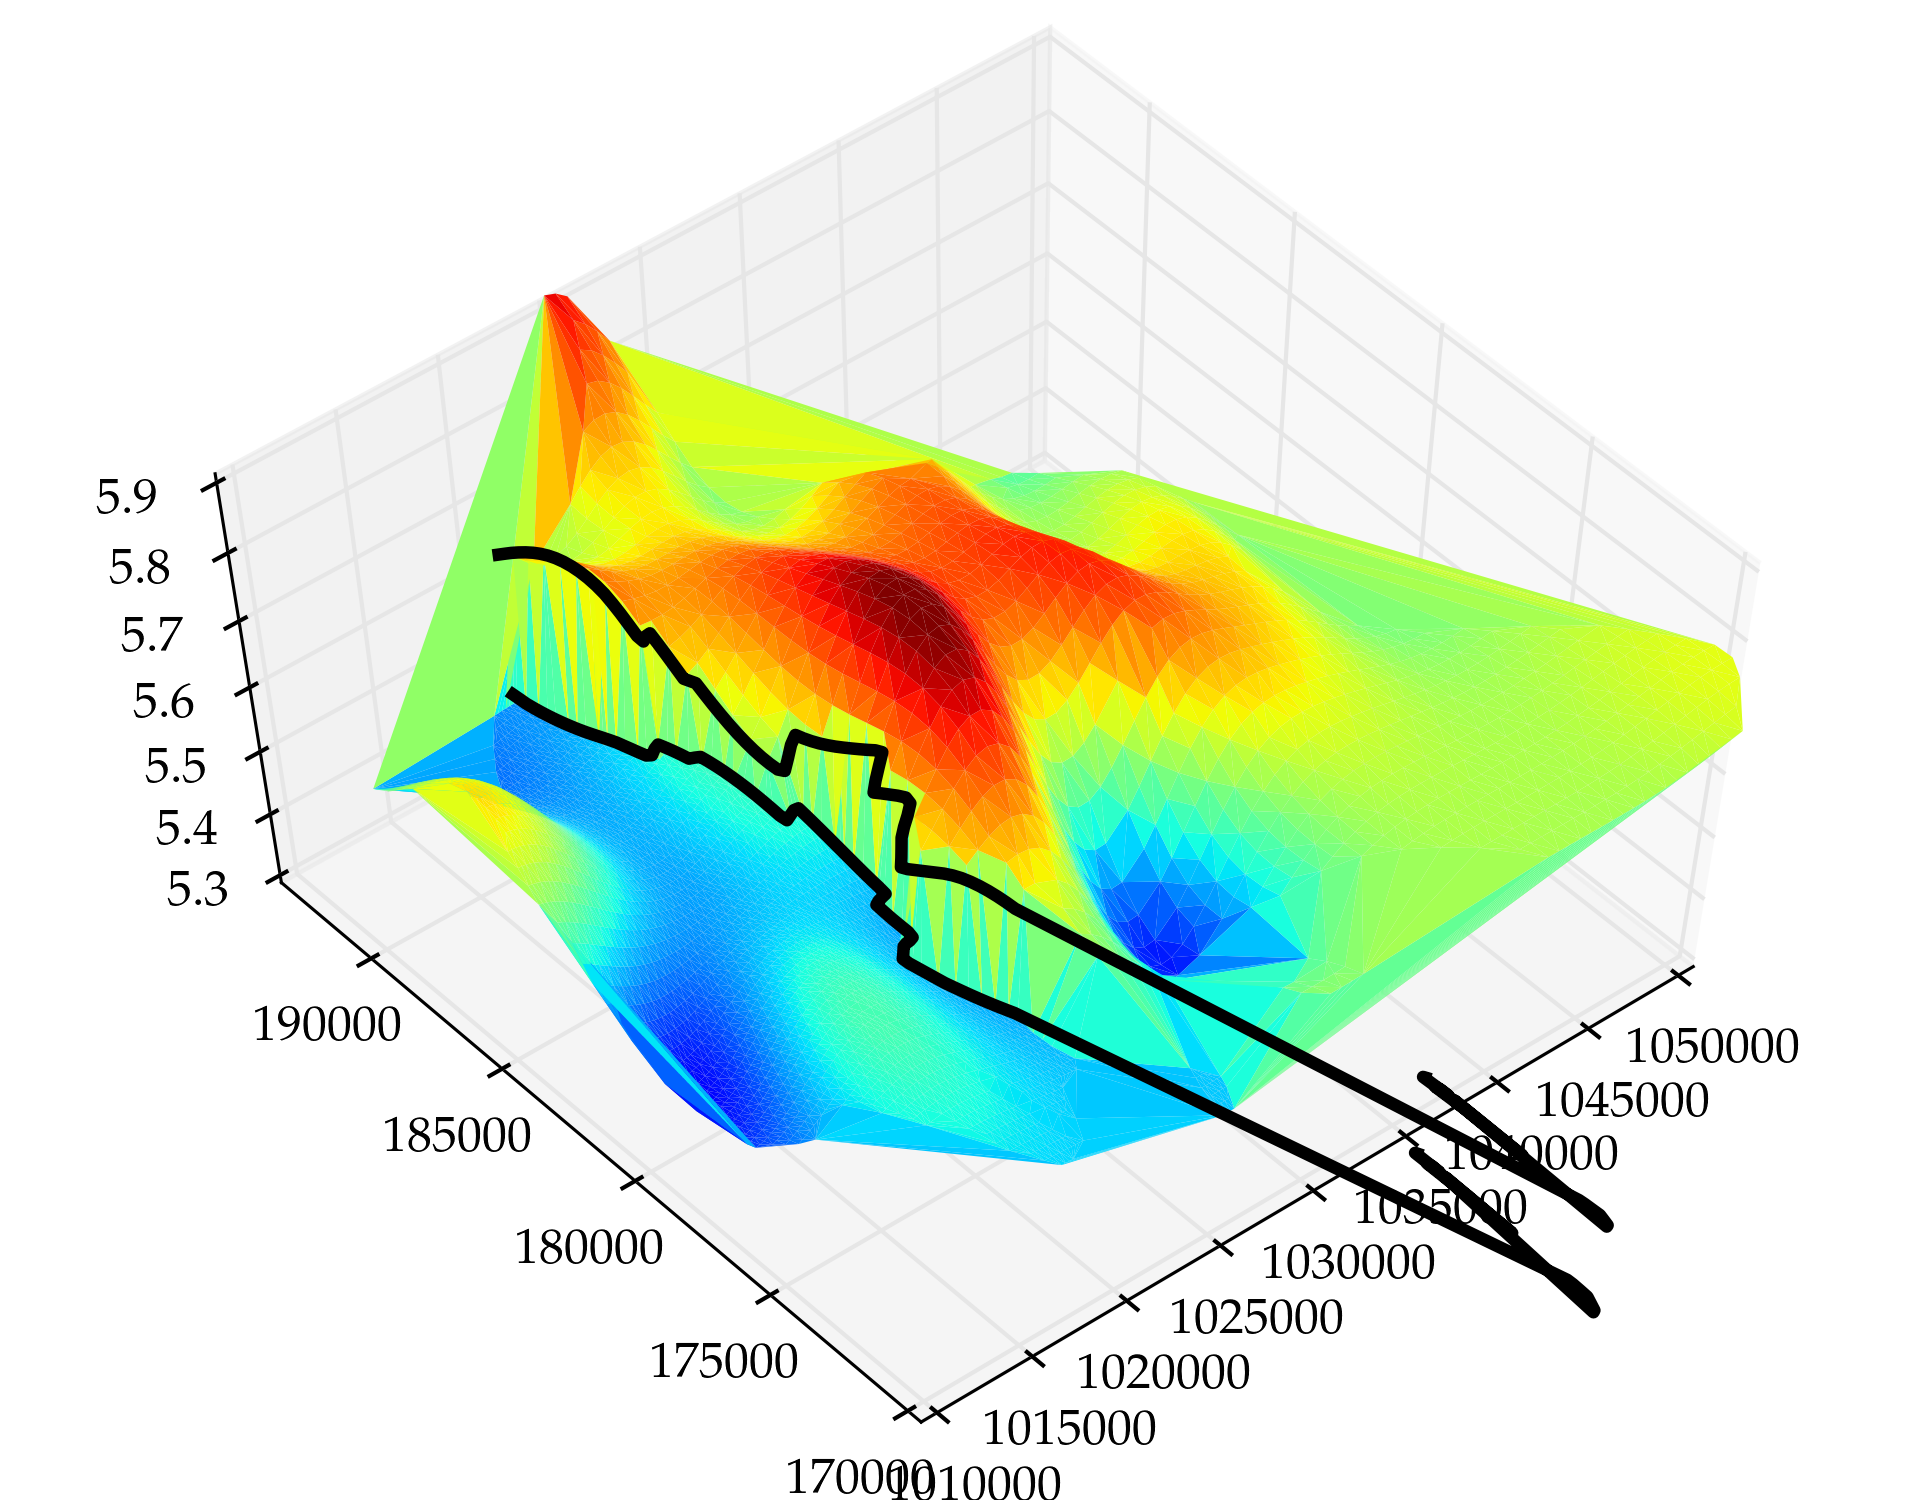

(170000.0,193000.0)

In [86]:
trisurf_X = [gridA[:,1];gridB[:,1]]
trisurf_Y = [gridA[:,2];gridB[:,2]]
trisurf_Z = [predgridA[1];predgridB[1]]
cutoff_Y = 1.7e5
trisurf_doplot = trisurf_Y .> cutoff_Y
plt.plot_trisurf(
    trisurf_X[trisurf_doplot], 
    trisurf_Y[trisurf_doplot], 
    trisurf_Z[trisurf_doplot], 
    linewidth=0, 
    cmap=plt.cm_get_cmap("jet"),
    vmin=minimum(predgridA[1]),
    vmin=5.3,
    vmax=5.8,
    )
plt.plot3D(Xsent[1,:], Xsent[2,:], predA_sent[1], color="black", linewidth=3)
plt.plot3D(Xsent[1,:], Xsent[2,:], predB_sent[1], color="black", linewidth=3)
ax=plt.gca()
ax[:view_init](elev=60, azim=230)
plt.xlim(1.01e6, 1.05e6)
plt.ylim(1.7e5, 1.93e5)

# Pairwise treatment effect

Beyond districts 19 and 27, I now look at every pair of contiguous NYC school districts, and compute the inverse-variance treatment effect. I then draw a map of all the district boundaries with the thickness of the boundaries drawn proportionally to the effect size $\E \tau/\sqrt{\V\tau}$. Boundaries with $\tau$ at least two standard deviations away from 0 are shown in black.

In [53]:
function get_τpost(gp_i::GP, gp_j::GP, sentinelX::Matrix)
    μ, Σ = GeoRDD.cliff_face(gp_i, gp_j, sentinelX)
    τpost = GeoRDD.inverse_variance(μ, Σ)
    return τpost
end 
;

In [54]:
τpost_pairs = Dict{Tuple{String,String},Normal}()
for (distrA,distrB) in keys(sentinels)
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    τpost = get_τpost(resid_GP_dict[distrA], resid_GP_dict[distrB], X◫)
    τpost_pairs[distrA,distrB] = τpost
end

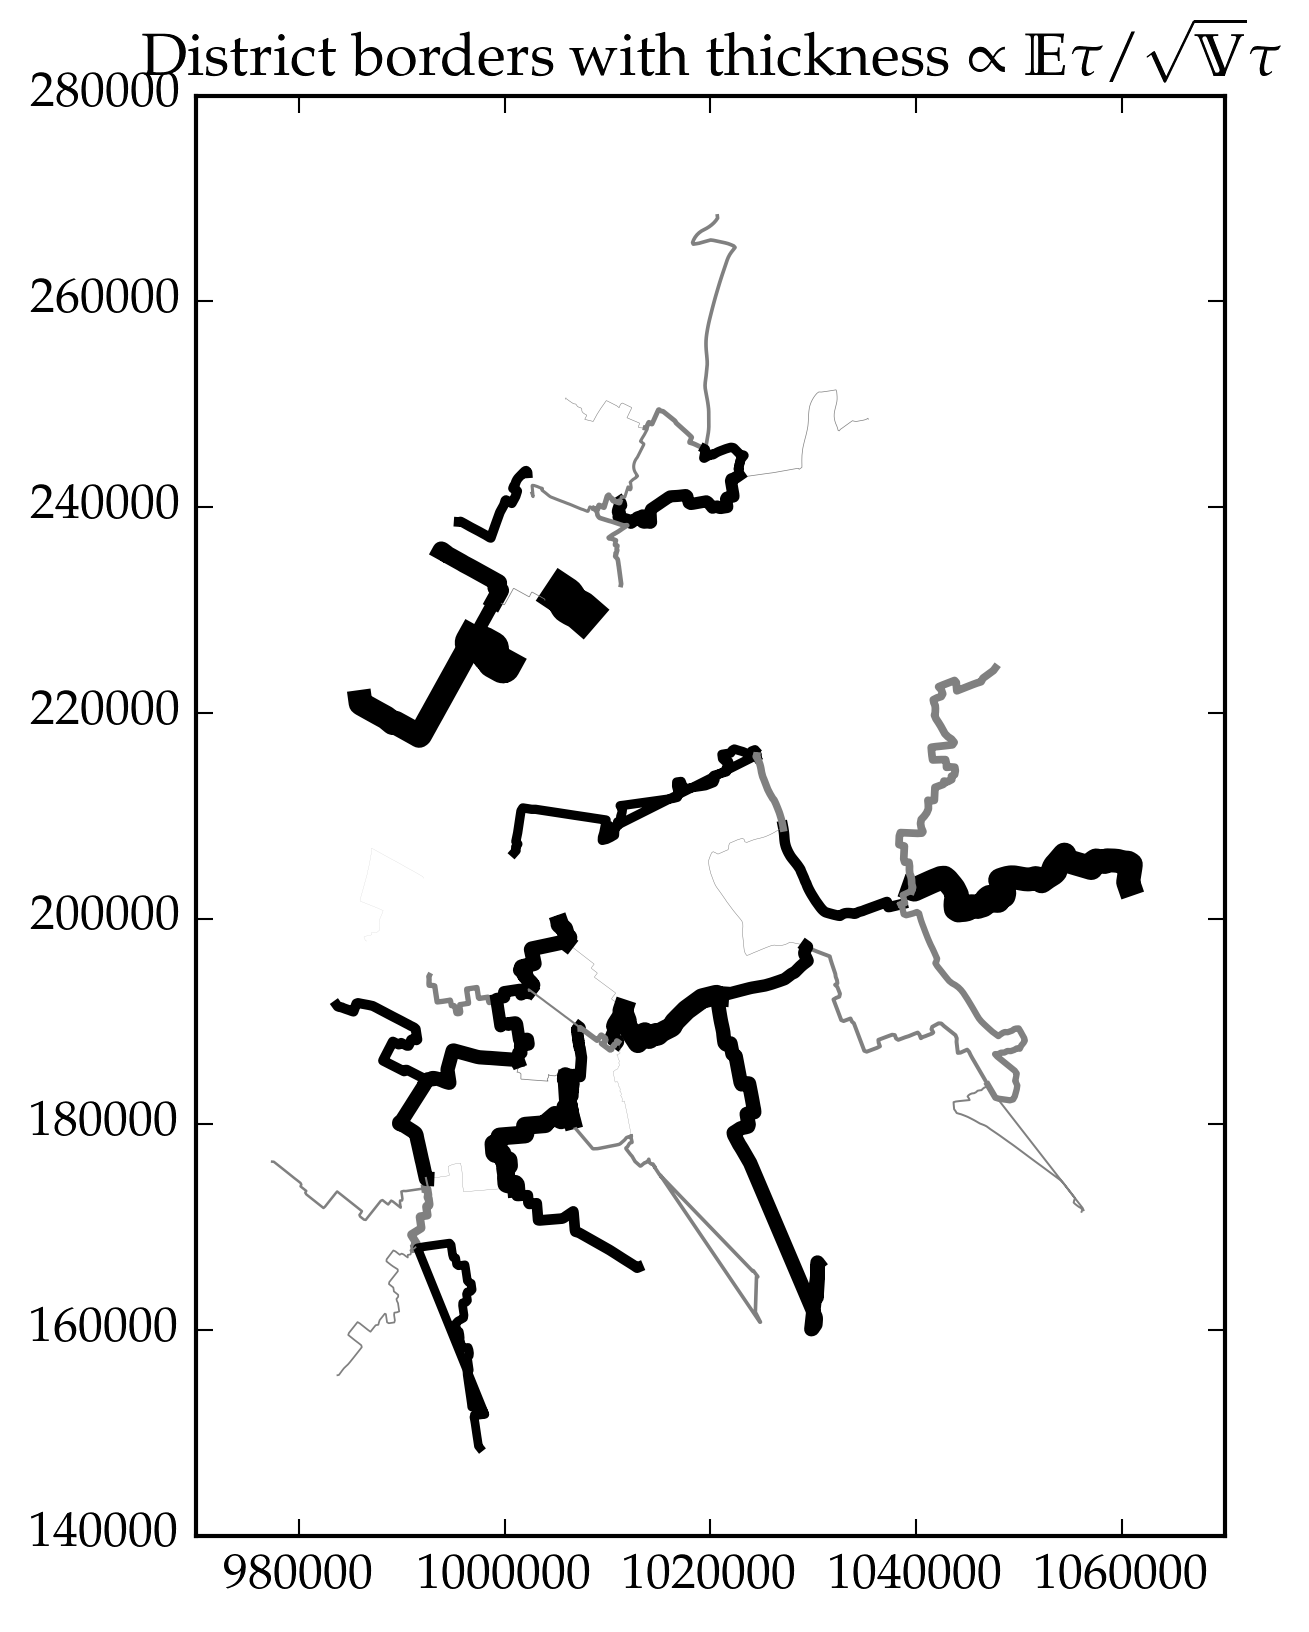

In [55]:
begin
    for distr_pair in keys(sentinels)
        distrA, distrB = distr_pair
        if distrA > distrB
            continue
        end
        X◫ = hcat(sentinels[distr_pair].coordinates...)

        τpost = τpost_pairs[distr_pair]
        eff_size = abs(mean(τpost)) / std(τpost)
        if eff_size > 2
            color="black"
        else
            color="gray"
        end
        plt.plot(X◫[1,:], X◫[2,:], linewidth=eff_size, color=color)
    end
    plt.gca()[:set_aspect]("equal")
    plt.title(L"District borders with thickness $\propto \mathbb{E}\tau/{\sqrt\mathbb{V}\tau}$ ")
end
;

# Next steps

* Fit hyperparameters on more districts than just the 27th
* Decide if this is a sufficiently convincing example to be used in the paper
* Revisit once we've implemented Bayesian inference on hyperparameters

# Optimizing hyperparameters using multiple districts

In [56]:
GP_dict=Dict{String, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
    GP_dict[name] = fit
end

In [57]:
module MGPCV
    using GaussianProcesses
    using PDMats
    using Optim
    include("../src/multigp_covars.jl")
end

MGPCV

## subset of districts

The entire dataset is too big to fit with a $\gp$, so let's subset to districts near the boundary we are focusing on.

In [58]:
local_distrs = ["18","19","23","24","25","26","27","28","29"]

local_indices = vcat(collect(schdistr_indices[distr] for distr in local_distrs)...)

mgpcv=MGPCV.MultiGPCovars(D_[local_indices,:], [GP_dict[distr] for distr in local_distrs], βkern_);

In [59]:
mgpcv.nobsv

10511

In [60]:
buf1 = zeros(mgpcv.nobsv, mgpcv.nobsv)
buf2 = zeros(mgpcv.nobsv, mgpcv.nobsv)
;

A single computation of the likelihood takes about 6 seconds, while computing the gradient takes about 30 seconds.

In [61]:
@time MGPCV.update_mll!(mgpcv)

  8.565258 seconds (297.89 k allocations: 13.124 MB)


-5647.831998367154

In [62]:
@time MGPCV.update_mll_and_dmll!(mgpcv, buf1, buf2, mean=false)

 45.215290 seconds (435.85 k allocations: 19.572 MB, 0.33% gc time)


4-element Array{Float64,1}:
 -1035.87  
   128.271 
    85.1567
    15.315 

In [63]:
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        kern=true,
        mean=false,
        beta=true,
        show_trace=true,
        iterations=10,
        x_tol=1e-3,
        f_tol=1e-3,
    )

Iter     Function value   Gradient norm 
     0     5.647832e+03     1.035867e+03
Base.LinAlg.PosDefException(3)
     1     5.618664e+03     1.186897e+02
     2     5.614136e+03     3.174705e+02
317.562648 seconds (943.88 k allocations: 1.702 GB, 0.35% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-0.8581931362917545,8.164711973741433, ...]
 * Minimizer: [-0.8955857025580327,8.21014641847168, ...]
 * Minimum: 5.614136e+03
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 1.0e-03: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 10
 * Gradient Calls: 7

The fitted hyperparameters are:

| Parameter      | Fitted Value                             |
|----------------|------------------------------------------|
| $\sigma_y$     | {{@sprintf("%.4f", exp(mgpcv.logNoise))}} |
| $\sigma_f$     | {{@sprintf("%.4f", √(mgpcv.k.σ2))}}        |
| $\sigma_\beta$ | {{@sprintf("%.4f", 1/√mgpcv.βkern.ℓ2)}}   |
| $\ell$ (feet)   | {{@sprintf("%.4f", √(mgpcv.k.ℓ2))}}       |

In [68]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

σ_y: 0.4239
σ_f: 0.1830
σ_β: 0.6170
ℓ: 3678.0810


It takes a few minutes to fit the hyperparameters. The fitted lengthscale isn't very different: 3700 feet $\approx$ 0.7 miles or 1.1 km. The other hyperparameters are relatively unchanged, which is reassuring.

# Get posterior mean $\beta$ using multiple districts

In [69]:
function spatial_cov(mgpcv::MGPCV.MultiGPCovars)
    cK = zeros(mgpcv.nobsv, mgpcv.nobsv)
    istart=0
    for gp in mgpcv.mgp
        addcov!(view(cK, istart+1:istart+gp.nobsv, istart+1:istart+gp.nobsv), mgpcv.k, gp.X, gp.data)
        istart += gp.nobsv
    end
    return cK
end

spatial_cov (generic function with 1 method)

In [70]:
function get_ΣYβ(mgpcv::MGPCV.MultiGPCovars)
    cK = spatial_cov(mgpcv)
    for i in 1:mgpcv.nobsv
        cK[i,i] += max(exp(2*mgpcv.logNoise),1e-8)
    end
    return PDMats.PDMat(cK)
end
;

In [71]:
function mean(mgpcv::MGPCV.MultiGPCovars)
    μ = Array(Float64, mgpcv.nobsv)
    istart=0
    for gp in mgpcv.mgp
        μ[istart+1:istart+gp.nobsv] = mean(mgpcv.m,gp.X)
        istart += gp.nobsv
    end
    return μ
end    

mean (generic function with 89 methods)

In [72]:
@time ΣY_β = get_ΣYβ(mgpcv);

  7.871736 seconds (9.64 k allocations: 1.647 GB, 5.45% gc time)


In [73]:
tmp = PDMats.X_invA_Xt(ΣY_β, mgpcv.D')
for i in 1:p
    tmp[i,i] += mgpcv.βkern.ℓ2
end

In [74]:
m = mean(mgpcv);

In [75]:
βhat = (tmp \ mgpcv.D') * (ΣY_β \ (mgpcv.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))

Dict{String,Float64} with 24 entries:
  "BUILDING_CLASS_AT_TIME_OF_SALE: A0" => 0.26439
  "BUILDING_CLASS_AT_TIME_OF_SALE: C6" => 0.0
  "TAX_CLASS_AT_TIME_OF_SALE: 1.0"     => 0.14053
  "BUILDING_CLASS_AT_TIME_OF_SALE: A4" => 0.149221
  "BUILDING_CLASS_AT_TIME_OF_SALE: A1" => 0.076876
  "BUILDING_CLASS_AT_TIME_OF_SALE: A2" => 0.244608
  "BUILDING_CLASS_AT_TIME_OF_SALE: A6" => -0.0629459
  "BUILDING_CLASS_AT_TIME_OF_SALE: B9" => -0.102415
  "BUILDING_CLASS_AT_TIME_OF_SALE: A9" => 0.115562
  "BUILDING_CLASS_AT_TIME_OF_SALE: A7" => 0.108018
  "BUILDING_CLASS_AT_TIME_OF_SALE: A5" => 0.0923987
  "BUILDING_CLASS_AT_TIME_OF_SALE: S0" => -0.255008
  "BUILDING_CLASS_AT_TIME_OF_SALE: S2" => -0.237699
  "BUILDING_CLASS_AT_TIME_OF_SALE: A8" => 0.0
  "(Intercept)"                        => 0.14053
  "BUILDING_CLASS_AT_TIME_OF_SALE: B1" => -0.0988431
  "BUILDING_CLASS_AT_TIME_OF_SALE: D0" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: S1" => -0.0240806
  "TAX_CLASS_AT_TIME_OF_SALE: 2.0"     => 0.0
  "BUI

In [76]:
writetable("betahat.csv", sort(DataFrame(key=coefnames(mf), val=βhat)))

## Fit residuals with new $\hat\beta$ and hyperparameters

In [130]:
resid = for_mm[:logSalePricePerSQFT].values - D_*βhat
resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

In [131]:
resid_GP_dict_multi=Dict{String, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), mgpcv.k, mgpcv.logNoise)
    resid_GP_dict_multi[name] = fit
end

In [132]:
distrA,distrB="19","27"
resid_μposterior, resid_Σposterior = GeoRDD.cliff_face(resid_GP_dict_multi[distrA], 
                                                resid_GP_dict_multi[distrB],
                                                hcat(sentinels[distrA,distrB].coordinates...))
;

### cliff-face

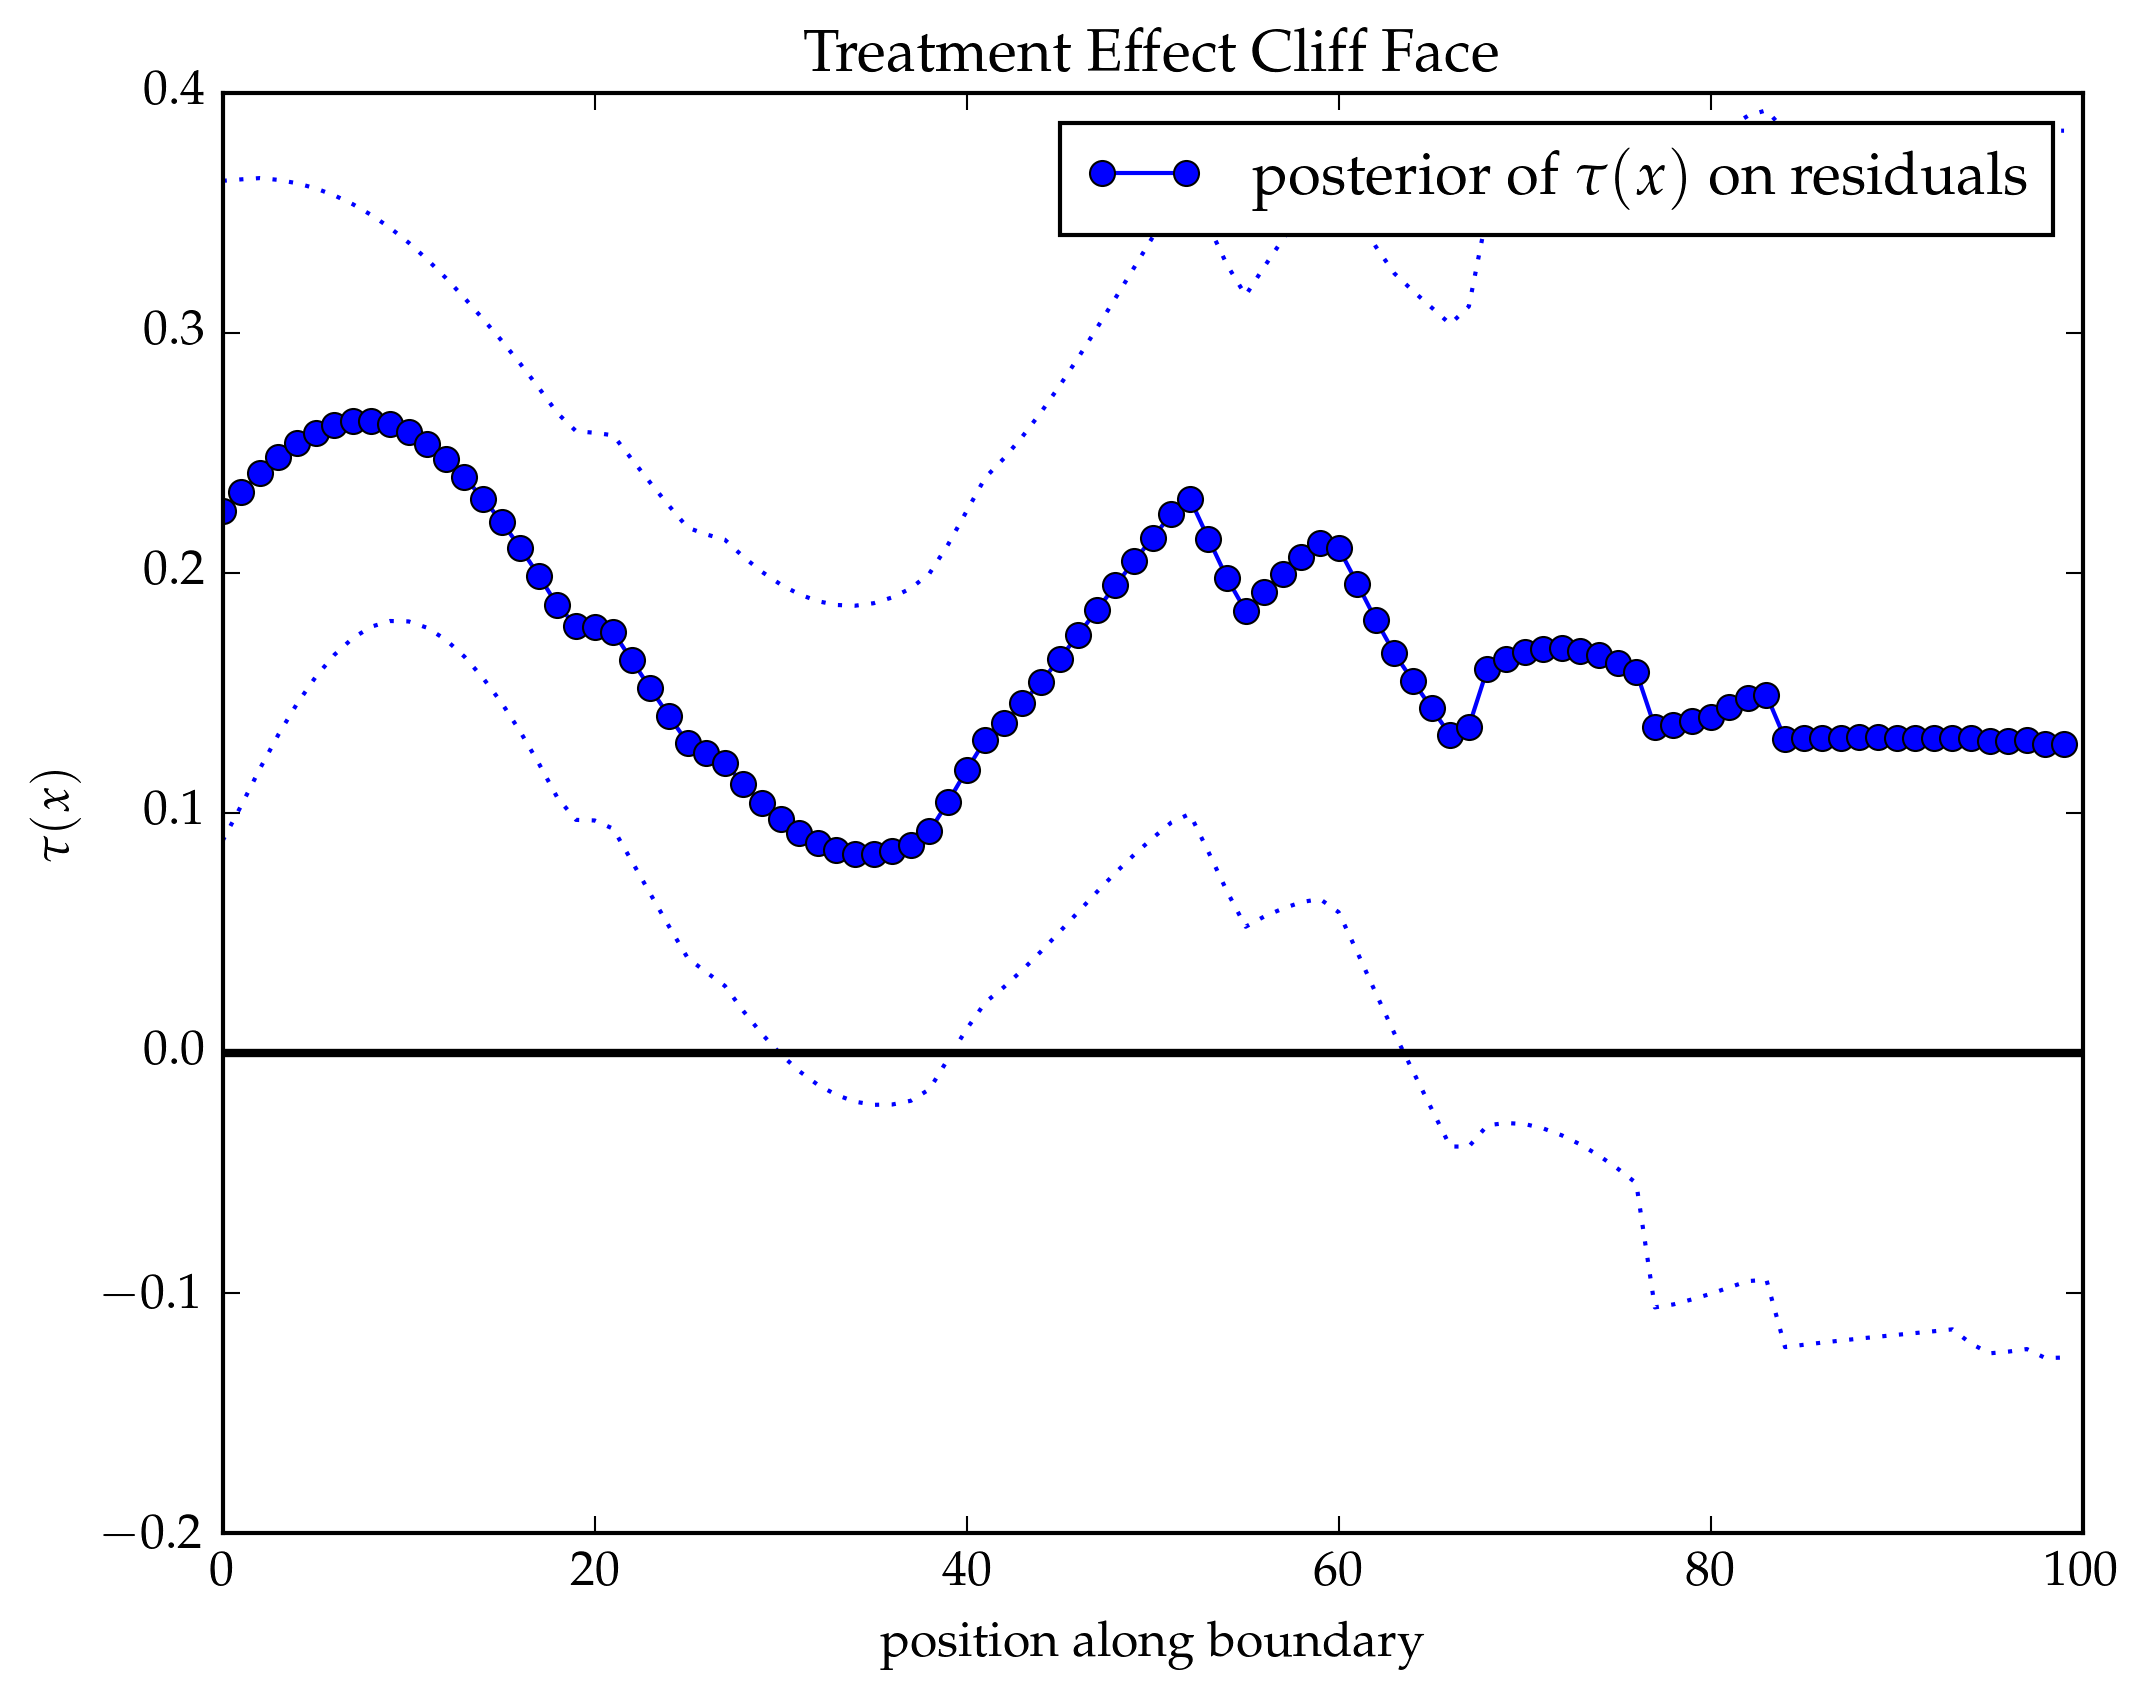

In [134]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", "-o", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

### Inverse variance

In [81]:
τpost=GeoRDD.inverse_variance(resid_μposterior, resid_Σposterior)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

τ|Y ∼ Normal(μ=0.178, σ=0.051)
P(τ>0|Y) = 99.979%

With the updated $\hat\beta$ and hyperparameters, the cliff face appears smoother, and the treatment effect gets a little bit weaker. There's a bigger increase in posterior variance when the border goes over the water.

### $\chi^2$ tests

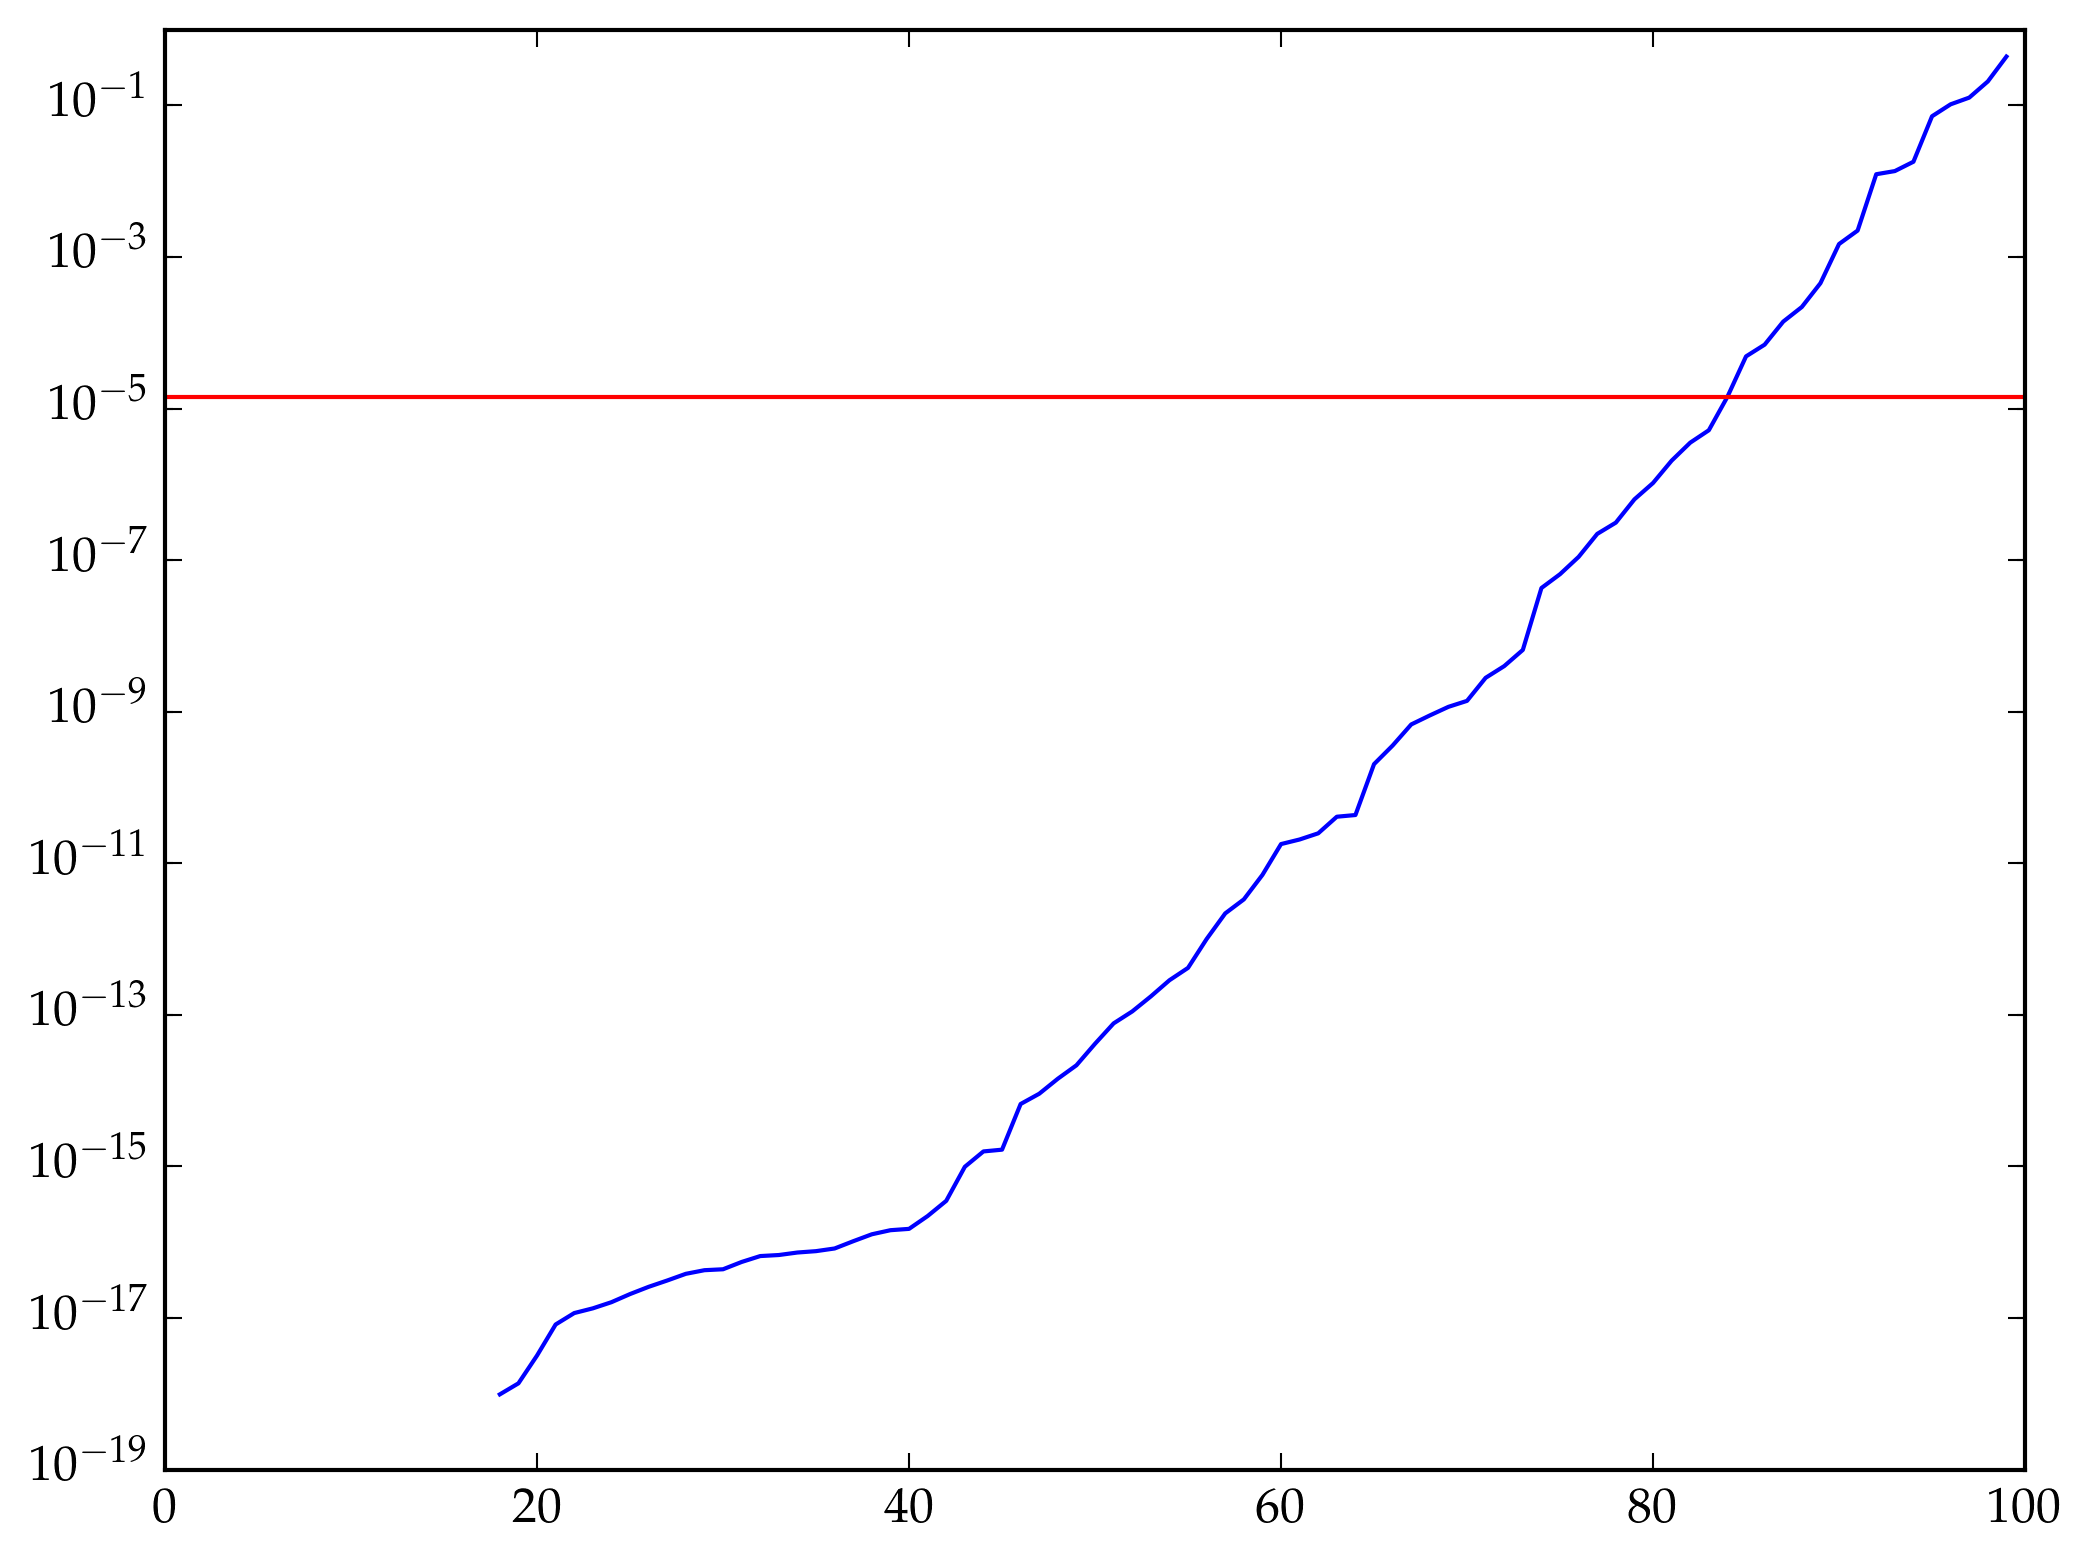

[-1.24211e-16,-1.04436e-16,-8.50295e-17,-8.05786e-17,-7.49595e-17,-6.52782e-17,-5.36148e-17,-5.01138e-17,-4.42197e-17,-3.73813e-17,-2.63865e-17,-2.28465e-17,-1.93289e-17,-1.39752e-17,-9.81973e-18,-5.50001e-18,-3.19615e-18,-2.16912e-18,9.84412e-19,1.37672e-18,3.20367e-18,8.22804e-18,1.16403e-17,1.34352e-17,1.61969e-17,2.07332e-17,2.58328e-17,3.13062e-17,3.83535e-17,4.28079e-17,4.40437e-17,5.49792e-17,6.57805e-17,6.78972e-17,7.32603e-17,7.63756e-17,8.28253e-17,1.03254e-16,1.2747e-16,1.44307e-16,1.50264e-16,2.21846e-16,3.52192e-16,9.90679e-16,1.58024e-15,1.6669e-15,6.67504e-15,9.11761e-15,1.439e-14,2.16386e-14,4.16282e-14,7.73393e-14,1.11139e-13,1.75445e-13,2.86604e-13,4.17545e-13,1.00326e-12,2.1855e-12,3.34267e-12,7.03712e-12,1.79502e-11,2.06353e-11,2.48941e-11,4.12062e-11,4.3382e-11,2.03653e-10,3.58211e-10,6.80034e-10,8.9461e-10,1.16109e-9,1.39205e-9,2.80417e-9,4.00395e-9,6.54479e-9,4.29168e-8,6.53382e-8,1.10582e-7,2.22246e-7,3.12821e-7,6.34939e-7,1.04331e-6,2.0559e-6,3.55283e-6,5.18079

6.598398267833361e-8

In [135]:
chisquare(resid_GP_dict_multi[distrA], 
          resid_GP_dict_multi[distrB],
          hcat(sentinels[distrA,distrB].coordinates...),
          1e-5,
          verbose=true,
          )

#### as a function of $\epsilon$

In [155]:
xϵ = logspace(-16,-1,200)
pval_ϵ = [chisquare(
              resid_GP_dict_multi[distrA], 
              resid_GP_dict_multi[distrB],
              hcat(sentinels[distrA,distrB].coordinates...),
          ϵ,
          verbose=false,
          ) for ϵ in xϵ]
;

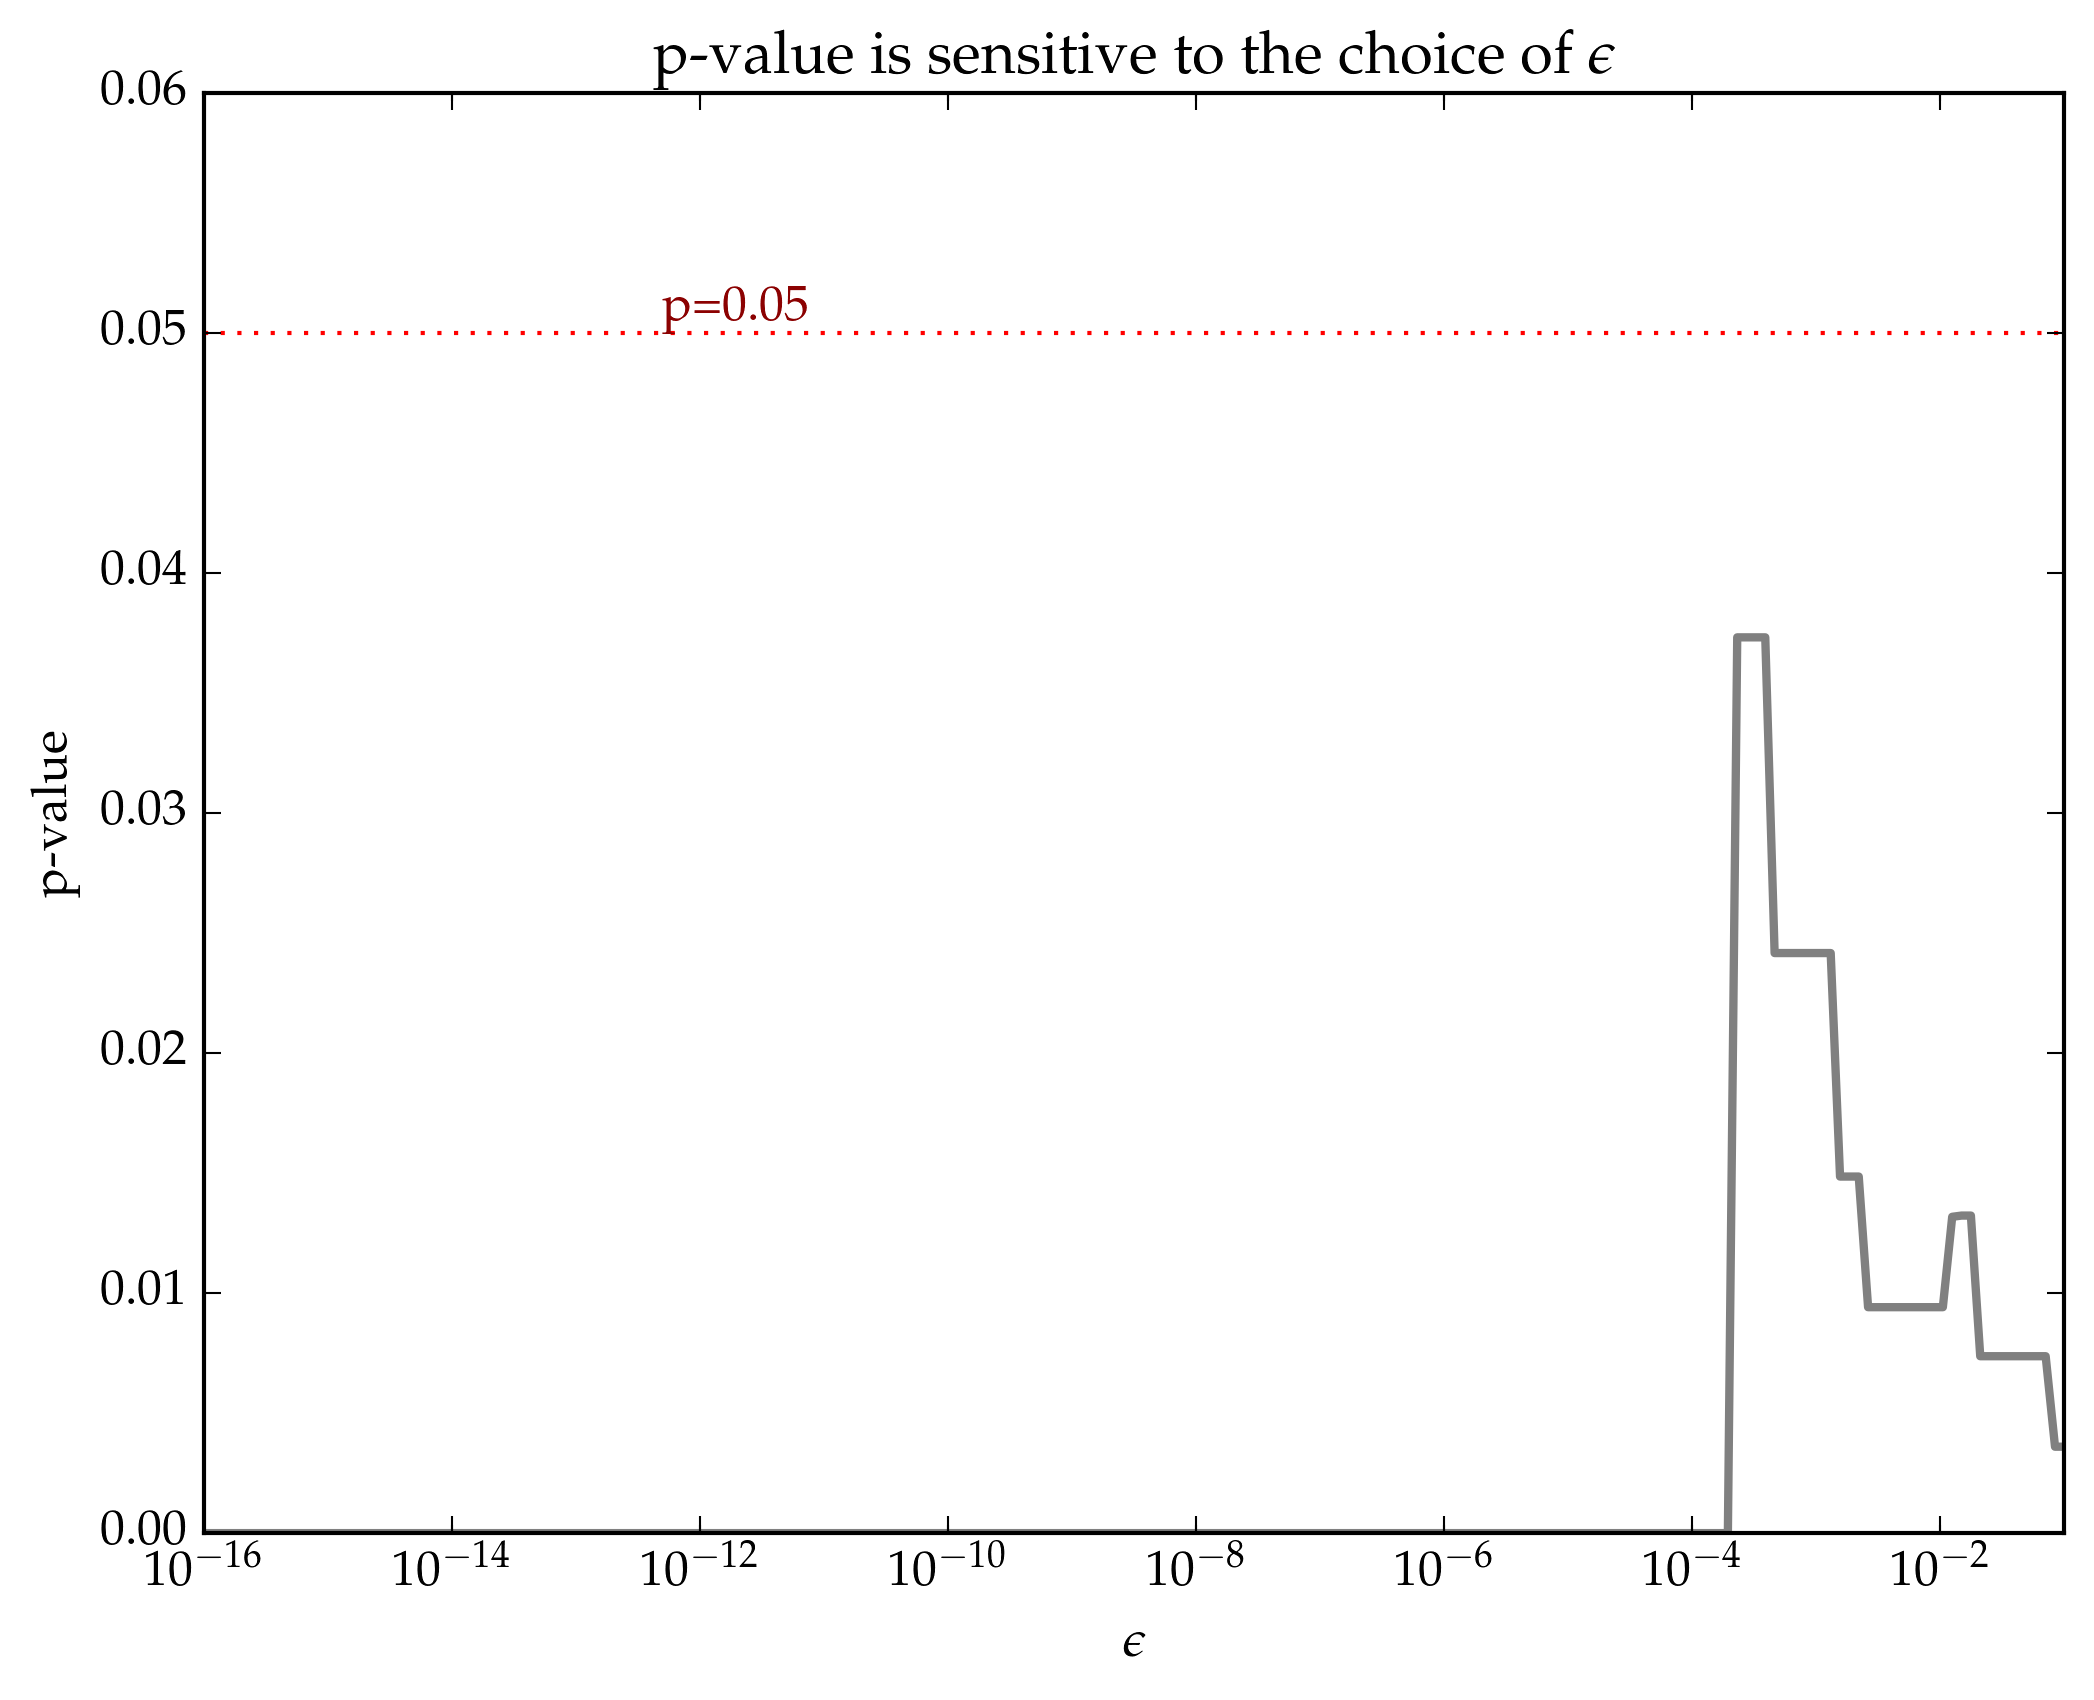

In [156]:
plt.semilogx(xϵ, pval_ϵ, "-", color="grey", linewidth=2)
plt.axhline(0.05, linestyle=":", color="red")
plt.text(x=xϵ[50], y=0.05, s="p=0.05", color="darkred", verticalalignment="bottom")
plt.title(L"p-value is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel("p-value")
;

### compare to simulated null

In [136]:
GeoRDD.tstat(resid_GP_dict_multi[distrA], 
             resid_GP_dict_multi[distrB], 
             hcat(sentinels[distrA,distrB].coordinates...))

17.833352565928408

## Pairwise treatment effect

In [82]:
τpost_pairs = Dict{Tuple{String,String},Normal}()
for (distrA,distrB) in keys(sentinels)
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    τpost = get_τpost(resid_GP_dict[distrA], resid_GP_dict[distrB], X◫)
    τpost_pairs[distrA,distrB] = τpost
end

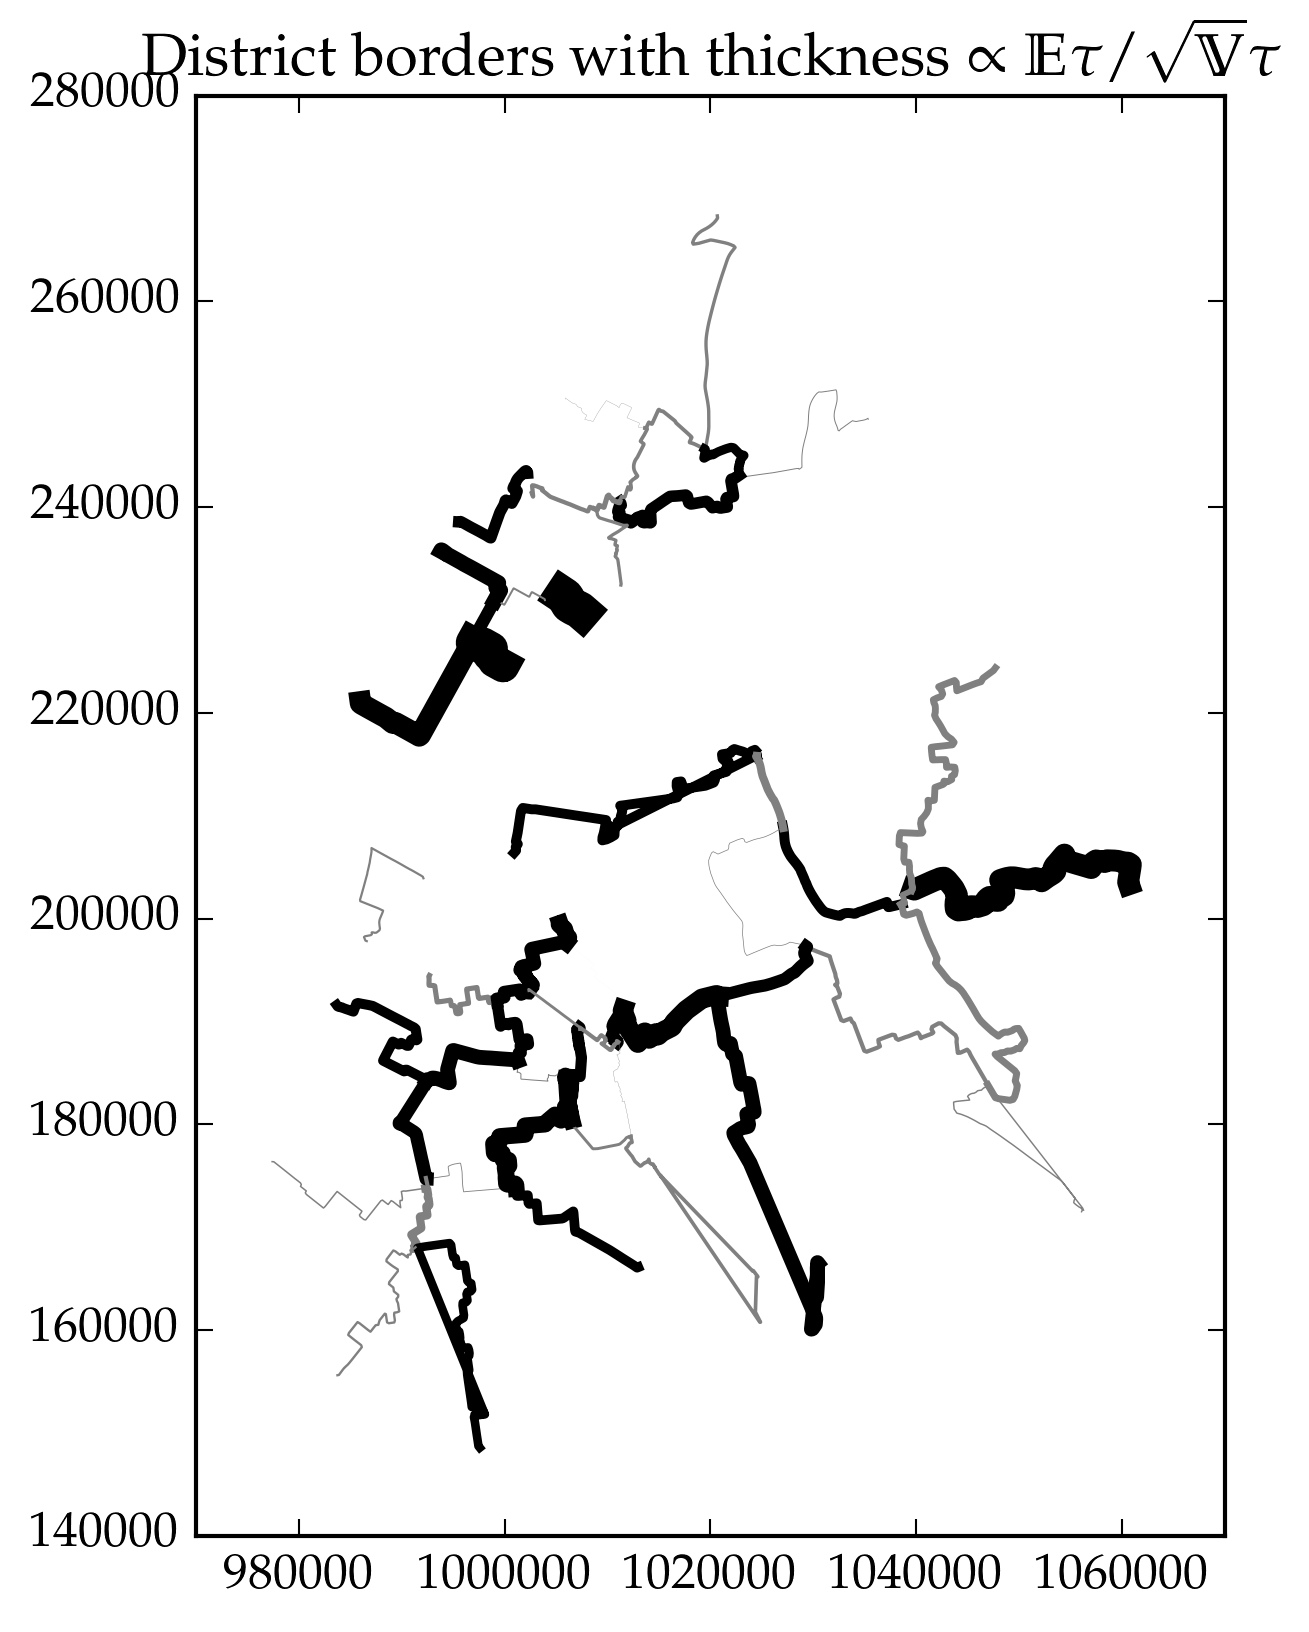

In [83]:
begin
    for distr_pair in keys(sentinels)
        distrA, distrB = distr_pair
        if distrA > distrB
            continue
        end
        X◫ = hcat(sentinels[distr_pair].coordinates...)

        τpost = τpost_pairs[distr_pair]
        eff_size = abs(mean(τpost)) / std(τpost)
        if eff_size > 2
            color="black"
        else
            color="gray"
        end
        plt.plot(X◫[1,:], X◫[2,:], linewidth=eff_size, color=color)
    end
    plt.gca()[:set_aspect]("equal")
    plt.title(L"District borders with thickness $\propto \mathbb{E}\tau/{\sqrt\mathbb{V}\tau}$ ")
end
;

![districts](NYC_plots/NYC_school_performances_croppped.png)

There isn't a clear trend in treatment effects getting stronger or weaker when we go from fitting the hyperparameters on a single district to multiple districts in Brooklyn and Queens. However, it does appear that treatment effects involving districts that were included in the hyperparameter fitting go down, whereas they go up in Manhattan.

One possible explanation is that some tax and building classes only appear in Manhattan, so that when we fit the linear regression parameters, those classes are given a coefficient of zero (no data, so the posterior mean is zero).

In [84]:
mgpcv.k

Type: GaussianProcesses.SEIso, Params: [8.21015,-1.69835]


In [85]:
cov(mgpcv.k, [0.0,0.0], [0.0,9000.0]) / cov(mgpcv.k, 0.0)

0.05010027493217753